# Relating Tracked Particles to Ram Pressure & Tidal Stripping

The code in this notebook ties together the tracked particles data (`../../Data/tracked_particles.hdf5`) with the ram pressure data (`../../Data/ram_pressure.hdf5`). 

`-- Hollis Akins, May 25 2021 --`

## Table of Contents
- [Overview](#overview)
- [Rates vs. Distance](#rates-distance)
- [Sanity check: Predicting Gas Mass](#sanity)
- [Expulsion Rate vs. Ram Pressure](#rates-pram)
- [Expulsion Probability](#expulsion-prob)
- [Tidal Effects](#tidal-effects)
- [Decomposing Restoring Pressure](#restoring-pressure)
- [Gas Depletion Times](#depletion)


In [1]:
# import my custom module which includes my analysis functions (also imports everything from base.py)
from analysis import * 

## Overview of ram pressure data <a class="anchor" id="overview"></a>

Ram pressure data is stored in an HDF5 file called `ram_pressure.hdf5`, and includes some properties of the satellites (masses, distances, etc) as well as the ram pressure calculations. The "simple" ram pressure calculation, based on a spherically averaged density profile, is stored in the column `Pram`. The advanced calculation (what I use throughout this work) is stored in `Pram_adv`. 

In [7]:
path = '../../Data/ram_pressure.hdf5'
with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])
print('Available keys:', *keys)

Available keys: h148_12 h148_249 h148_251 h148_27 h148_282 h148_34 h148_38 h148_55 h148_65 h229_14 h229_18 h229_20 h229_22 h229_49 h242_21 h242_38 h242_69 h329_117 h329_29


In [9]:
key = 'h148_65'
data = pd.read_hdf(path, key=key)

In [10]:
data.head()

t         a      h1dist        dNN              M_star  \
0  5.181190  0.457383  238.707163  69.425788   34713488.32365931   
0  5.868065  0.500057  183.186727  23.897312   34623077.36584153   
0  6.474131  0.537186  128.215708  63.221206   34526467.28079047   
0  6.905111  0.563402   93.500504  67.695722  34298735.834978476   
0  7.039793  0.571574   91.215422  24.084090   34237557.71221171   

                M_gas    satRvir    hostRvir     vel_CGM      rho_CGM  ...  \
0  151468379.17525762  24.971696  136.730159  160.994988   540.852419  ...   
0   83504532.71330039  11.946276  144.587569  190.474065  1092.882094  ...   
0  35694776.743595004  27.759195  156.773659  203.333161  2684.785368  ...   
0  23823077.995420776  28.083037  164.773772  249.994824  7109.934866  ...   
0  20887304.409883797  27.899993  167.197539  254.574431  6359.325334  ...   

   vel_CGM_adv         rho_CGM_adv  std_vel_CGM         std_rho_CGM  \
0   185.502828  2324.1982498737243    23.239570  1417.3332130235394   
0   243.069826  13459.216025744767    13.741663   4301.197340207454   
0   201.521745  2763.0561565269045    17.362562   802.0220016487892   
0   301.519642   4883.145227184419    28.577963  3703.5566987777065   
0   241.366715    3163.58987389688    47.160784   733.3784640377369   

             Pram_adv               Prest            SigmaGas      dphidz  \
0     79978681.739101  2700293529.7712936   12605636.49140947  214.213184   
0   795210057.1093357  1891804258.7490153   8327430.763477624  227.177423   
0  112210511.91037598    753859737.737286  3585674.2987513095  210.242112   
0   443946725.7573162   716296471.3213655  3848643.6078130854  186.116602   
0   184304074.0798538  1197743293.6346092   6645946.402528069  180.221630   

        SFR         sSFR  
0  0.008337   2.4018e-10  
0  0.000847  2.44572e-11  
0  0.000000          0.0  
0  0.000000          0.0  
0  0.000000          0.0  

[5 rows x 22 columns]

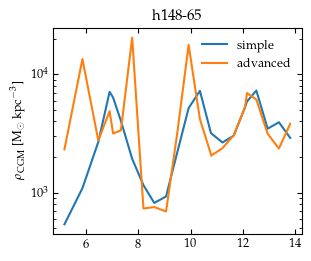

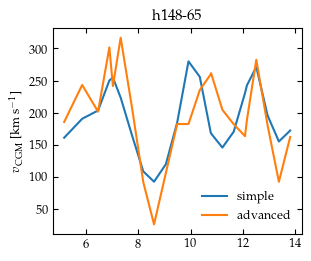

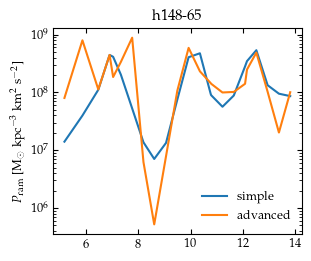

/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
/Users/hollis/anaconda3/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: divide by zero encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


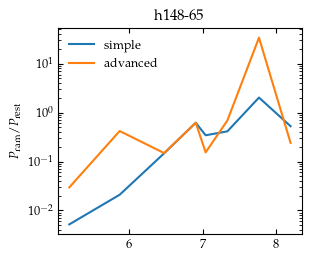

In [11]:
plt.figure(dpi=100, figsize=(3,2.5))
plt.title(key.replace('_','-'))
plt.ylabel(r'$\rho_{\rm CGM}$ [M$_{\odot}~\mathrm{kpc}^{-3}$]')
plt.plot(data.t, data.rho_CGM, label='simple')
plt.plot(data.t, data.rho_CGM_adv, label='advanced')
plt.semilogy()
plt.legend()
plt.show()

plt.figure(dpi=100, figsize=(3,2.5))
plt.title(key.replace('_','-'))
plt.ylabel(r'$v_{\rm CGM}$ [km~s$^{-1}$]')
plt.plot(data.t, data.vel_CGM, label='simple')
plt.plot(data.t, data.vel_CGM_adv, label='advanced')
plt.legend()
plt.show()

plt.figure(dpi=100, figsize=(3,2.5))
plt.title(key.replace('_','-'))
plt.ylabel(r'$P_{\rm ram}$ [M$_{\odot}~\mathrm{kpc}^{-3}~\mathrm{km}^2~\mathrm{s}^{-2}$]')
plt.plot(data.t, data.Pram, label='simple')
plt.plot(data.t, data.Pram_adv, label='advanced')
plt.semilogy()
plt.legend()
plt.show()


plt.figure(dpi=100, figsize=(3,2.5))
plt.title(key.replace('_','-'))
plt.ylabel(r'$P_{\rm ram} / P_{\rm rest}$')
plt.plot(data.t, np.array(data.Pram)/np.array(data.Prest), label='simple')
plt.plot(data.t, np.array(data.Pram_adv)/np.array(data.Prest), label='advanced')
plt.semilogy()
plt.legend()
plt.show()

### Schematic Figure

Summary figure showing what the different events of heating, cooling, accretion, expulsion correspond to. The disk vs. the halo of the satellite is defined thermodynamically, while the bounds of the satellite are defined via AHF's gravitational binding calculations. Note that gas can be accreted onto the halo or onto the disk, and similarly can be expelled from the halo or the disk. However, heating and cooling refer only to the cycling of gas between the disk and the halo. 

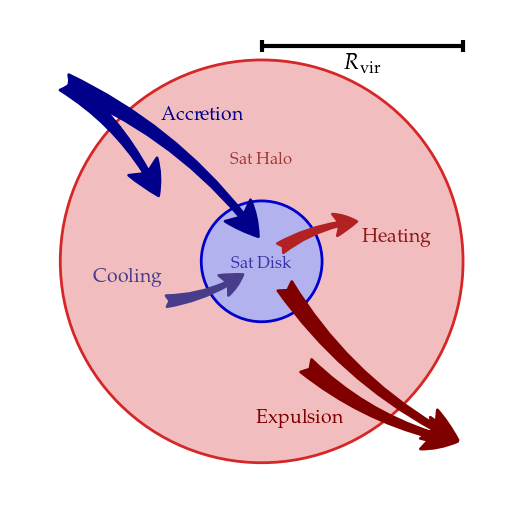

In [25]:
fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))

circ = mpl.patches.Circle((0,0),radius=10, fc='tab:red', ec='none', alpha=0.3)
ax.add_patch(circ)

circ = mpl.patches.Circle((0,0),radius=10, fc='none', ec='tab:red')
ax.add_patch(circ)

circ = mpl.patches.Circle((0,0), radius=3, fc='w', ec='none')
ax.add_patch(circ)

circ = mpl.patches.Circle((0,0), radius=3, fc='mediumblue', ec='none', alpha=0.3)
ax.add_patch(circ)

circ = mpl.patches.Circle((0,0), radius=3, fc='none', ec='mediumblue')
ax.add_patch(circ)

ax.set_aspect('equal')

style = "fancy, tail_width=0.2"
kw = dict(arrowstyle=style, mutation_scale=30)
a1 = mpl.patches.FancyArrowPatch((-10, 9), (-5, 3), connectionstyle="arc3,rad=-0.14", **kw, color='darkblue')
ax.add_patch(a1)
a11 = mpl.patches.FancyArrowPatch((-10, 9), (0, 1), connectionstyle="arc3,rad=-0.14", **kw, color='darkblue')
ax.add_patch(a11)
ax.annotate('Accretion', (-5, 7), fontsize=7, color='darkblue')

a2 = mpl.patches.FancyArrowPatch((2, -5), (10, -9), connectionstyle="arc3,rad=0.14", **kw, color='maroon')
ax.add_patch(a2)
a21 = mpl.patches.FancyArrowPatch((1, -1), (10, -9), connectionstyle="arc3,rad=0.14", **kw, color='maroon')
ax.add_patch(a21)
ax.annotate('Expulsion', (4, -8), fontsize=7, ha='right', color='maroon')




kw = dict(arrowstyle=style, mutation_scale=20)
a3 = mpl.patches.FancyArrowPatch((0.7,0.5), (5, 2), connectionstyle="arc3,rad=-0.14", **kw, color='firebrick')
ax.add_patch(a3)
ax.annotate('Heating', (5, 1), fontsize=7, ha='left', color='firebrick')
ax.annotate('Heating', (5, 1), fontsize=7, ha='left', color='k', alpha=0.2)

a4 = mpl.patches.FancyArrowPatch((-5, -2), (-0.7,-0.5), connectionstyle="arc3,rad=0.14", **kw, color='darkslateblue')
ax.add_patch(a4)
ax.annotate('Cooling', (-5, -1), fontsize=7, ha='right', color='darkslateblue')
ax.errorbar([5],[10.7], xerr=5, elinewidth=1.5, capsize=2, capthick=1.5, ms=0, color='k')
ax.annotate(r'$R_{\rm vir}$', (5, 9.5), ha='center', fontsize=8)
ax.set_xlim(-12,12)
ax.set_ylim(-12,12)

ax.axis('off')

ax.annotate('Sat Disk', (0,-0.2), ha='center', va='center', color='darkblue', fontsize=6, alpha=0.7)

ax.annotate('Sat Halo', (0,5), ha='center', va='center', color='maroon', fontsize=6, alpha=0.7)


plt.savefig('plots/flow_schematic.pdf')
plt.show()

In [1]:
from analysis import *

### How to import the data

Here, we use a function defined in `analysis.py` to read in a merged dataset containing rates of expulsion, accretion, etc as well as ram pressure calculations and basic galaxy properties. Note that here, the column `ratio` is the ratio of `Pram_adv` to `Prest`. See `read_ram_pressure()` in `analysis.py` for a detailed descripton of what each column in this dataset represents.

In [2]:
data_all = read_all_ram_pressure()

1 Returning (expelled, accreted) for h148-12...
2 Returning (expelled, accreted) for h148-249...
3 Returning (expelled, accreted) for h148-251...
4 Returning (expelled, accreted) for h148-27...
5 Returning (expelled, accreted) for h148-282...
6 Returning (expelled, accreted) for h148-34...
7 Returning (expelled, accreted) for h148-38...
8 Returning (expelled, accreted) for h148-55...
9 Returning (expelled, accreted) for h148-65...
10 Returning (expelled, accreted) for h229-14...
11 Returning (expelled, accreted) for h229-18...
12 Returning (expelled, accreted) for h229-20...
13 Returning (expelled, accreted) for h229-22...
14 Returning (expelled, accreted) for h229-49...
15 Returning (expelled, accreted) for h242-21...
16 Returning (expelled, accreted) for h242-38...
17 Returning (expelled, accreted) for h242-69...
18 Returning (expelled, accreted) for h329-117...
19 Returning (expelled, accreted) for h329-29...


## Flow rates. vs distance <a class="anchor" id="rates-distance"></a>

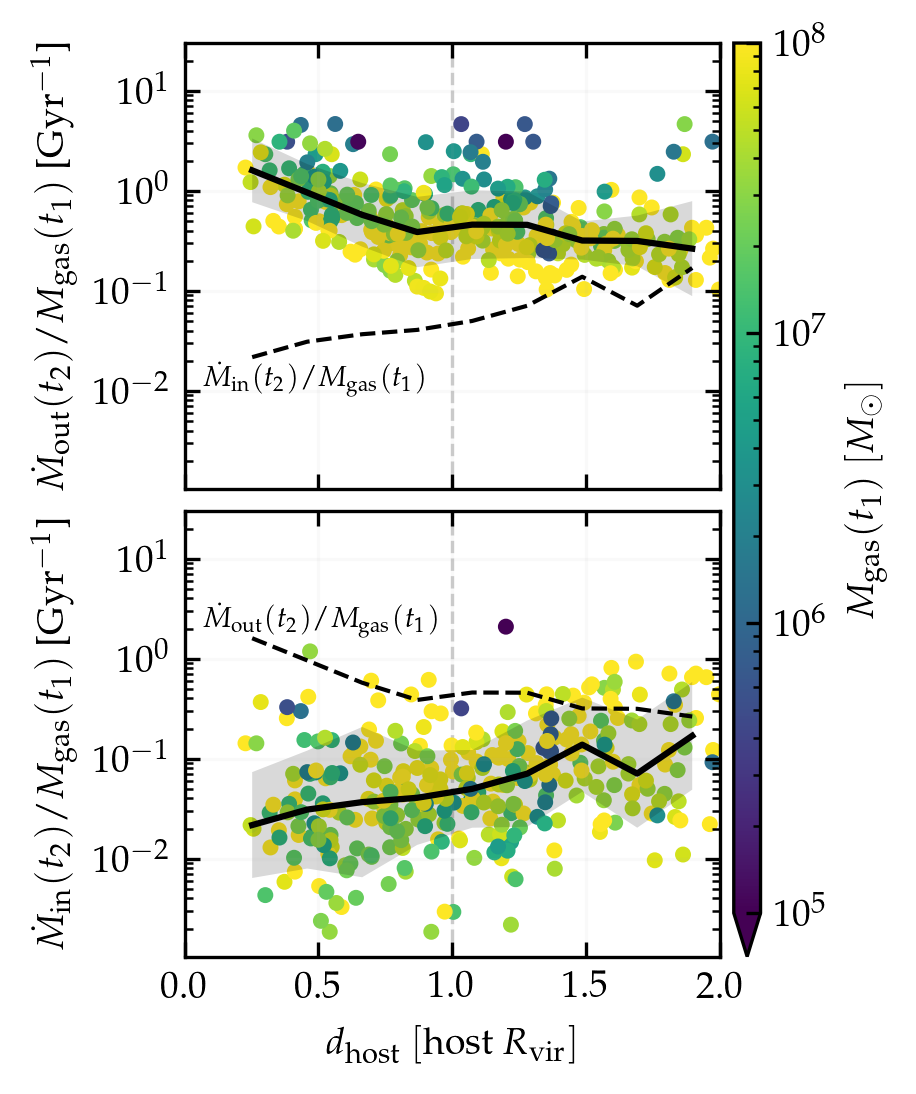

In [8]:
fig = plt.figure(dpi=300, figsize=(3, 3.5), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=2, ncols=2, width_ratios = [1,0.05], hspace=0.05, wspace=0.05)
gs.update(left=0.18, right=0.82, top=0.98, bottom=0.11)

ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
cax = plt.subplot(gs[:,1])
ax = [ax0,ax1]

x = data_all.h1dist/data_all.hostRvir
c = data_all.Mgas_div
# norm = mpl.colors.LogNorm()
norm = mpl.colors.LogNorm(vmin=1e5, vmax=1e8)

# im = ax[0].scatter(x, data_all.Mdot_ejected_by_Mdisk, s=8, c=c, norm=norm)
# im = ax[1].scatter(x, data_all.Mdot_cooled_by_Mdisk, s=8, c=c, norm=norm)
im = ax[0].scatter(x, data_all.Mdot_expelled_by_Mgas, s=8, c=c, norm=norm)
im = ax[1].scatter(x, data_all.Mdot_accreted_by_Mgas, s=8, c=c, norm=norm)
fig.colorbar(im, cax=cax, label=r'$M_{\rm gas}(t_1)~[M_\odot]$', extend='min')

bins = np.linspace(0.15, 2, 10)

# ax[0].plot_median(x, data_all.Mdot_ejected_by_Mdisk, logx=False, logy=True, std=True, color='k', bins=bins)
# ax[0].plot_median(x, data_all.Mdot_cooled_by_Mdisk, logx=False, logy=True, std=False, color='k', linestyle='--', linewidth=1, bins=bins)

# ax[1].plot_median(x, data_all.Mdot_cooled_by_Mdisk, logx=False, logy=True, std=True, color='k', bins=bins)
# ax[1].plot_median(x, data_all.Mdot_ejected_by_Mdisk, logx=False, logy=True, std=False, color='k', linestyle='--', linewidth=1, bins=bins)

ax[0].plot_median(x, data_all.Mdot_expelled_by_Mgas, logx=False, logy=True, std=True, color='k', bins=bins)
ax[0].plot_median(x, data_all.Mdot_accreted_by_Mgas, logx=False, logy=True, std=False, color='k', linestyle='--', linewidth=1, bins=bins)
ax[0].annotate(r'$\dot{M}_{\rm in}(t_2)/M_{\rm gas}(t_1)$',(0.07, 1.1e-2), fontsize=7)

ax[1].plot_median(x, data_all.Mdot_accreted_by_Mgas, logx=False, logy=True, std=True, color='k', bins=bins)
ax[1].plot_median(x, data_all.Mdot_expelled_by_Mgas, logx=False, logy=True, std=False, color='k', linestyle='--', linewidth=1, bins=bins)
ax[1].annotate(r'$\dot{M}_{\rm out}(t_2)/M_{\rm gas}(t_1)$',(0.07, 2.05), fontsize=7)

# ax[0].set_ylabel(r'$\dot{M}_{\rm heated}/M_{\rm disk}$ [Gyr$^{-1}$]')
# ax[1].set_ylabel(r'$\dot{M}_{\rm cooled}/M_{\rm disk}$ [Gyr$^{-1}$]')
ax[0].set_ylabel(r'$\dot{M}_{\rm out}(t_2)/M_{\rm gas}(t_1)$ [Gyr$^{-1}$]')
ax[1].set_ylabel(r'$\dot{M}_{\rm in}(t_2)/M_{\rm gas}(t_1)$ [Gyr$^{-1}$]')
ax[1].set_xlabel(r'$d_{\rm host}~[{\rm host}~R_{\rm vir}]$')

ax[0].tick_params(labelbottom=False)
    
for a in ax:
    a.semilogy()
    a.set_xlim(0, 2)
    a.set_ylim(1.05e-3, 3e1)
    a.grid(alpha=0.07, zorder=-1000)
    a.plot([1,1],[1e-3,1e3],color='0.8', linestyle='--', linewidth=0.8, zorder=-100)
    

plt.savefig('plots/outflow_inflow.pdf')
plt.show()

## Expulsion Rates vs. Ram Pressure <a class="anchor" id="rates-pram"></a>

Here, we related the rate of expulsion to the ram pressure the satellite experiences. First things first, we want to determine whether we want to normalize the expulsion rate to $M_{\rm gas}$, normalize $P_{\rm ram}$ to $P_{\rm rest}$, or both, or neither. 

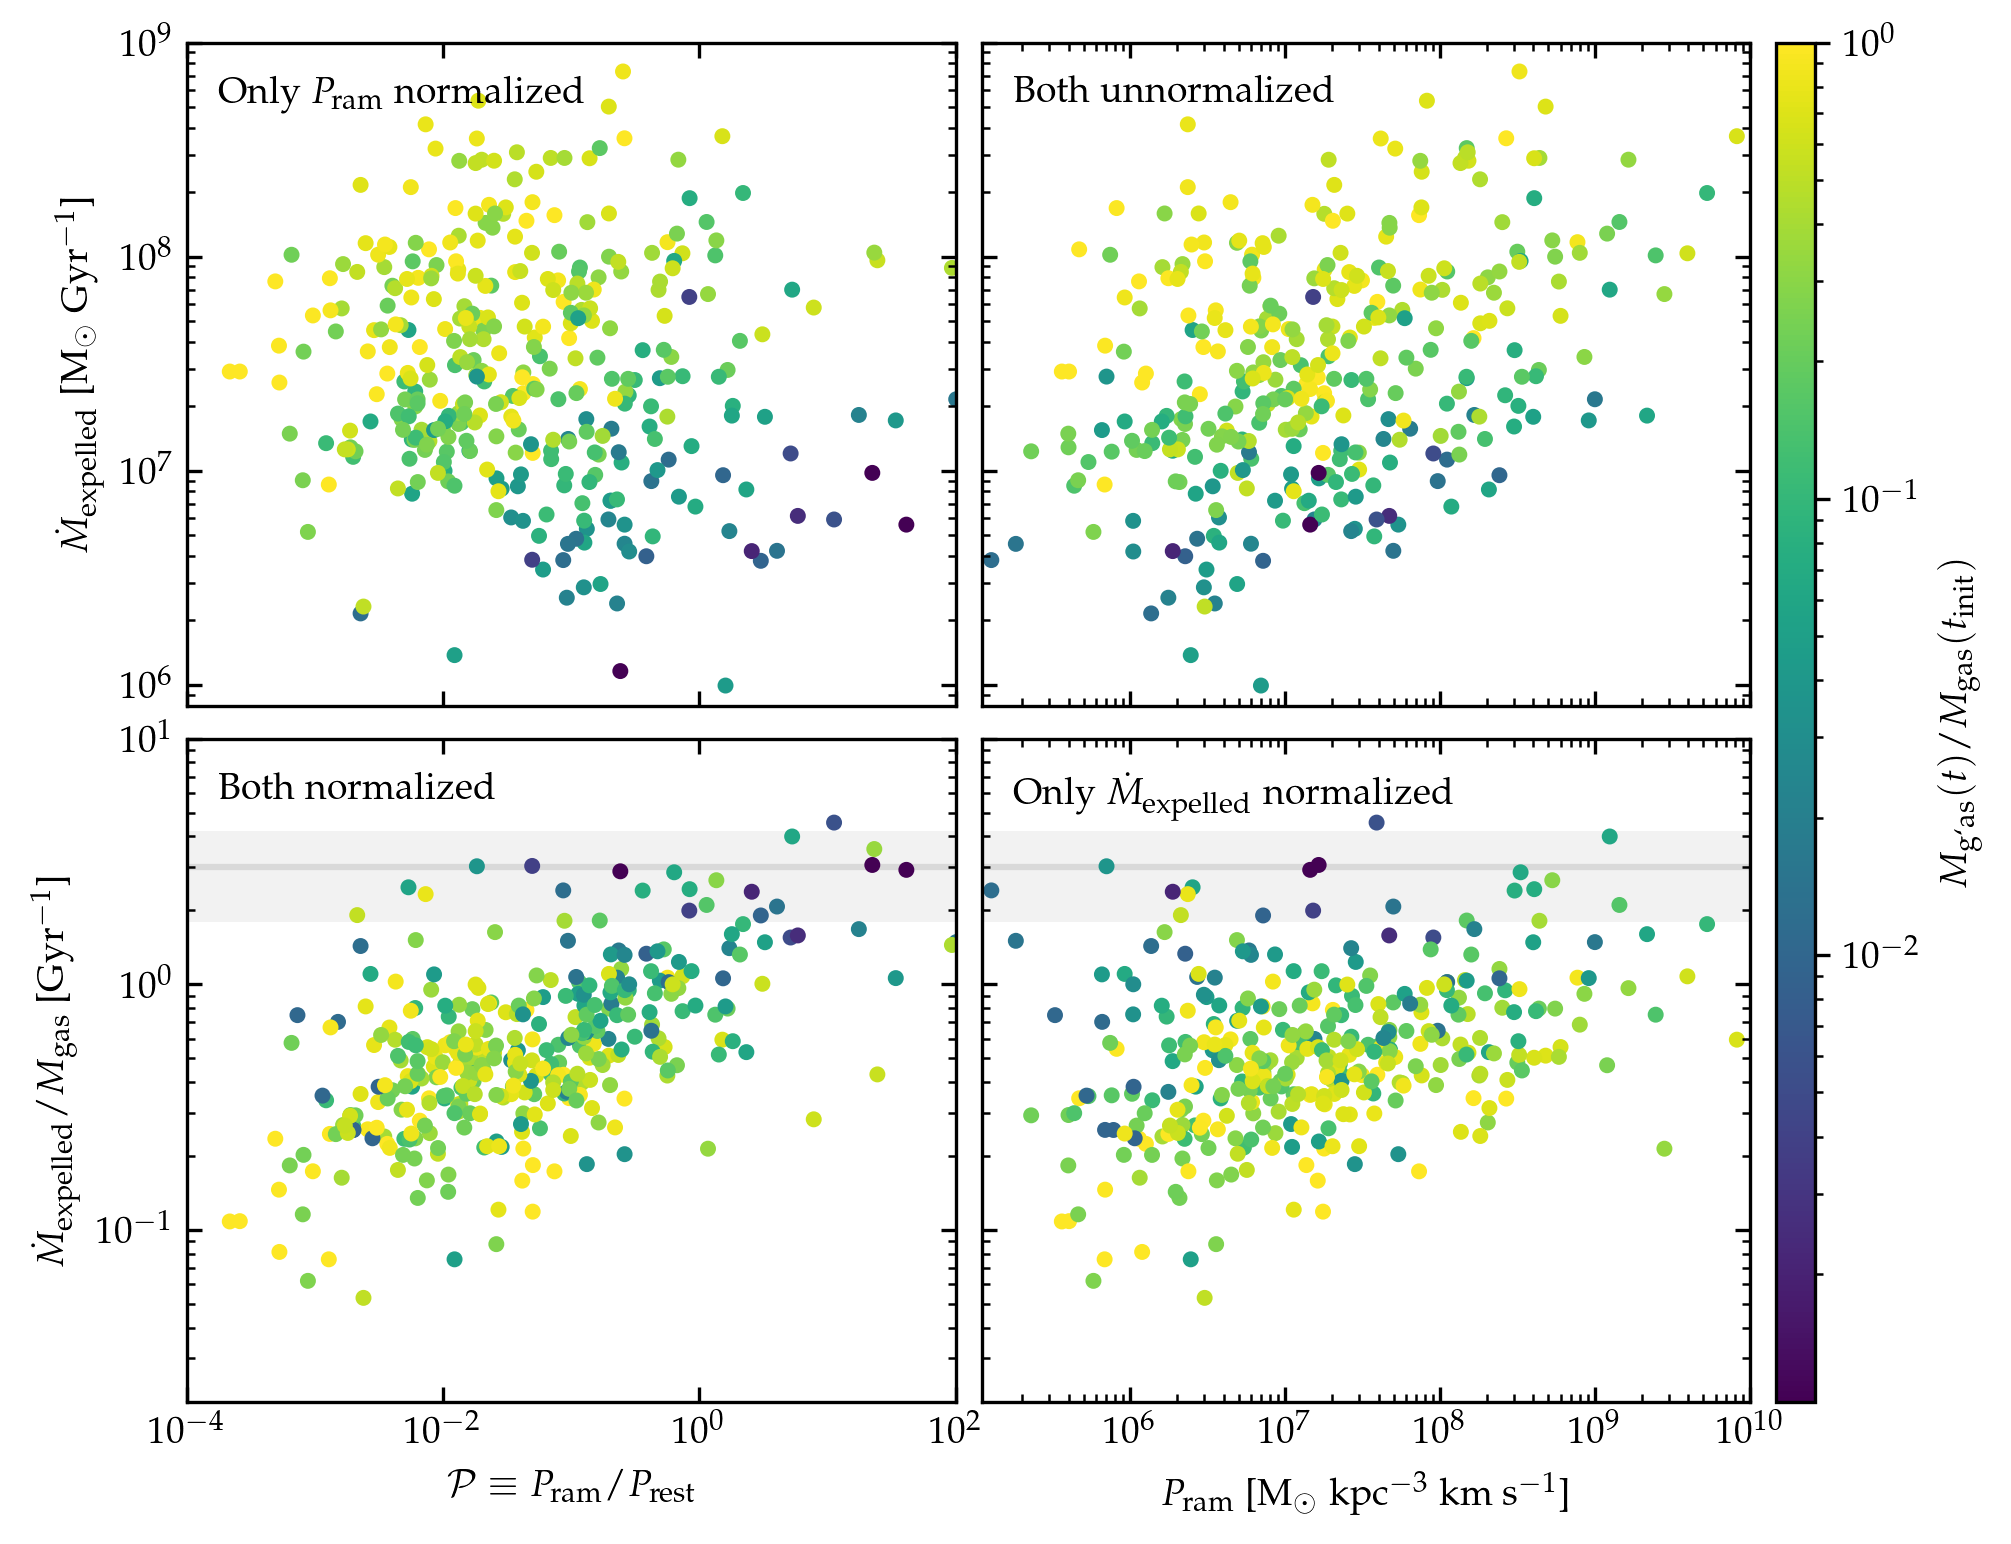

In [17]:
fig = plt.figure(dpi=300, figsize=(7,6))
gs = mpl.gridspec.GridSpec(nrows=2, ncols=3, width_ratios=[1,1,0.05])
gs.update(hspace=0.05, wspace=0.05)

rax0 = plt.subplot(gs[0,0])
rax1 = plt.subplot(gs[1,0])
Pax0 = plt.subplot(gs[0,1])
Pax1 = plt.subplot(gs[1,1])
cbax = plt.subplot(gs[:,2])
c = data_all.f_gas
norm = mpl.colors.LogNorm(vmax=1, vmin=1.05e-3)

im = rax0.scatter(data_all.ratio, data_all.Mdot_expelled, s=8, c=c, norm=norm)
rax0.set_ylabel(r'$\dot{M}_{\rm expelled}$ [M$_{\odot}$ Gyr$^{-1}$]')
rax0.loglog()
rax0.set_xlim(1e-4, 1e2)
rax0.set_ylim(8e5, 1e9)

im = rax1.scatter(data_all.ratio, data_all.Mdot_expelled_by_Mgas, s=8, c=c, norm=norm)
rax1.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$')
rax1.set_ylabel(r'$\dot{M}_{\rm expelled}/M_{\rm gas}$ [Gyr$^{-1}$]')
rax1.loglog()
rax1.set_xlim(1e-4, 1e2)
rax1.set_ylim(2e-2, 1e1)
rax1.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
rax1.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)

im = Pax0.scatter(data_all.Pram_adv, data_all.Mdot_expelled, s=8, c=c, norm=norm)
Pax0.loglog()
Pax0.set_xlim(1.1e5, 1e10)
Pax0.set_ylim(8e5, 1e9)

im = Pax1.scatter(data_all.Pram_adv, data_all.Mdot_expelled_by_Mgas, s=8, c=c, norm=norm)
Pax1.set_xlabel(r'$P_{\rm ram}$ [M$_{\odot}$ kpc$^{-3}$ km s$^{-1}$]')
Pax1.loglog()
Pax1.set_xlim(1.1e5, 1e10)
Pax1.set_ylim(2e-2, 1e1)
Pax1.plot([1e5,1e10],[3,3],color='0.85', zorder=-90)
Pax1.fill_between([1e5,1e10],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)

Pax1.tick_params(direction='in', which='both', top=True, right=True, labelleft=False)
Pax0.tick_params(direction='in', which='both', top=True, right=True, labelleft=False, labelbottom=False)
rax0.tick_params(direction='in', which='both', top=True, right=True, labelbottom=False)
rax1.tick_params(direction='in', which='both', top=True, right=True)

fig.colorbar(im, cax=cbax, label=r'$M_{\rm g`as}(t)/M_{\rm gas}(t_{\rm init})$')

rax0.annotate(r'Only $P_{\rm ram}$ normalized', (0.04, 0.95), xycoords='axes fraction', va='top')
rax1.annotate('Both normalized', (0.04, 0.95), xycoords='axes fraction', va='top')
Pax0.annotate('Both unnormalized', (0.04, 0.95), xycoords='axes fraction', va='top')
Pax1.annotate(r'Only $\dot{M}_{\rm expelled}$ normalized', (0.04, 0.95), xycoords='axes fraction', va='top')

plt.show()

Deciding what plot to use: 

1. Only $P_{\rm ram}$ normalized. 
    - This plot shows that expulsion rates go down with increasing ram pressure. While that may be true, this is really because satellites with very low gas mass (that have high $P_{\rm rest}$ don't have much to expel. This makes this plot not very useful. 
2. Both normalized
    - This plot shows a power-law relationship of increasing expulsion rates with increasing ram pressure ratio. However, this is almost by construction, since satellites with low gas mass will always appear in the top-right, and these points carry most of the visual weight of the linear relationship. 
3. Both unnormalized
    - This plot shows a similar power-law relationship but you have to do the normalization yourself, by eye. It seems that there is a relationship between x and y at constant $f_{\rm gas}$.
4. Only $\dot{M}_{\rm expelled}$ normalized. 
    - This plot still shows the basic power-law trend of plot 2, but the low gas mass satellites aren't concentrated in any particular part of the plot. 
    

Overall: 
- I want to normalize by $M_{\rm gas}$ because I want to be able to interpret these as depletion times. However, that may be more useful in a plot with net expulsion-accretion, since we could theoretically relate that to the quenching timescales. 
- I want to normalize by $P_{\rm rest}$ since thats common in the literature and I'm considering using $P_{\rm rest}$ to make an argument about the role of tidal stripping (in decreasing restoring pressure). 

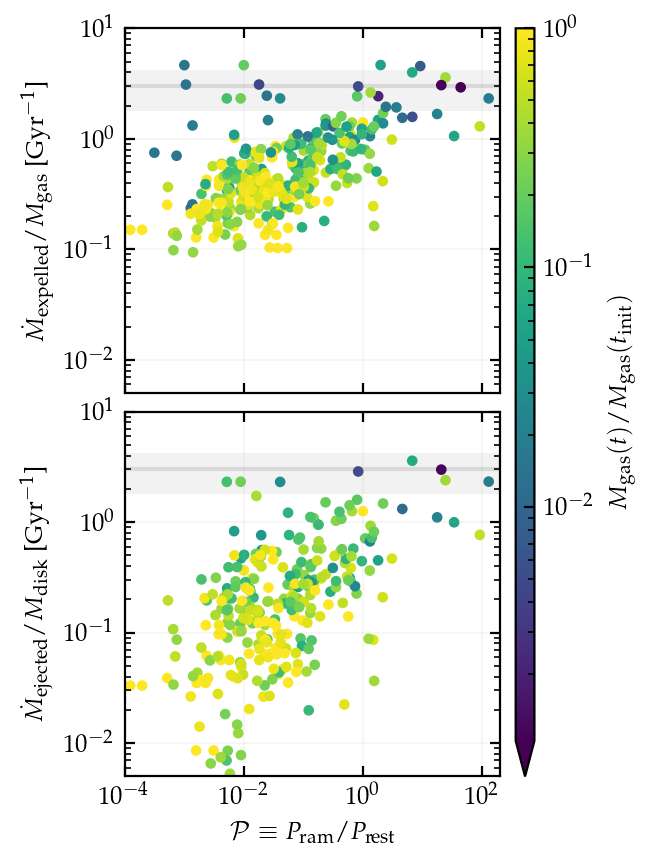

In [4]:
fig = plt.figure(dpi=200, figsize=(3.2,4.3), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=2, ncols=2, width_ratios = [1,0.05])
cax = plt.subplot(gs[:,1])

ax = plt.subplot(gs[0,0])

im = ax.scatter(data_all.ratio, data_all.Mdot_expelled_by_Mgas, s=8, c=data_all.f_gas, norm=mpl.colors.LogNorm(vmax=1, vmin=1.05e-3))
# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm expelled}/M_{\rm gas}$ [Gyr$^{-1}$]')
ax.loglog()
ax.set_xlim(1e-4, 2e2)
ax.set_ylim(5e-3, 1e1)
ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True, labelbottom=False)
ax.grid(alpha=0.1, zorder=-1000)

ax = plt.subplot(gs[1,0])

im = ax.scatter(data_all.ratio, data_all.Mdot_expelled_disk_by_Mdisk, s=8, c=data_all.f_gas, norm=mpl.colors.LogNorm(vmax=1, vmin=1.05e-3))
fig.colorbar(im, cax=cax, label=r'$M_{\rm gas}(t)/M_{\rm gas}(t_{\rm init})$', extend='min')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm ejected}/M_{\rm disk}$ [Gyr$^{-1}$]')
ax.loglog()
ax.set_xlim(1e-4, 2e2)
ax.set_ylim(5e-3, 1e1)
ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)

plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

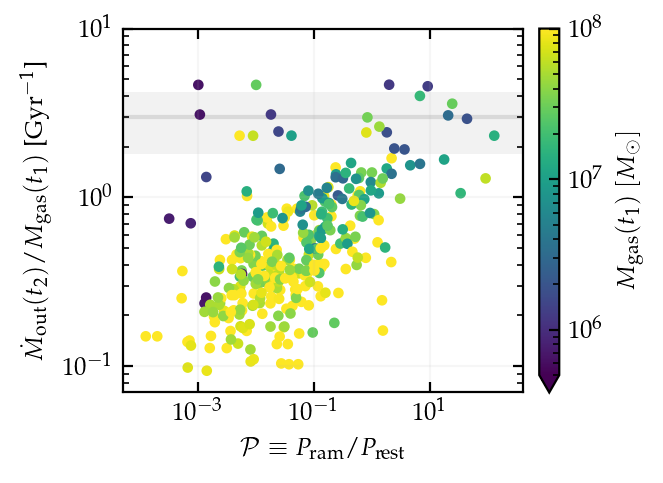

In [37]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=True)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05], figure=fig)
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])


im = ax.scatter(data_all.ratio, data_all.Mdot_expelled_by_Mgas, s=8, c=data_all.Mgas_div, norm=mpl.colors.LogNorm(vmin=5e5, vmax=1e8))

#data = data_all[data_all.key=='h148_27']
#ax.scatter(data.ratio, data.Mdot_expelled_by_Mgas, s=8, fc='none', ec='r')

# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm out}(t_2)/M_{\rm gas}(t_1)$ [Gyr$^{-1}$]')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.loglog()
ax.set_xlim(5e-5, 4e2)
ax.set_ylim(7e-2, 1e1)
ax.plot([1e-5,1e3],[3,3],color='0.85', zorder=-90)
ax.fill_between([1e-5,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)

fig.colorbar(im, cax=cax, label=r'$M_{\rm gas}(t_1)~[M_\odot]$', extend='min')

# plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
plt.savefig('plots/Mdot_Pram.pdf')
plt.show()

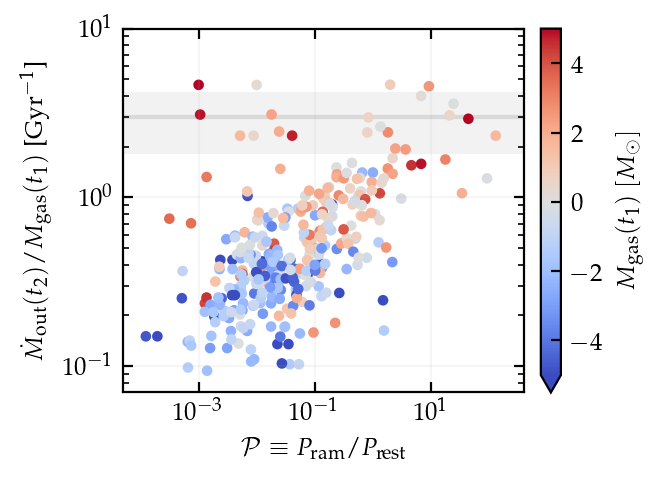

In [34]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=True)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05], figure=fig)
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])


im = ax.scatter(data_all.ratio, data_all.Mdot_expelled_by_Mgas, s=8, c=data_all.t-data_all.tquench, vmin=-5, vmax=5, cmap='coolwarm')

# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm out}(t_2)/M_{\rm gas}(t_1)$ [Gyr$^{-1}$]')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.loglog()
ax.set_xlim(5e-5, 4e2)
ax.set_ylim(7e-2, 1e1)
ax.plot([1e-5,1e3],[3,3],color='0.85', zorder=-90)
ax.fill_between([1e-5,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)

fig.colorbar(im, cax=cax, label=r'$M_{\rm gas}(t_1)~[M_\odot]$', extend='min')

# plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
# plt.savefig('plots/Mdot_Pram.pdf')
plt.show()

In [36]:
np.unique(data_all.tquench)

array([ 4.9758983 ,  5.86816237,  7.33618929,  7.76716967,  8.09040495,
        8.73687552,  8.73687552,  9.06011081,  9.49109119,  9.70658138,
        9.92207157, 10.76719716, 12.15104823, 12.29246366, 12.93893423,
       13.36991461, 13.5854048 ])

# h229_14, h148_34, h148_27

h148_12
h148_249
h148_27
h148_65
h229_18
h242_38
h242_69
h329_29


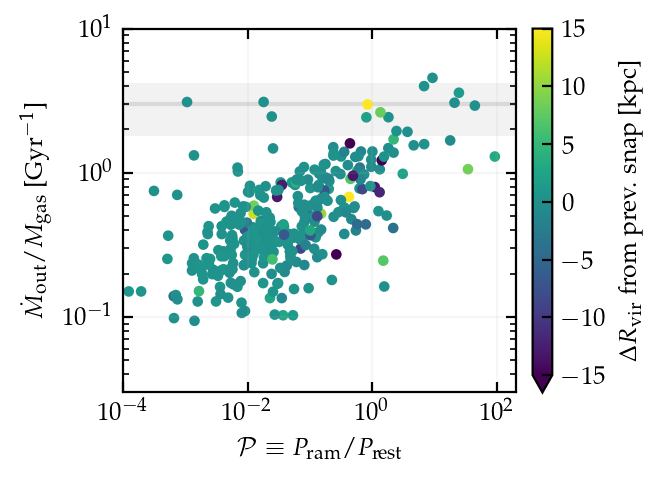

In [50]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=True)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05], figure=fig)
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])
for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    s = np.array(d.satRvir)
    d = d.sort_values('t')
    s_diff = s[1:]-s[:-1]       
    if (any(s_diff > 10)) or (any(s_diff < -10)):
        print(key)
    
    s_diff = np.append(s_diff, [np.nan])
    im = ax.scatter(d.ratio, d.Mdot_expelled_by_Mgas, s=8, c=s_diff, norm=mpl.colors.Normalize(vmax=15, vmin=-15))

    
ax.set_ylabel(r'$\dot{M}_{\rm out}/M_{\rm gas}$ [Gyr$^{-1}$]')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.loglog()
ax.set_xlim(1e-4, 2e2)
ax.set_ylim(3e-2, 1e1)
ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)

fig.colorbar(im, cax=cax, label=r'$\Delta R_{\rm vir}$ from prev. snap [kpc]', extend='min')

# plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
# plt.savefig('plots/Mdot_Pram.pdf')
plt.show()

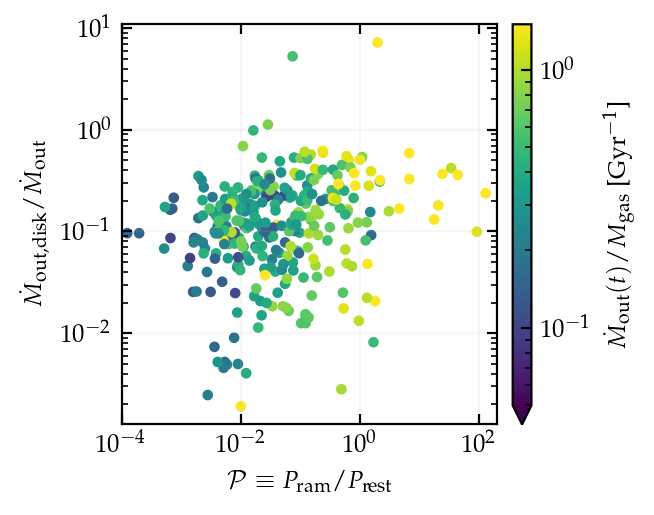

In [5]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05])
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])

im = ax.scatter(data_all.ratio, data_all.M_expelled_disk/data_all.M_expelled, s=8, 
                c=data_all.Mdot_expelled_by_Mgas, norm=mpl.colors.LogNorm(vmax=1.5, vmin=5e-2))
# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm out,disk}/\dot{M}_{\rm out}$')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.loglog()
ax.set_xlim(1e-4, 2e2)
# ax.set_ylim(1e-2, 5)
# ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
# ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)

fig.colorbar(im, cax=cax, label=r'$\dot{M}_{\rm out}(t)/M_{\rm gas}$ [Gyr$^{-1}$]', extend='min')

plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
# plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

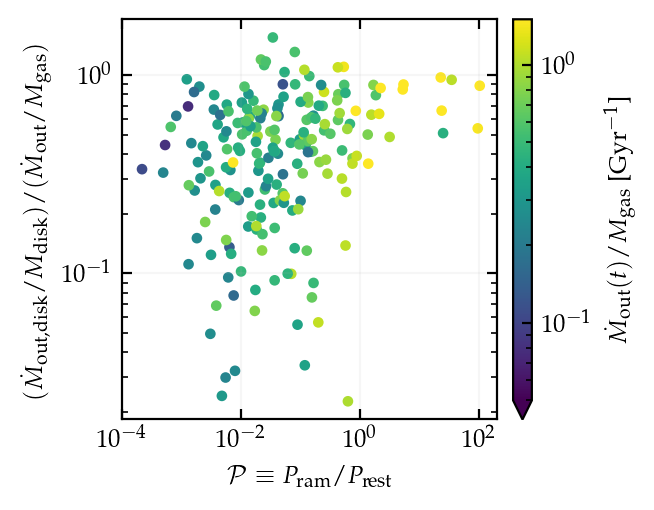

In [5]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05])
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])

im = ax.scatter(data_all.ratio, (data_all.Mdot_expelled_disk/data_all.Mdisk_div)/(data_all.Mdot_expelled/data_all.Mgas_div), s=8, 
                c=data_all.Mdot_expelled_by_Mgas, norm=mpl.colors.LogNorm(vmax=1.5, vmin=5e-2))
# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$(\dot{M}_{\rm out,disk}/M_{\rm disk})/(\dot{M}_{\rm out}/M_{\rm gas})$')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.loglog()
ax.set_xlim(1e-4, 2e2)
# ax.set_ylim(1e-2, 5)
# ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
# ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)

fig.colorbar(im, cax=cax, label=r'$\dot{M}_{\rm out}(t)/M_{\rm gas}$ [Gyr$^{-1}$]', extend='min')

plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
# plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

In [8]:
data_all.keys()

Index(['t', 'a', 'h1dist', 'dNN', 'M_star', 'M_gas', 'satRvir', 'hostRvir',
       'vel_CGM', 'rho_CGM', 'Pram', 'n_CGM', 'vel_CGM_adv', 'rho_CGM_adv',
       'std_vel_CGM', 'std_rho_CGM', 'Pram_adv', 'Prest', 'SigmaGas', 'dphidz',
       'SFR', 'sSFR', 'ratio', 'ratio_prev', 'dt', 'tau', 'tquench',
       'Mgas_div', 'time_x', 'M_SNeaff', 'time_y', 'M_disk', 'Mdisk_div',
       'time_x', 'M_expelled', 'Mdot_expelled', 'Mdot_expelled_by_Mgas',
       'time_y', 'M_expelled_disk', 'Mdot_expelled_disk',
       'Mdot_expelled_disk_by_Mgas', 'Mdot_expelled_disk_by_Mdisk', 'time_x',
       'M_expelled_th30', 'Mdot_expelled_th30', 'Mdot_expelled_th30_by_Mgas',
       'time_y', 'M_accreted', 'Mdot_accreted', 'Mdot_accreted_by_Mgas',
       'time', 'M_accreted_disk', 'Mdot_accreted_disk',
       'Mdot_accreted_disk_by_Mgas', 'Mdot_accreted_disk_by_Mdisk', 'Mdot_gas',
       'Mdot_disk', 'key', 'f_gas'],
      dtype='object')

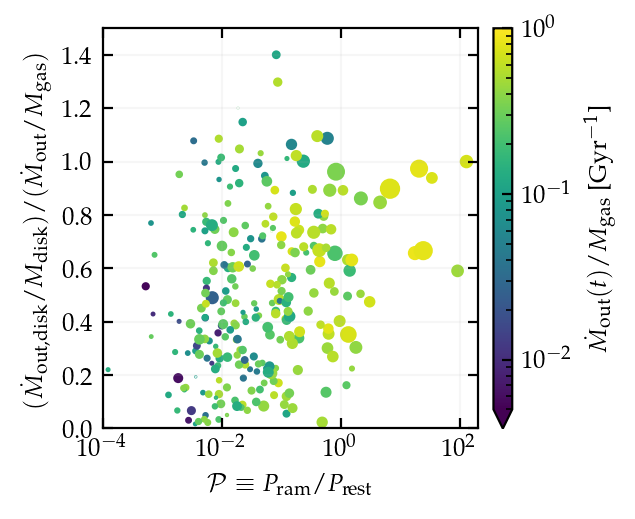

In [11]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05])
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])

im = ax.scatter(data_all.ratio, (data_all.Mdot_expelled_disk/data_all.Mdisk_div)/(data_all.Mdot_expelled/data_all.Mgas_div), 
                c=data_all.Mdot_expelled_th30/data_all.Mdot_expelled, norm=mpl.colors.LogNorm(vmax=1, vmin=5e-3), s=10*np.abs(data_all.Mdot_gas)/data_all.Mgas_div)
# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$(\dot{M}_{\rm out,disk}/M_{\rm disk})/(\dot{M}_{\rm out}/M_{\rm gas})$')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.semilogx()
ax.set_xlim(1e-4, 2e2)
ax.set_ylim(0, 1.5)
# ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
# ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)

fig.colorbar(im, cax=cax, label=r'$\dot{M}_{\rm out}(t)/M_{\rm gas}$ [Gyr$^{-1}$]', extend='min')

plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
# plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

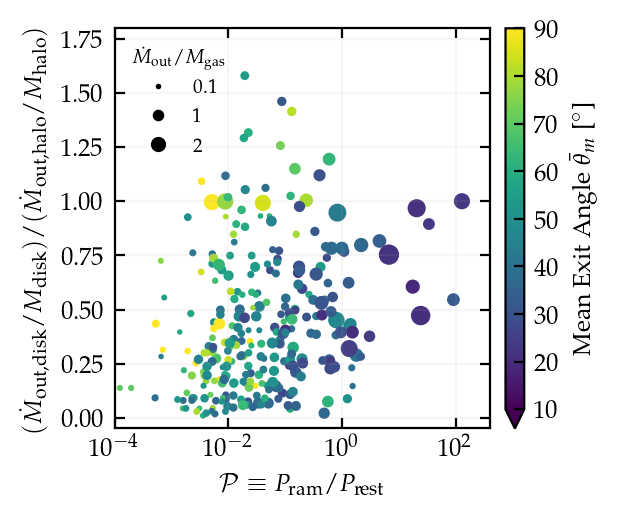

In [51]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05])
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])

from copy import copy
vmin, vmax = 10, 90
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)


x = data_all.ratio
y = data_all.Mdot_expelled_disk_by_Mdisk/data_all.Mdot_expelled_halo_by_Mhalo
cond = ~np.isnan(data_all.Mdot_expelled_by_Mgas) & ~np.isinf(data_all.Mdot_expelled_by_Mgas)

im = ax.scatter(x[cond], y[cond], 
                c=data_all.theta_mean[cond], norm=norm, s=10*data_all.Mdot_expelled_by_Mgas[cond])

outliers = (y > 1) & (x > 1e-2) & (x < 1)
# ax.scatter(x[outliers], y[outliers], c='r', s=3)


# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$(\dot{M}_{\rm out,disk}/M_{\rm disk})/(\dot{M}_{\rm out,halo}/M_{\rm halo})$')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.semilogx()
ax.set_xlim(1e-4, 4e2)
ax.set_ylim(-0.05, 1.8)
# ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
# ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)
leg = ax.legend(im.legend_elements("sizes", num=[1, 10, 20])[0], ['0.1', '1', '2'], fontsize=7, title=r'$\dot{M}_{\rm out}/M_{\rm gas}$', loc='upper left')
leg.get_title().set_fontsize('7')

fig.colorbar(im, cax=cax, label=r'Mean Exit Angle $\bar{\theta}_m$ [$^\circ$]', extend='min')

plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
# plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

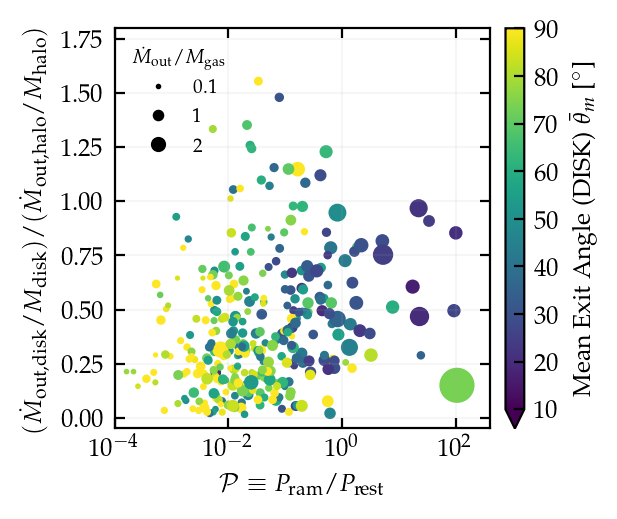

In [32]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05])
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])

from copy import copy
vmin, vmax = 10, 90
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)


x = data_all.ratio
y = data_all.Mdot_expelled_disk_by_Mdisk/data_all.Mdot_expelled_halo_by_Mhalo
cond = ~np.isnan(data_all.Mdot_expelled_by_Mgas) & ~np.isinf(data_all.Mdot_expelled_by_Mgas)

im = ax.scatter(x[cond], y[cond], 
                c=data_all.theta_mean_disk[cond], norm=norm, s=10*data_all.Mdot_expelled_by_Mgas[cond])

outliers = (y > 1) & (x > 1e-2) & (x < 1)
# ax.scatter(x[outliers], y[outliers], c='r', s=3)


# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$(\dot{M}_{\rm out,disk}/M_{\rm disk})/(\dot{M}_{\rm out,halo}/M_{\rm halo})$')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.semilogx()
ax.set_xlim(1e-4, 4e2)
ax.set_ylim(-0.05, 1.8)
# ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
# ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)
leg = ax.legend(im.legend_elements("sizes", num=[1, 10, 20])[0], ['0.1', '1', '2'], fontsize=7, title=r'$\dot{M}_{\rm out}/M_{\rm gas}$', loc='upper left')
leg.get_title().set_fontsize('7')

fig.colorbar(im, cax=cax, label=r'Mean Exit Angle (DISK) $\bar{\theta}_m$ [$^\circ$]', extend='min')

plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
# plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

In [33]:
data_all.keys()

Index(['t', 'a', 'h1dist', 'dNN', 'M_star', 'M_gas', 'satRvir', 'hostRvir',
       'vel_CGM', 'rho_CGM', 'Pram', 'n_CGM', 'vel_CGM_adv', 'rho_CGM_adv',
       'std_vel_CGM', 'std_rho_CGM', 'Pram_adv', 'Prest', 'SigmaGas_x',
       'dphidz', 'SFR', 'sSFR', 'ratio', 'ratio_prev', 'dt', 'tau', 'tquench',
       'Mgas_div', 'time_x', 'M_SNeaff', 'time_y', 'M_disk', 'Mdisk_div',
       'time_x', 'M_expelled', 'Mdot_expelled', 'Mdot_expelled_by_Mgas',
       'time_y', 'theta_mean', 'time_x', 'M_expelled_halo',
       'Mdot_expelled_halo', 'Mdot_expelled_halo_by_Mgas',
       'Mdot_expelled_halo_by_Mhalo', 'time_y', 'theta_mean_halo', 'time_x',
       'M_expelled_disk', 'Mdot_expelled_disk', 'Mdot_expelled_disk_by_Mgas',
       'Mdot_expelled_disk_by_Mdisk', 'time_y', 'theta_mean_disk', 'time_x',
       'M_expelled_th30', 'Mdot_expelled_th30', 'Mdot_expelled_th30_by_Mgas',
       'time_y', 'M_accreted', 'Mdot_accreted', 'Mdot_accreted_by_Mgas',
       'time_x', 'M_accreted_disk', 'Mdot_accret

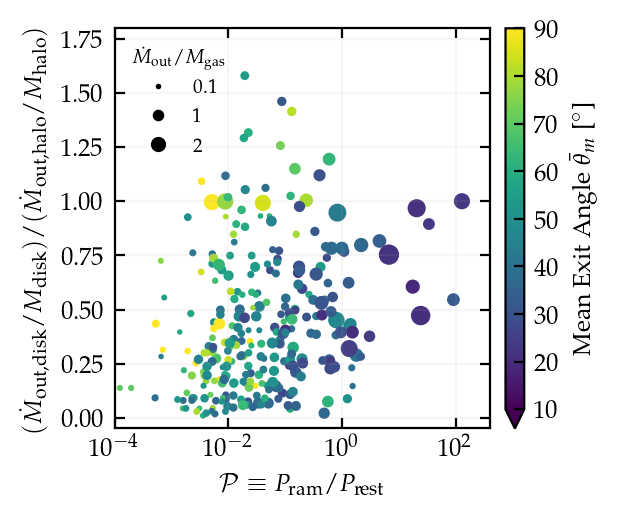

In [38]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05])
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])

from copy import copy
vmin, vmax = 10, 90
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)


x = data_all.ratio
y = data_all.Mdot_expelled_disk_by_Mdisk/data_all.Mdot_expelled_halo_by_Mhalo
cond = ~np.isnan(data_all.Mdot_expelled_by_Mgas) & ~np.isinf(data_all.Mdot_expelled_by_Mgas)

im = ax.scatter(x[cond], y[cond], 
                c=data_all.theta_mean[cond], norm=norm, s=10*data_all.Mdot_expelled_by_Mgas[cond])

outliers = (y > 1) & (x > 1e-2) & (x < 1)
# ax.scatter(x[outliers], y[outliers], c='r', s=3)


# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$(\dot{M}_{\rm out,disk}/M_{\rm disk})/(\dot{M}_{\rm out,halo}/M_{\rm halo})$')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.semilogx()
ax.set_xlim(1e-4, 4e2)
ax.set_ylim(-0.05, 1.8)
# ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
# ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)
leg = ax.legend(im.legend_elements("sizes", num=[1, 10, 20])[0], ['0.1', '1', '2'], fontsize=7, title=r'$\dot{M}_{\rm out}/M_{\rm gas}$', loc='upper left')
leg.get_title().set_fontsize('7')

fig.colorbar(im, cax=cax, label=r'Mean Exit Angle $\bar{\theta}_m$ [$^\circ$]', extend='min')

plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
# plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

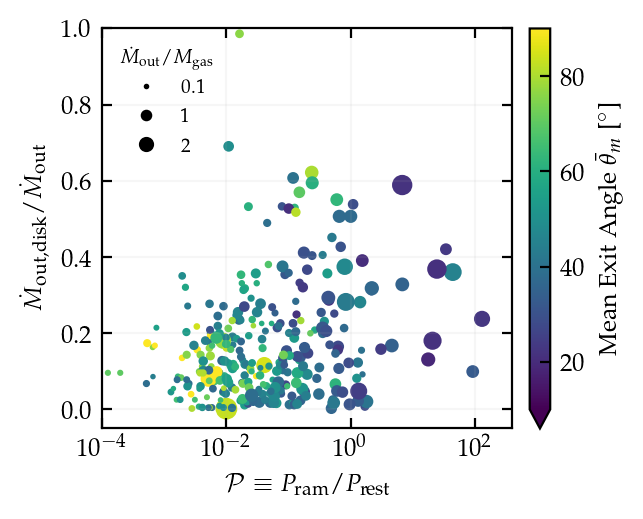

In [46]:
fig = plt.figure(dpi=200, figsize=(3.2,2.5), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05])
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])

from copy import copy
vmin, vmax = 10, 90
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)


x = data_all.ratio
y = data_all.Mdot_expelled_disk/data_all.Mdot_expelled
cond = ~np.isnan(data_all.Mdot_expelled_by_Mgas) & ~np.isinf(data_all.Mdot_expelled_by_Mgas)

im = ax.scatter(x[cond], y[cond], 
                c=data_all.theta_mean[cond], norm=norm, s=10*data_all.Mdot_expelled_by_Mgas[cond])

outliers = (y > 1) & (x > 1e-2) & (x < 1)
# ax.scatter(x[outliers], y[outliers], c='r', s=3)

# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm out,disk}/\dot{M}_{\rm out}$')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.semilogx()
ax.set_xlim(1e-4, 4e2)
ax.set_ylim(-0.05, 1)
# ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
# ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)
leg = ax.legend(im.legend_elements("sizes", num=[1, 10, 20])[0], ['0.1', '1', '2'], fontsize=7, title=r'$\dot{M}_{\rm out}/M_{\rm gas}$', loc='upper left')
leg.get_title().set_fontsize('7')

fig.colorbar(im, cax=cax, label=r'Mean Exit Angle $\bar{\theta}_m$ [$^\circ$]', extend='min')

plt.subplots_adjust(left=0.15, top=0.97, right=0.85, bottom=0.17, hspace=0.05, wspace=0.08)
plt.savefig('plots/Mout_disk_Pram.pdf')
plt.show()

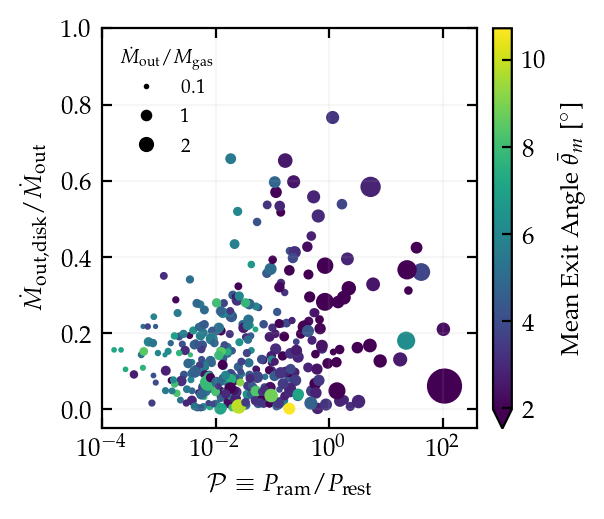

In [172]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05])
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])

from copy import copy
vmin, vmax = 10, 90
norm = mpl.colors.Normalize()


x = data_all.ratio
y = data_all.Mdot_expelled_disk/data_all.Mdot_expelled
cond = ~np.isnan(data_all.Mdot_expelled_by_Mgas) & ~np.isinf(data_all.Mdot_expelled_by_Mgas)

im = ax.scatter(x[cond], y[cond], 
                c=data_all.dNN[cond]/data_all.satRvir[cond], norm=norm, s=10*data_all.Mdot_expelled_by_Mgas[cond])

outliers = (y > 1) & (x > 1e-2) & (x < 1)
# ax.scatter(x[outliers], y[outliers], c='r', s=3)


# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm out,disk}/\dot{M}_{\rm out}$')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.semilogx()
ax.set_xlim(1e-4, 4e2)
ax.set_ylim(-0.05, 1)
# ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
# ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)
leg = ax.legend(im.legend_elements("sizes", num=[1, 10, 20])[0], ['0.1', '1', '2'], fontsize=7, title=r'$\dot{M}_{\rm out}/M_{\rm gas}$', loc='upper left')
leg.get_title().set_fontsize('7')

fig.colorbar(im, cax=cax, label=r'Mean Exit Angle $\bar{\theta}_m$ [$^\circ$]', extend='min')

plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
# plt.savefig('plots/Mout_disk_Pram.pdf')
plt.show()

In [174]:
timesteps = read_timesteps('h148')
ts = timesteps[timesteps.z0haloid==329]
ts.keys()

Index(['time', 't', 'z', 'a', 'haloid', 'z0haloid', 'mstar', 'mgas', 'mass',
       'Rvir', 'gas_rho', 'gas_temp', 'gas_mass', 'gas_r', 'gas_hi',
       'gas_rho_sphere', 'gas_temp_sphere', 'gas_mass_sphere', 'gas_r_sphere',
       'x', 'y', 'sfr', 'Pram', 'Prest', 'v_halo', 'v_halo1', 'v_env',
       'env_rho', 'ratio', 'h1dist', 'h1dist_kpc', 'h1rvir', 'gasfrac',
       'SNHfrac', 'mHI', 'fHI', 'HIratio', 'gtemp', 'inflow_23', 'outflow_23',
       'inflow_temp_23', 'outflow_temp_23', 'inflow_91', 'outflow_91',
       'inflow_temp_91', 'outflow_temp_91'],
      dtype='object')

In [186]:
np.unique(timesteps.z0haloid)

array([   2.,    3.,    5.,    6.,    9.,   10.,   11.,   13.,   14.,
         21.,   24.,   27.,   28.,   30.,   32.,   36.,   37.,   41.,
         45.,   47.,   48.,   58.,   61.,   65.,   68.,   80.,   81.,
         96.,  105.,  119.,  127.,  128.,  136.,  163.,  212.,  265.,
        278.,  283.,  329.,  372.,  377.,  384.,  386.,  442.,  491.,
        620.,  678.,  699.,  759.,  914., 1004.])

In [182]:
ts1 = timesteps[timesteps.z0haloid==1]

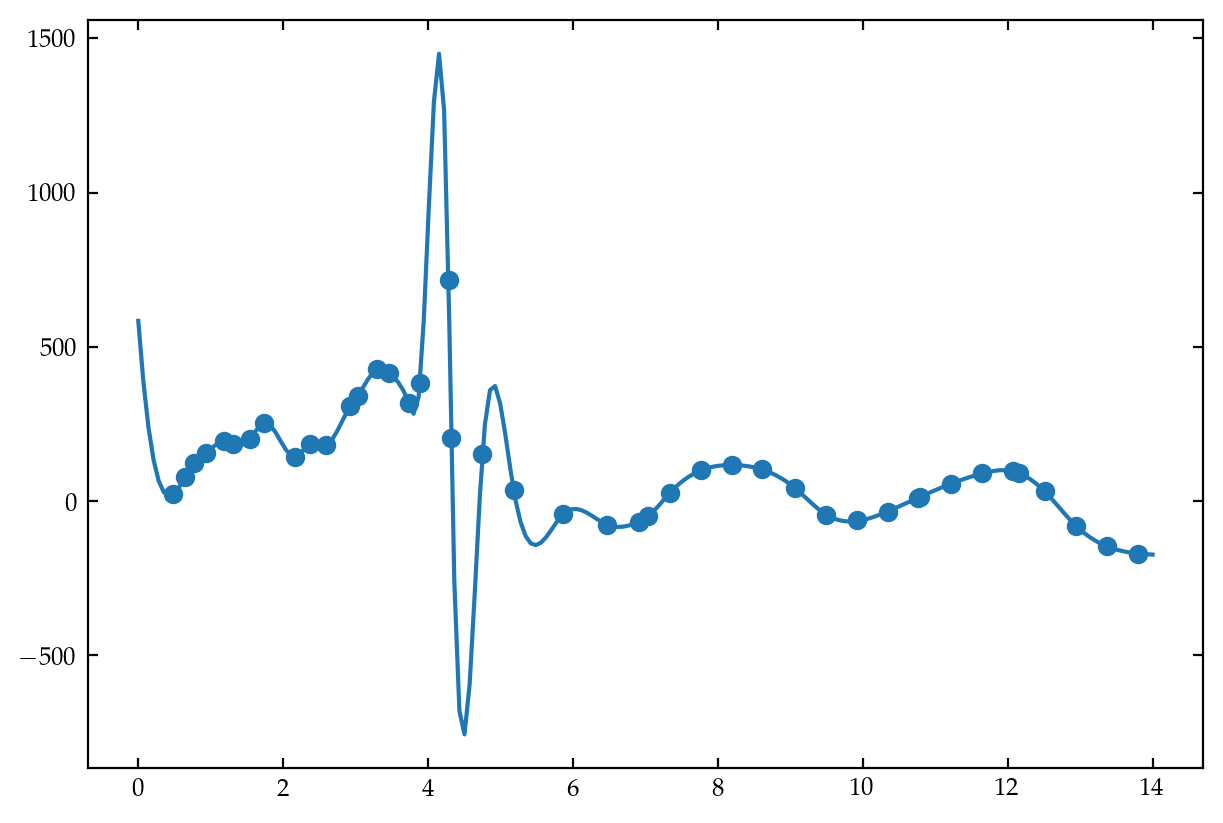

In [193]:
from scipy.interpolate import UnivariateSpline

tnew = np.linspace(0, 14,200)

s = UnivariateSpline(np.flip(ts.t), np.flip(ts.x))
xnew = s(tnew)
s = UnivariateSpline(np.flip(ts.t), np.flip(ts.y))
ynew = s(tnew)
s = UnivariateSpline(np.flip(ts.t), np.flip(ts.z))
znew = s(tnew)


# s = UnivariateSpline(np.flip(ts1.t), np.flip(ts1.x))
# xnew1 = s(tnew)
# s = UnivariateSpline(np.flip(ts1.t), np.flip(ts1.y))
# ynew1 = s(tnew)
# s = UnivariateSpline(np.flip(ts1.t), np.flip(ts1.z))
# znew1 = s(tnew)

# h1dist = np.sqrt((xnew-xnew1)**2 + (ynew-ynew1)**2 + (znew-znew1)**2)
plt.scatter(ts.t, ts.y)
plt.plot(tnew, ynew)

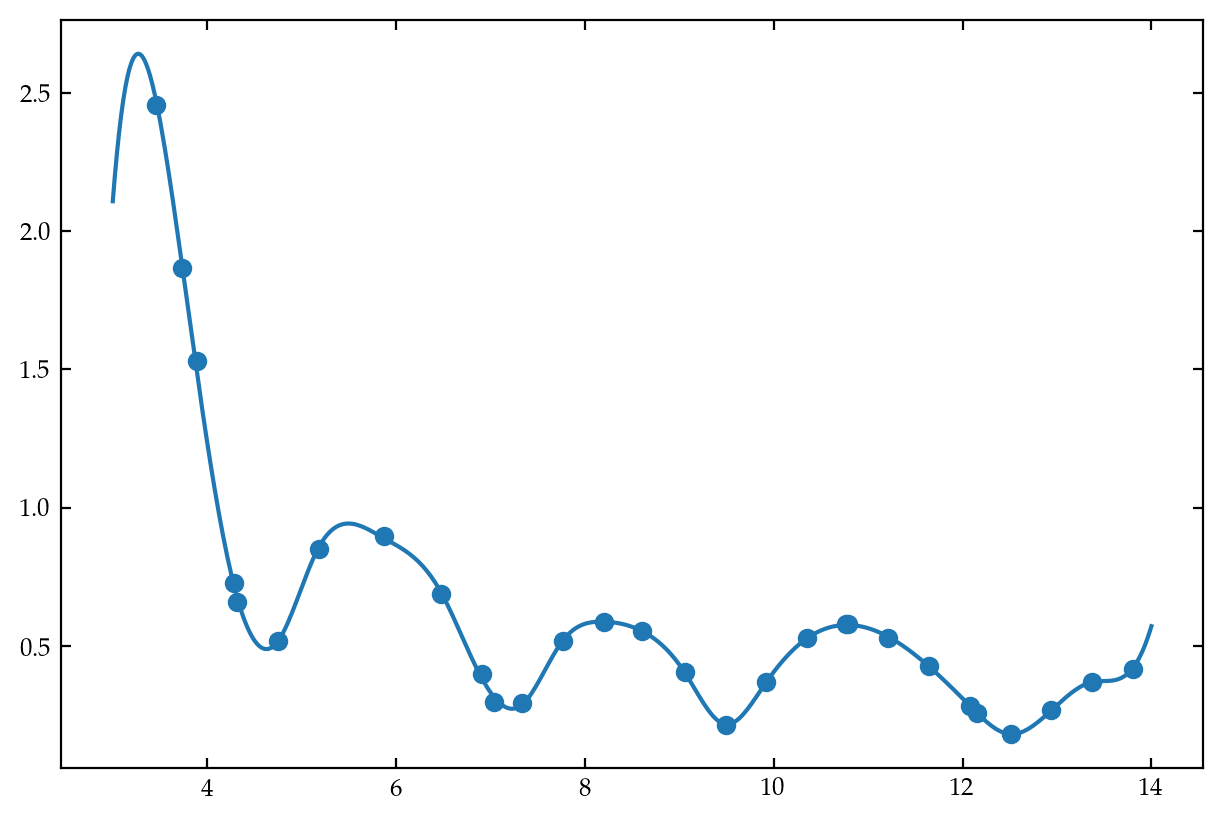

In [219]:
tnew = np.linspace(3,14,500)
x, y1 = np.array(d.t), np.array(d.h1dist)
s = UnivariateSpline(x, y1)
distnew = s(tnew)

x, y2 = np.array(d.t), np.array(d.hostRvir)
s = UnivariateSpline(x, y2)
hostRvirnew = s(tnew)


plt.scatter(x, y1/y2)
plt.plot(tnew, distnew/hostRvirnew)

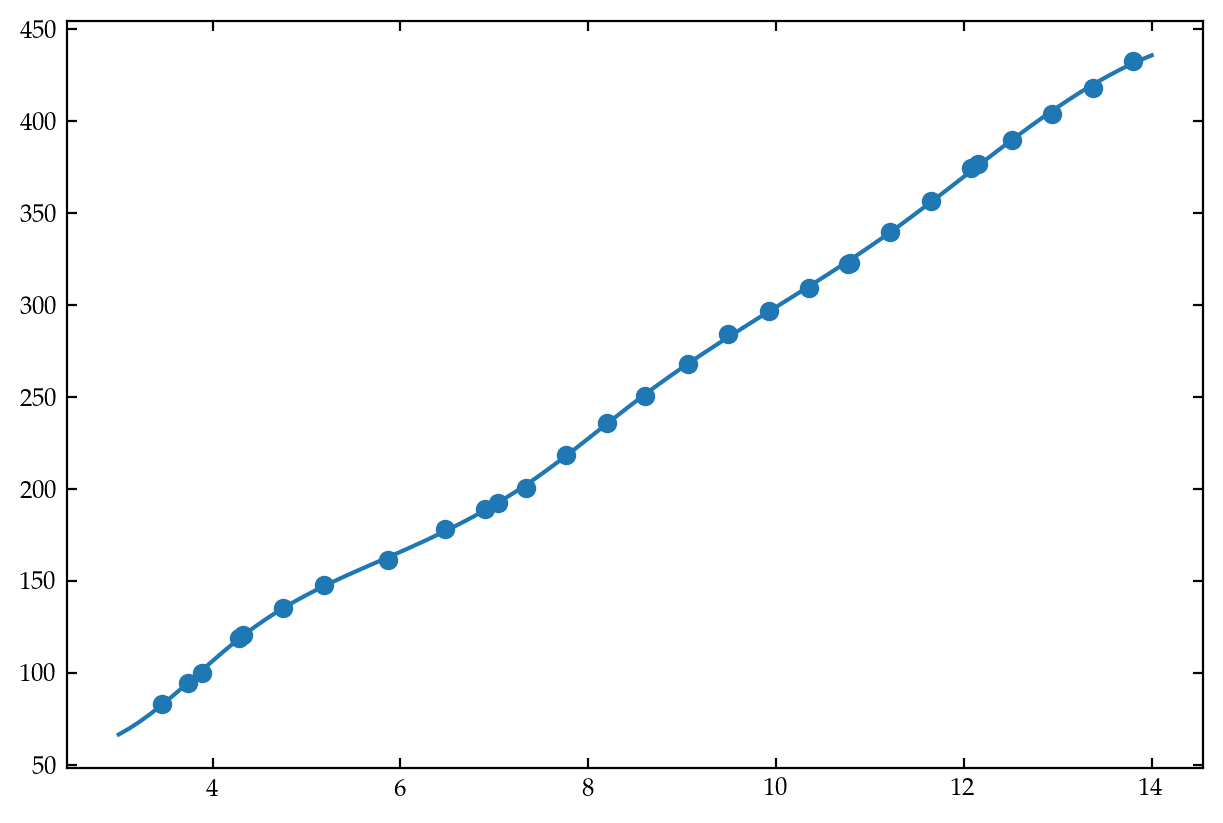

In [217]:
plt.scatter(d.t, d.hostRvir)
plt.plot(tnew,hostRvirnew)

In [209]:
UnivariateSpline?

Init signature:
UnivariateSpline(
    x,
    y,
    w=None,
    bbox=[None, None],
    k=3,
    s=None,
    ext=0,
    check_finite=False,
)
Docstring:     
1-D smoothing spline fit to a given set of data points.

Fits a spline y = spl(x) of degree `k` to the provided `x`, `y` data.  `s`
specifies the number of knots by specifying a smoothing condition.

Parameters
----------
x : (N,) array_like
    1-D array of independent input data. Must be increasing;
    must be strictly increasing if `s` is 0.
y : (N,) array_like
    1-D array of dependent input data, of the same length as `x`.
w : (N,) array_like, optional
    Weights for spline fitting.  Must be positive.  If None (default),
    weights are all equal.
bbox : (2,) array_like, optional
    2-sequence specifying the boundary of the approximation interval. If
    None (default), ``bbox=[x[0], x[-1]]``.
k : int, optional
    Degree of the smoothing spline.  Must be 1 <= `k` <= 5.
    Default is `k` = 3, a cubic spline.
s : float or 

In [185]:
ts1

Empty DataFrame
Columns: [time, t, z, a, haloid, z0haloid, mstar, mgas, mass, Rvir, gas_rho, gas_temp, gas_mass, gas_r, gas_hi, gas_rho_sphere, gas_temp_sphere, gas_mass_sphere, gas_r_sphere, x, y, sfr, Pram, Prest, v_halo, v_halo1, v_env, env_rho, ratio, h1dist, h1dist_kpc, h1rvir, gasfrac, SNHfrac, mHI, fHI, HIratio, gtemp, inflow_23, outflow_23, inflow_temp_23, outflow_temp_23, inflow_91, outflow_91, inflow_temp_91, outflow_temp_91]
Index: []

[0 rows x 46 columns]

/Users/hollis/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:144: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/hollis/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:2032: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[0, 1] *= sx
/Users/hollis/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:2033: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[0, 2] *= sx
/Users/hollis/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:2034: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 0] *= sy
/Users/hollis/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:2036: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] *= sy


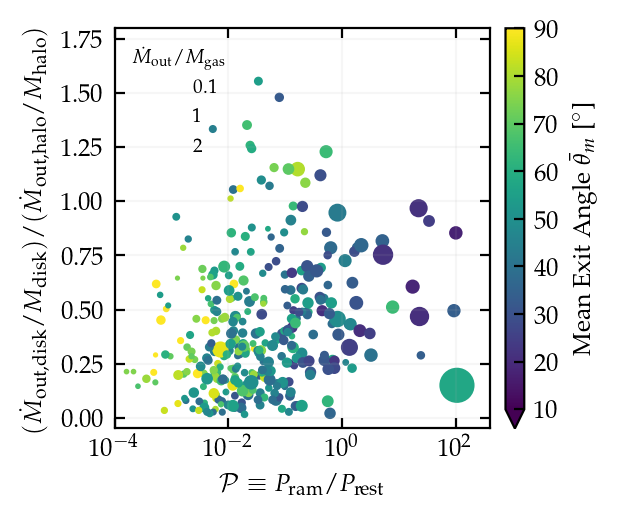

In [107]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05])
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])

from copy import copy
vmin, vmax = 10, 90
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)


x = data_all.ratio
y = data_all.Mdot_expelled_disk_by_Mdisk/data_all.Mdot_expelled_halo_by_Mhalo
cond = ~np.isnan(data_all.Mdot_expelled_by_Mgas)

im = ax.scatter(x[cond], y[cond], 
                c=data_all.theta_mean[cond], norm=norm, s=10*data_all.Mdot_expelled_by_Mgas[cond])

# outliers = (y > 1) & (x > 1e-2) & (x < 1)
# ax.scatter(x[outliers], y[outliers], c='r', s=3)


# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$(\dot{M}_{\rm out,disk}/M_{\rm disk})/(\dot{M}_{\rm out,halo}/M_{\rm halo})$')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.semilogx()
ax.set_xlim(1e-4, 4e2)
ax.set_ylim(-0.05, 1.8)
# ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
# ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)
leg = ax.legend(im.legend_elements("sizes", num=[1, 10, 20])[0], ['0.1', '1', '2'], fontsize=7, title=r'$\dot{M}_{\rm out}/M_{\rm gas}$', loc='upper left')
leg.get_title().set_fontsize('7')

fig.colorbar(im, cax=cax, label=r'Mean Exit Angle $\bar{\theta}_m$ [$^\circ$]', extend='min')

plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
# plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

[]

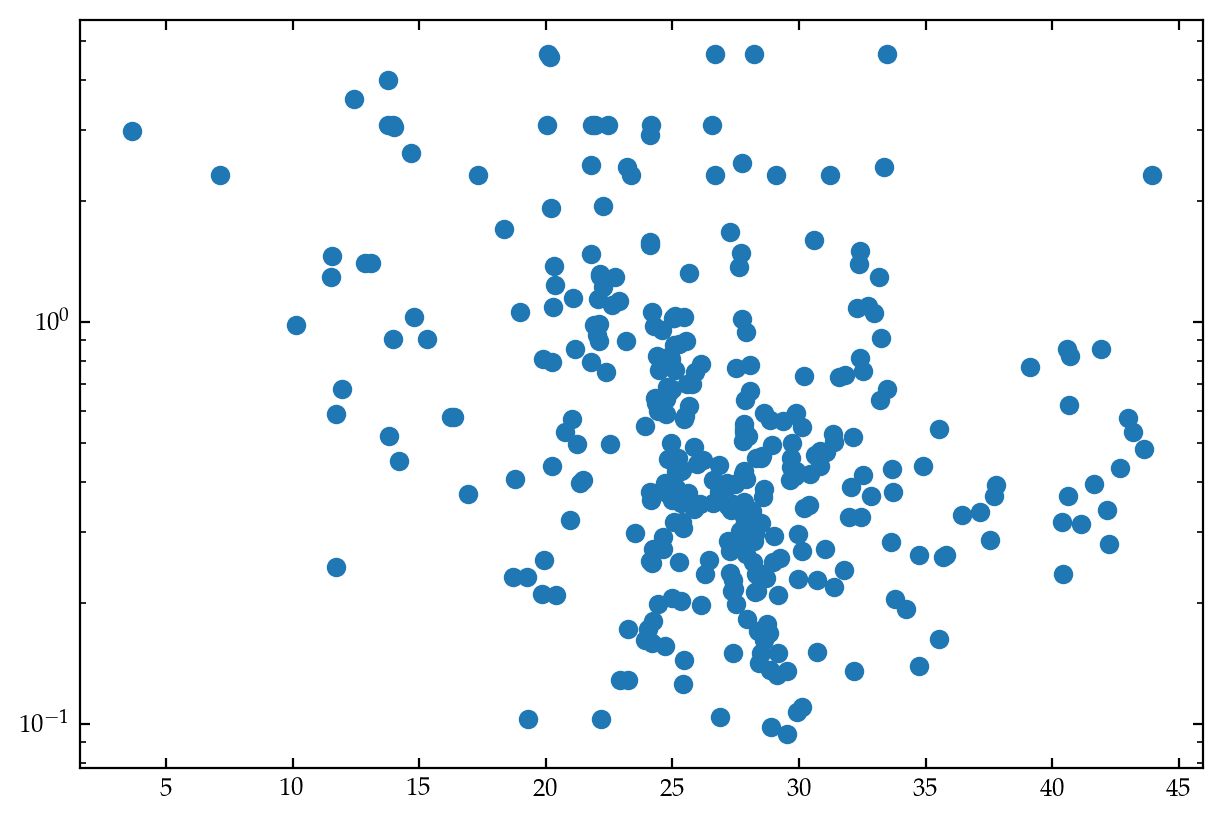

In [18]:
plt.scatter(data_all.satRvir, data_all.Mdot_expelled_by_Mgas)
plt.semilogy()

In [116]:
data_all[(x > 99)&(y < 0.25)&cond]

4    h148_329
Name: key, dtype: object

In [5]:
data_all = read_all_ram_pressure()

1 Returning (expelled, accreted) for h148-13...
2 Returning (expelled, accreted) for h148-28...
3 Returning (expelled, accreted) for h148-37...
4 Returning (expelled, accreted) for h148-45...
5 Returning (expelled, accreted) for h148-68...
6 Returning (expelled, accreted) for h148-80...
7 Returning (expelled, accreted) for h148-283...
8 Returning (expelled, accreted) for h148-278...
9 Returning (expelled, accreted) for h148-329...
10 Returning (expelled, accreted) for h229-20...
11 Returning (expelled, accreted) for h229-22...
12 Returning (expelled, accreted) for h229-23...
13 Returning (expelled, accreted) for h229-27...
14 Returning (expelled, accreted) for h229-55...
15 Returning (expelled, accreted) for h242-24...
16 Returning (expelled, accreted) for h242-41...
17 Returning (expelled, accreted) for h242-80...
18 Returning (expelled, accreted) for h329-33...
19 Returning (expelled, accreted) for h329-137...


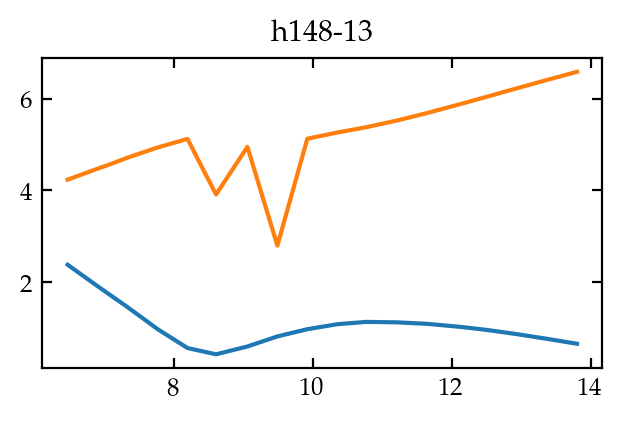

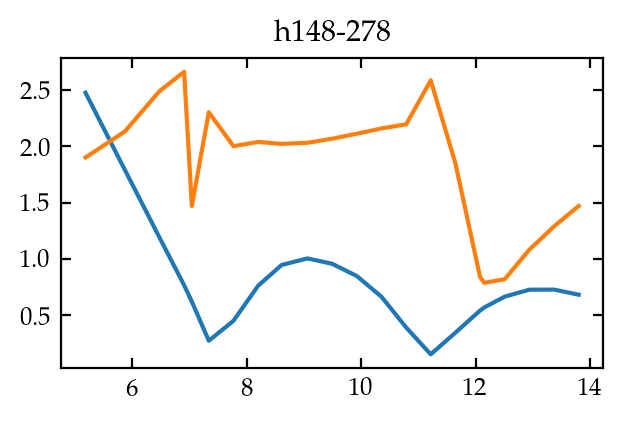

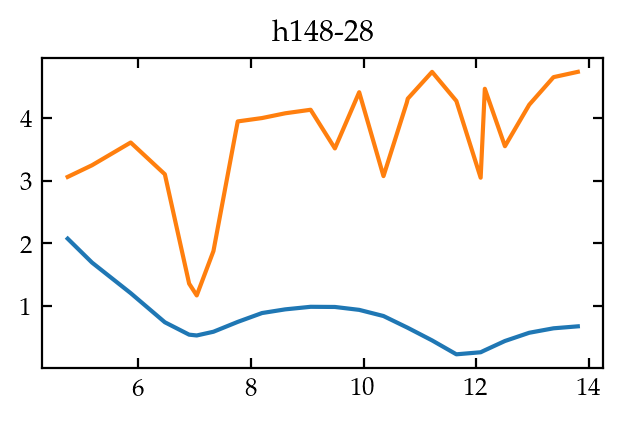

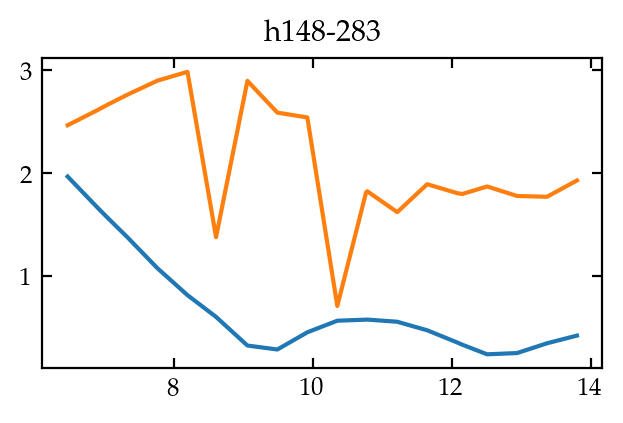

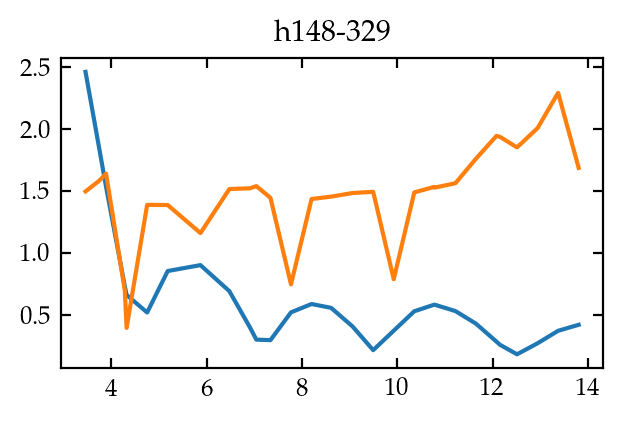

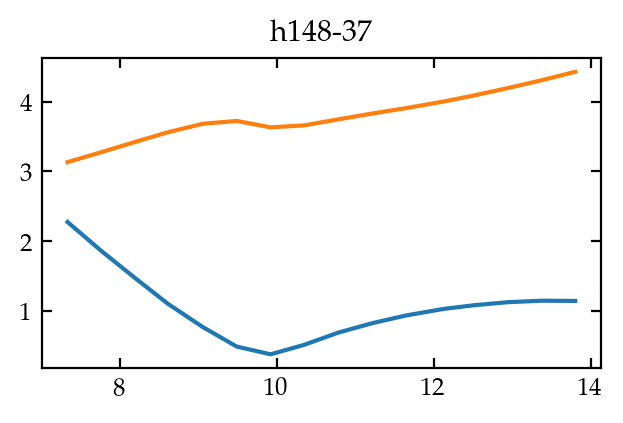

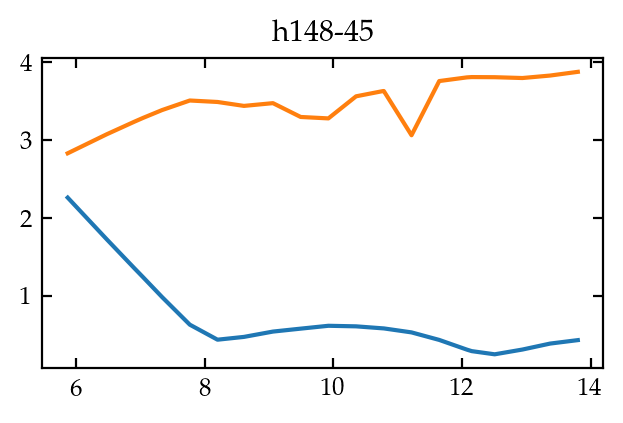

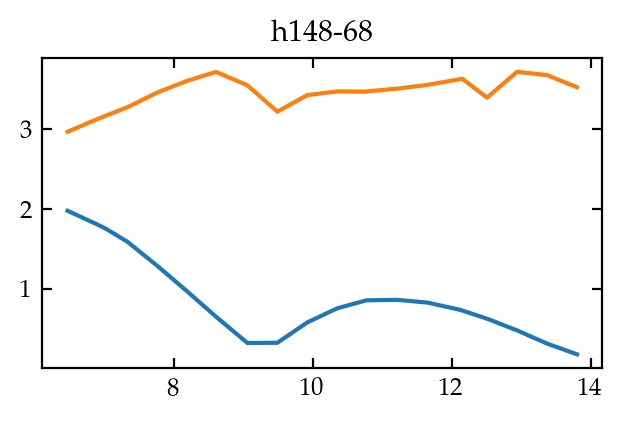

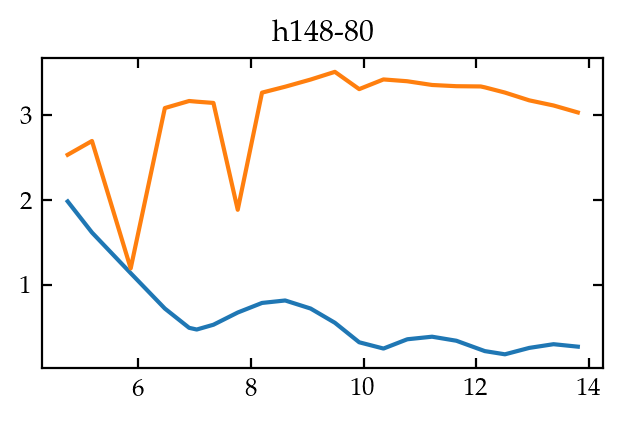

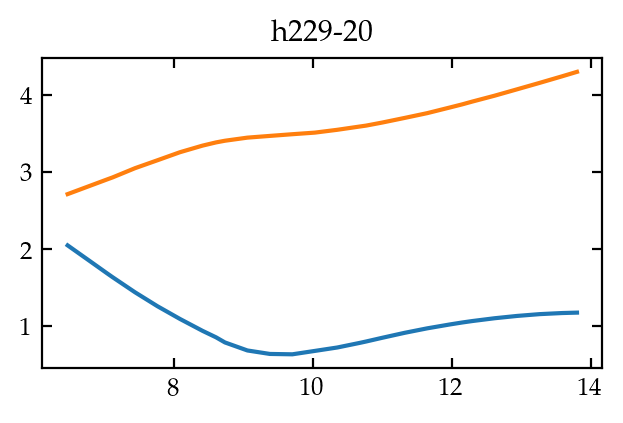

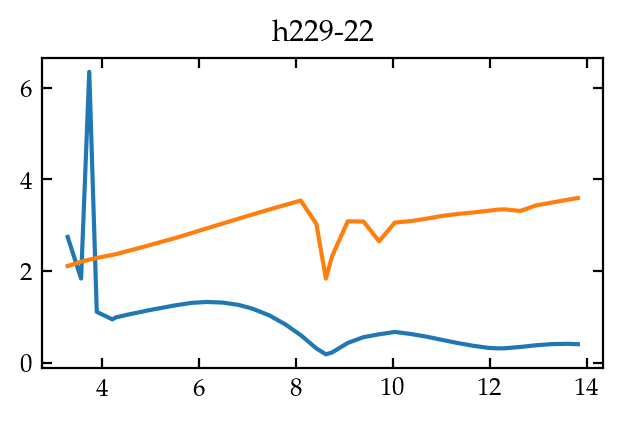

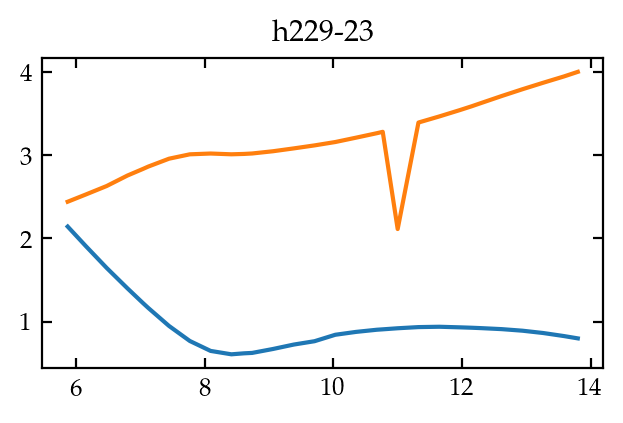

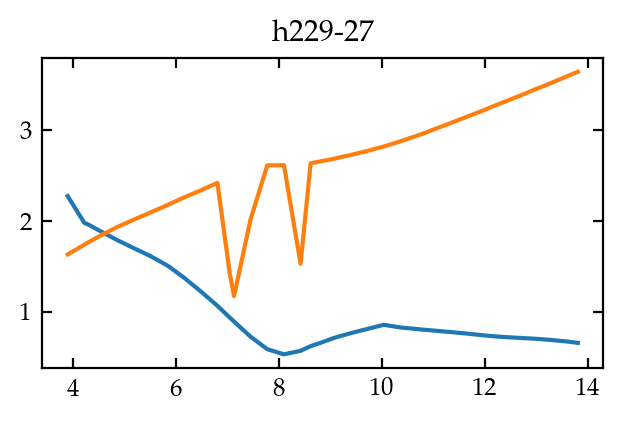

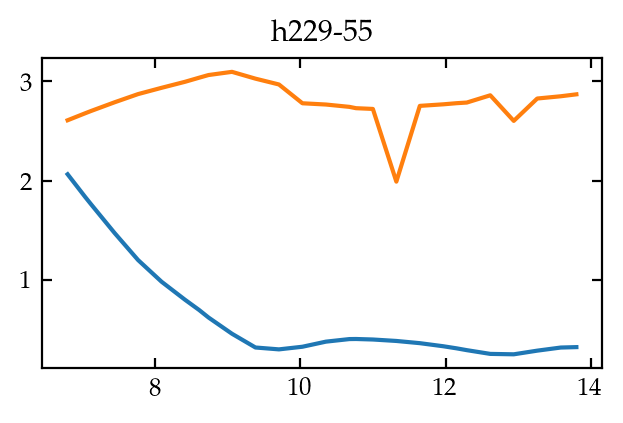

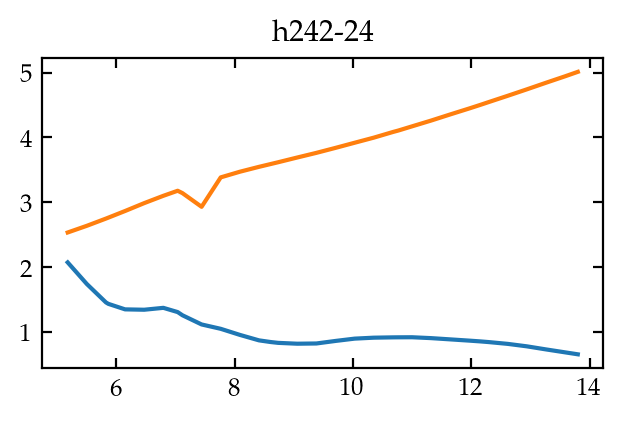

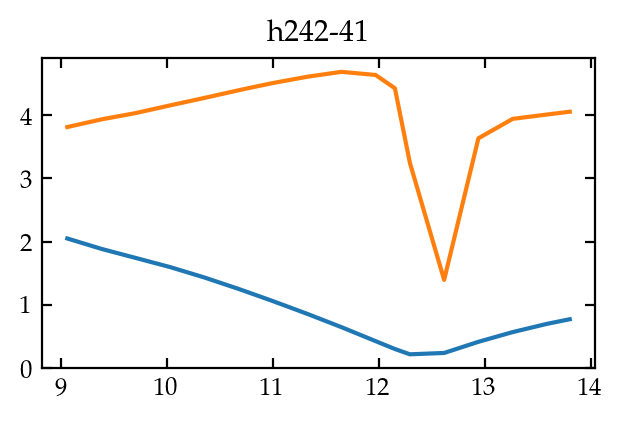

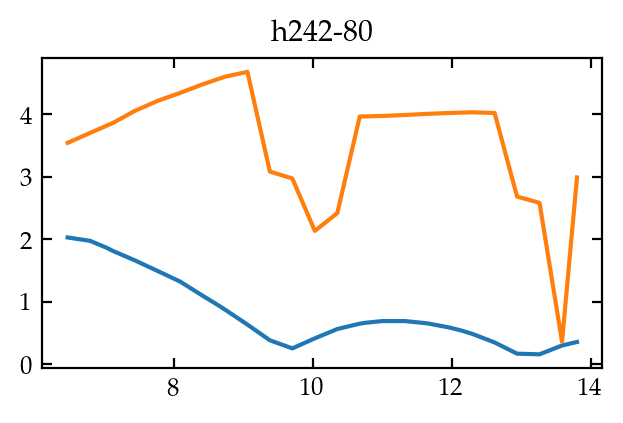

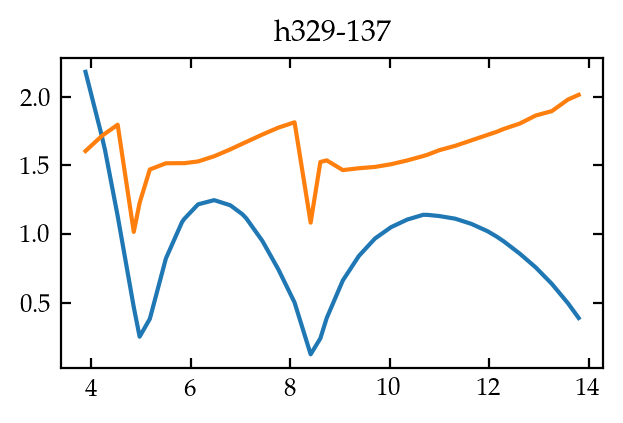

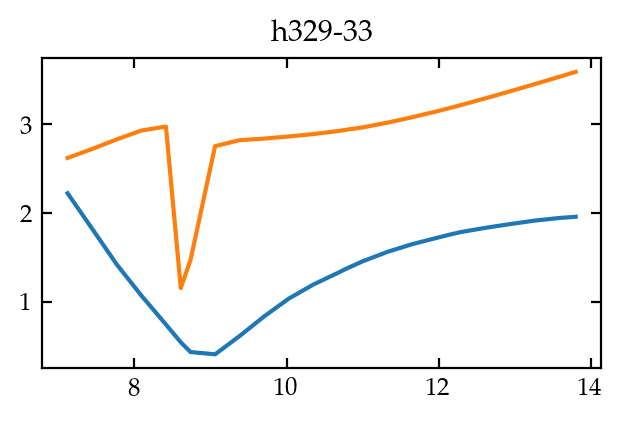

In [6]:
for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    plt.figure(dpi=200, figsize=(3,2))
    plt.title(key.replace('_','-'))
    plt.plot(d.t, d.h1dist/d.hostRvir)
    plt.plot(d.t, d.satRvir/10)
    plt.show()

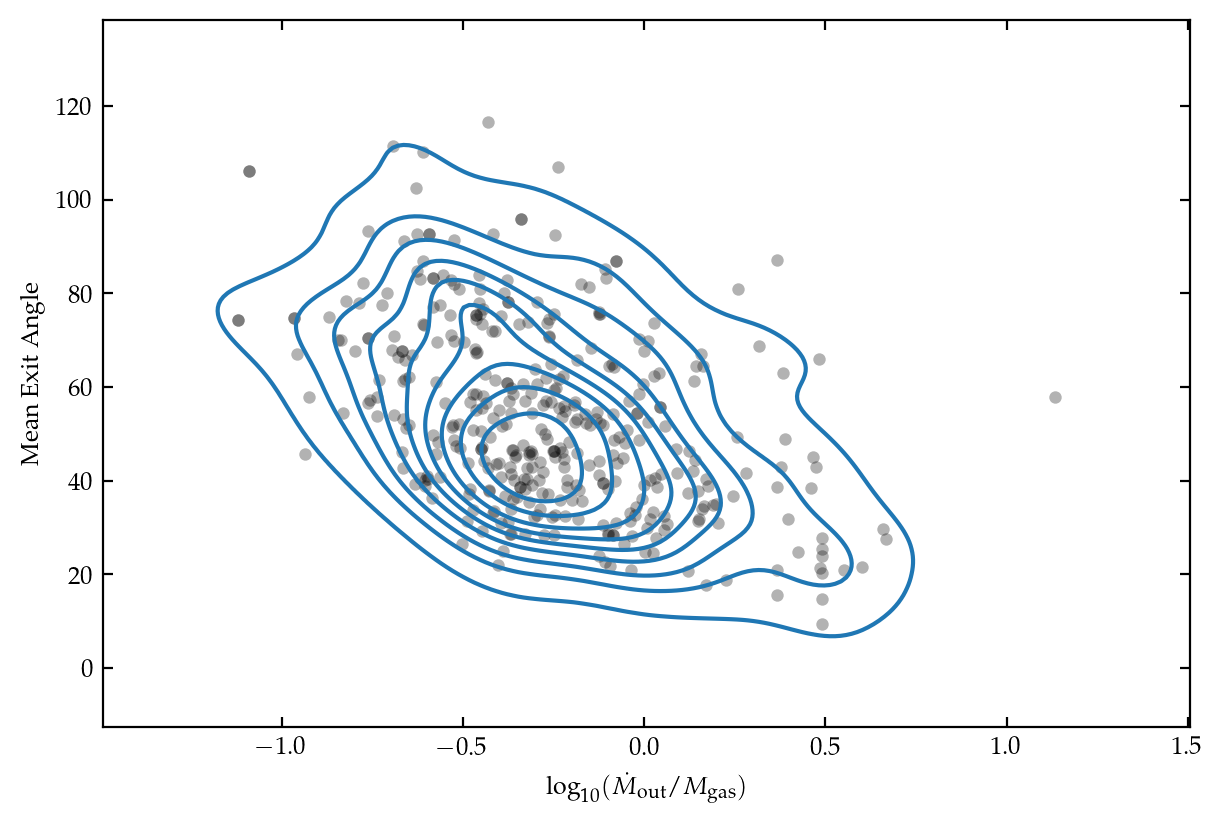

In [152]:
import seaborn as sns
fig, ax = plt.subplots(1,1)

data = data_all[(~np.isinf(data_all.Mdot_expelled_by_Mgas))&(~np.isnan(data_all.Mdot_expelled_by_Mgas))]

x, y = np.log10(data.Mdot_expelled_by_Mgas), data.theta_mean
ax.scatter(x, y, c='k', linewidths=0, s=20, alpha=0.3)
sns.kdeplot(x, y=y, ax=ax)
ax.set_xlabel(r'$\log_{10}(\dot{M}_{\rm out}/M_{\rm gas})$')
ax.set_ylabel('Mean Exit Angle')
plt.show()


In [ ]:
d[['t','Mdot_expelled_by_Mgas','theta_mean','ratio']]

In [1]:
from analysis import *

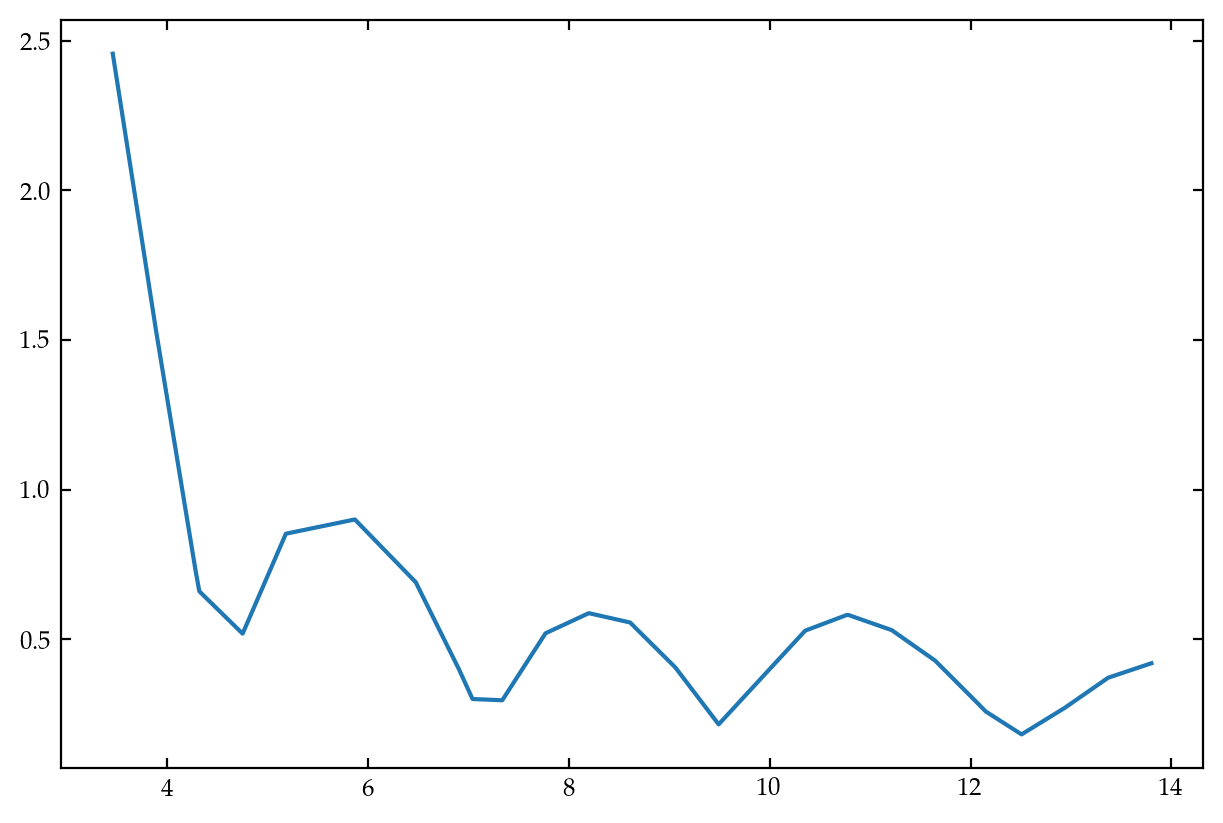

In [170]:
d = data_all[data_all.key=='h148_329']
# plt.plot(d.t, d.Mdot_expelled_by_Mgas)
plt.plot(d.t, d.h1dist/d.hostRvir)


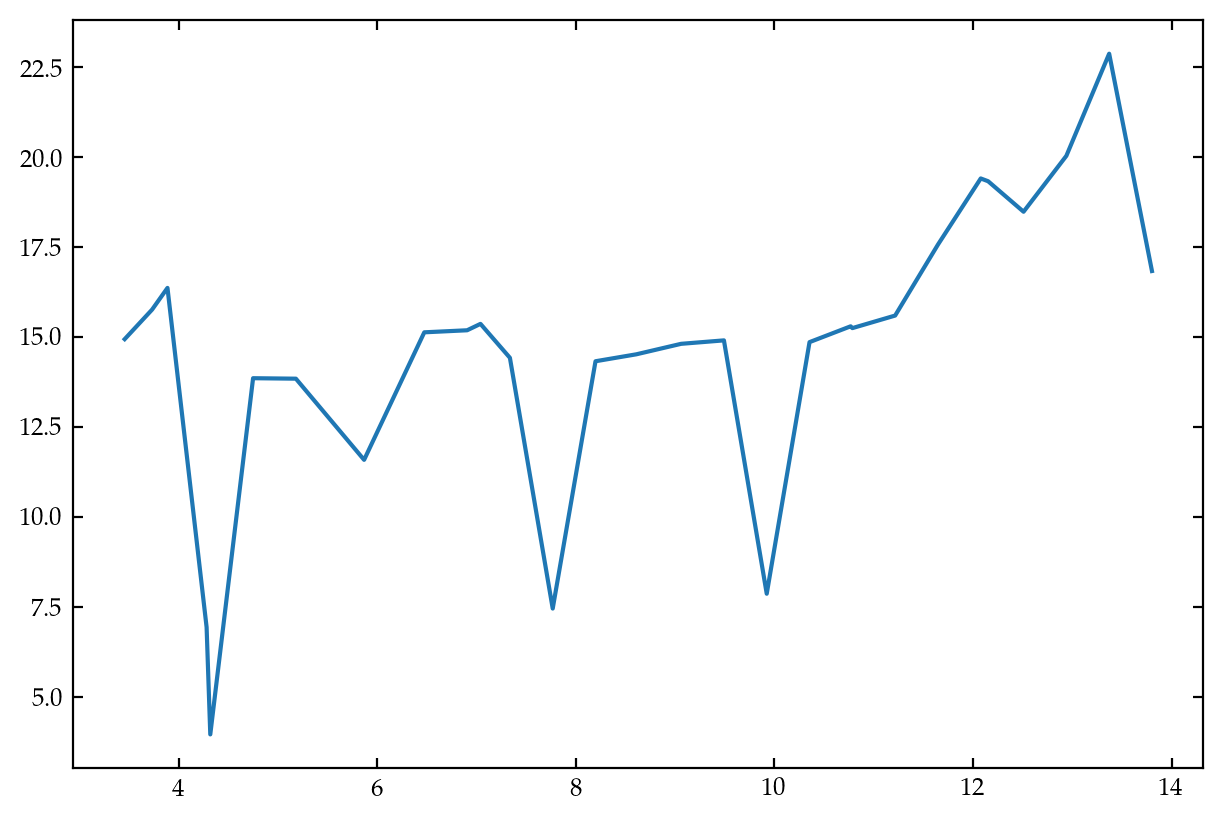

In [130]:
plt.plot(d.t, d.satRvir)

[]

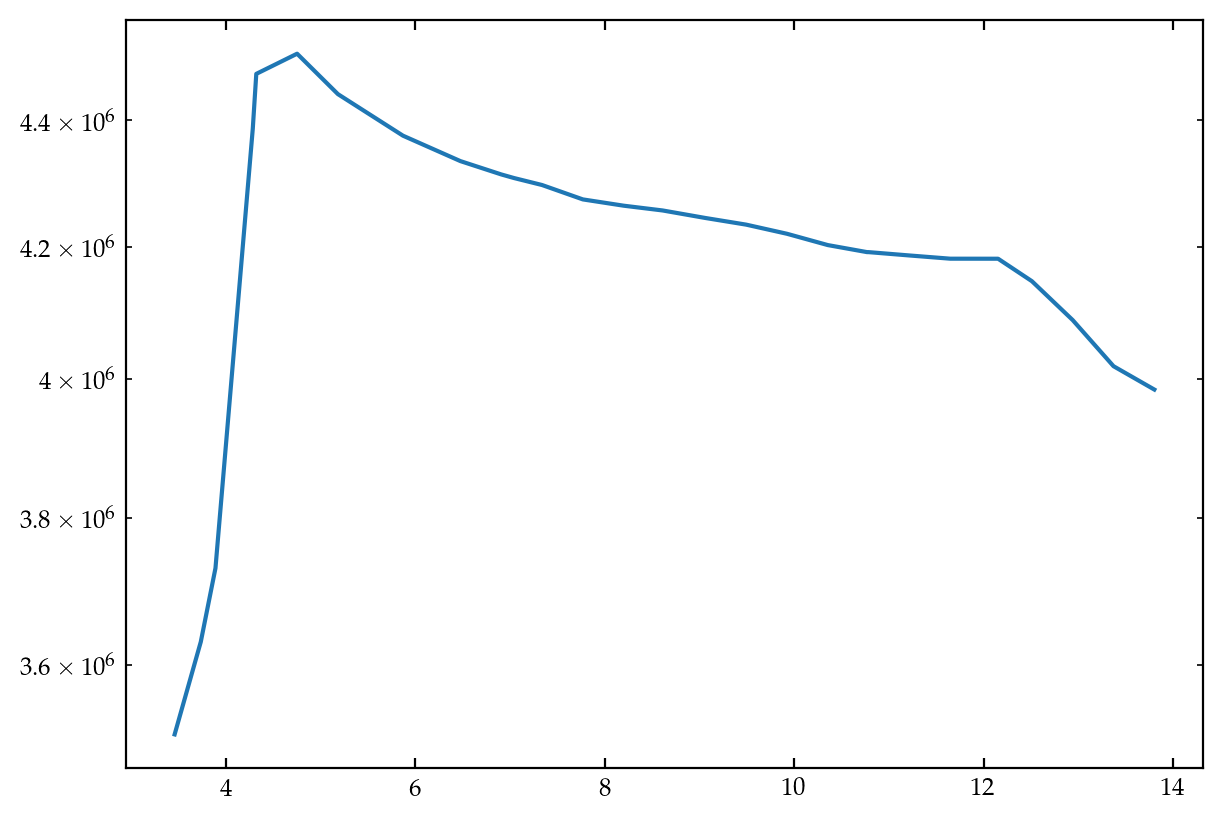

In [128]:

plt.plot(d.t, d.M_star)
plt.semilogy()


In [85]:
d.iloc[np.argmin(np.abs(d.t-12.5))].M_gas

SimArray(4365108.35150412, 'Msol')

In [84]:
ts = read_timesteps('h148')
ts = ts[ts.z0haloid==45]
ts[['t','haloid','mgas']]

t  haloid                mgas
18    13.800797    45.0                 0.0
69    13.369817    43.0                 0.0
120   12.938837    43.0                 0.0
171   12.507856    39.0   4365108.351504119
222   12.150951    40.0  10860397.941731803
273   12.076876    41.0  12044259.108776264
324   11.645896    39.0  15439871.933008168
374   11.214915    38.0  20123266.978507474
424   10.783935    36.0    23775052.8536753
474   10.767100    36.0  23907293.780857503
524   10.352954    36.0    28837706.3417311
574    9.921974    35.0   38038827.76738247
624    9.490994    32.0  52269023.241528794
674    9.060013    30.0   64637348.74563958
723    8.608831    28.0   87066892.57364309
772    8.198053    22.0  116159184.16395146
821    7.767072    20.0   140598587.3568091
869    7.336092    19.0   159967488.7238715
917    7.039793    18.0    173800880.299689
965    6.905111    20.0  175185513.55235666
1013   6.474131    22.0  196697191.45750824
1061   5.868065    19.0   202053691.7201355
1109   5.181190    23.0  254341090.16097537
1157   4.750210    21.0  291413965.29931855
1205   4.319229    24.0   328988174.7768126
1253   4.282192    24.0  329429905.88529444
1301   3.888249    27.0   342316966.7061509
1349   3.733365    27.0  346339632.43543863
1397   3.457268    32.0   361808136.9493259
1445   3.288917    32.0   376626623.6526792
1493   3.026288    30.0  482203521.37618804
1541   2.925277    30.0  505496651.33642983
1589   2.595308    31.0    517603905.788891
1637   2.369716    37.0   481621712.5987913
1685   2.164327    50.0   291395354.2578355
1733   1.733347    63.0   286610681.6426455
1781   1.544793    65.0  265725473.13432753
1829   1.302366    75.0   177852560.0415364
1876   1.177786   154.0   84777343.85444397
1923   0.935360   172.0   49523163.89517988
1969   0.767008   285.0  20545665.945557423
2011   0.642428   351.0  10418640.924650408
2048   0.477443   297.0   4957470.363637727

In [123]:
get_stored_filepaths_haloids('h148',329)

(['/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.004096',
  '/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.003968',
  '/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.003840',
  '/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.003712',
  '/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.003606',
  '/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.003584',
  '/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.003456',
  '/home/chri

/Users/hollis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/hollis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/hollis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/hollis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/hollis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/hollis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: R

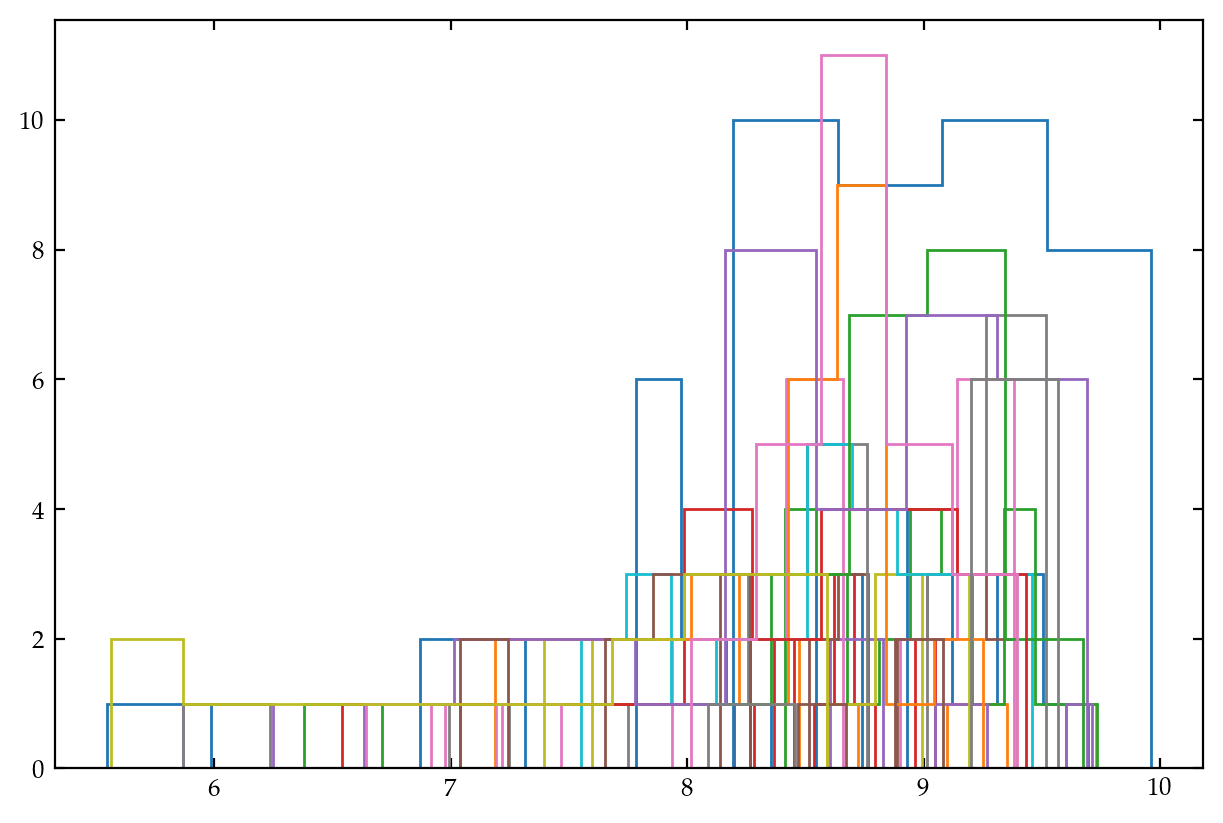

In [41]:
for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    p = np.log10(d.Prest)
    plt.hist(p[~np.isinf(p)], histtype='step')

In [1]:
from analysis import *

In [2]:
data_all = read_all_ram_pressure()

1 Returning (expelled, accreted) for h148-13...
2 Returning (expelled, accreted) for h148-28...
3 Returning (expelled, accreted) for h148-37...
4 Returning (expelled, accreted) for h148-45...
5 Returning (expelled, accreted) for h148-68...
6 Returning (expelled, accreted) for h148-80...
7 Returning (expelled, accreted) for h148-283...
8 Returning (expelled, accreted) for h148-278...
9 Returning (expelled, accreted) for h148-329...
10 Returning (expelled, accreted) for h229-20...
11 Returning (expelled, accreted) for h229-22...
12 Returning (expelled, accreted) for h229-23...
13 Returning (expelled, accreted) for h229-27...
14 Returning (expelled, accreted) for h229-55...
15 Returning (expelled, accreted) for h242-24...
16 Returning (expelled, accreted) for h242-41...
17 Returning (expelled, accreted) for h242-80...
18 Returning (expelled, accreted) for h329-33...
19 Returning (expelled, accreted) for h329-137...


In [3]:
data_all.keys()

Index(['t', 'a', 'h1dist', 'dNN', 'M_star', 'M_gas', 'satRvir', 'hostRvir',
       'vel_CGM', 'rho_CGM', 'Pram', 'n_CGM', 'vel_CGM_adv', 'rho_CGM_adv',
       'std_vel_CGM', 'std_rho_CGM', 'Pram_adv', 'Prest', 'SigmaGas_x',
       'dphidz', 'SFR', 'sSFR', 'ratio', 'ratio_prev', 'dt', 'tau', 'tquench',
       'Mgas_div', 'time_x', 'M_SNeaff', 'time_y', 'M_disk', 'Mdisk_div',
       'time_x', 'M_expelled', 'Mdot_expelled', 'Mdot_expelled_by_Mgas',
       'time_y', 'theta_mean', 'time_x', 'M_expelled_halo',
       'Mdot_expelled_halo', 'Mdot_expelled_halo_by_Mgas',
       'Mdot_expelled_halo_by_Mhalo', 'time_y', 'theta_mean_halo', 'time_x',
       'M_expelled_disk', 'Mdot_expelled_disk', 'Mdot_expelled_disk_by_Mgas',
       'Mdot_expelled_disk_by_Mdisk', 'time_y', 'theta_mean_disk', 'time_x',
       'M_expelled_th30', 'Mdot_expelled_th30', 'Mdot_expelled_th30_by_Mgas',
       'time_y', 'M_expelled_th30_disk', 'Mdot_expelled_th30_disk',
       'Mdot_expelled_th30_disk_by_Mdisk', 'time_x', 

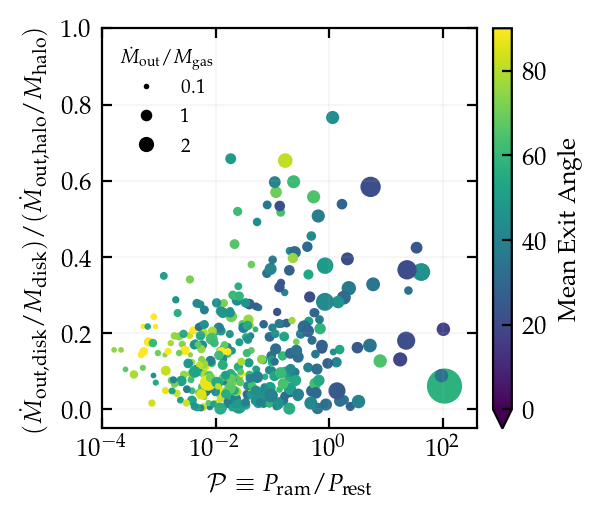

In [13]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05])
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])

from copy import copy
vmin, vmax = 0, 90
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)


# x = data_all.Pram_adv / (data_all.Prest/data_all.SigmaGas_x*data_all.SigmaGas_y)
x = data_all.ratio
y = data_all.Mdot_expelled_disk_by_Mgas/data_all.Mdot_expelled_by_Mgas
cond = ~np.isnan(data_all.Mdot_expelled_by_Mgas) & ~np.isinf(data_all.Mdot_expelled_by_Mgas)

im = ax.scatter(x[cond], y[cond], 
                c=data_all.theta_mean[cond], norm=norm, s=10*data_all.Mdot_expelled_by_Mgas[cond])

# outliers = (y > 1) & (x > 1e-2) & (x < 1)
# ax.scatter(x[outliers], y[outliers], c='r', s=3)


# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$(\dot{M}_{\rm out,disk}/M_{\rm disk})/(\dot{M}_{\rm out,halo}/M_{\rm halo})$')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.semilogx()
ax.set_xlim(1e-4, 4e2)
ax.set_ylim(-0.05, 1)
# ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
# ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)
leg = ax.legend(im.legend_elements("sizes", num=[1, 10, 20])[0], ['0.1', '1', '2'], fontsize=7, title=r'$\dot{M}_{\rm out}/M_{\rm gas}$', loc='upper left')
leg.get_title().set_fontsize('7')

fig.colorbar(im, cax=cax, label=r'Mean Exit Angle', extend='min')

plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
# plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

[]

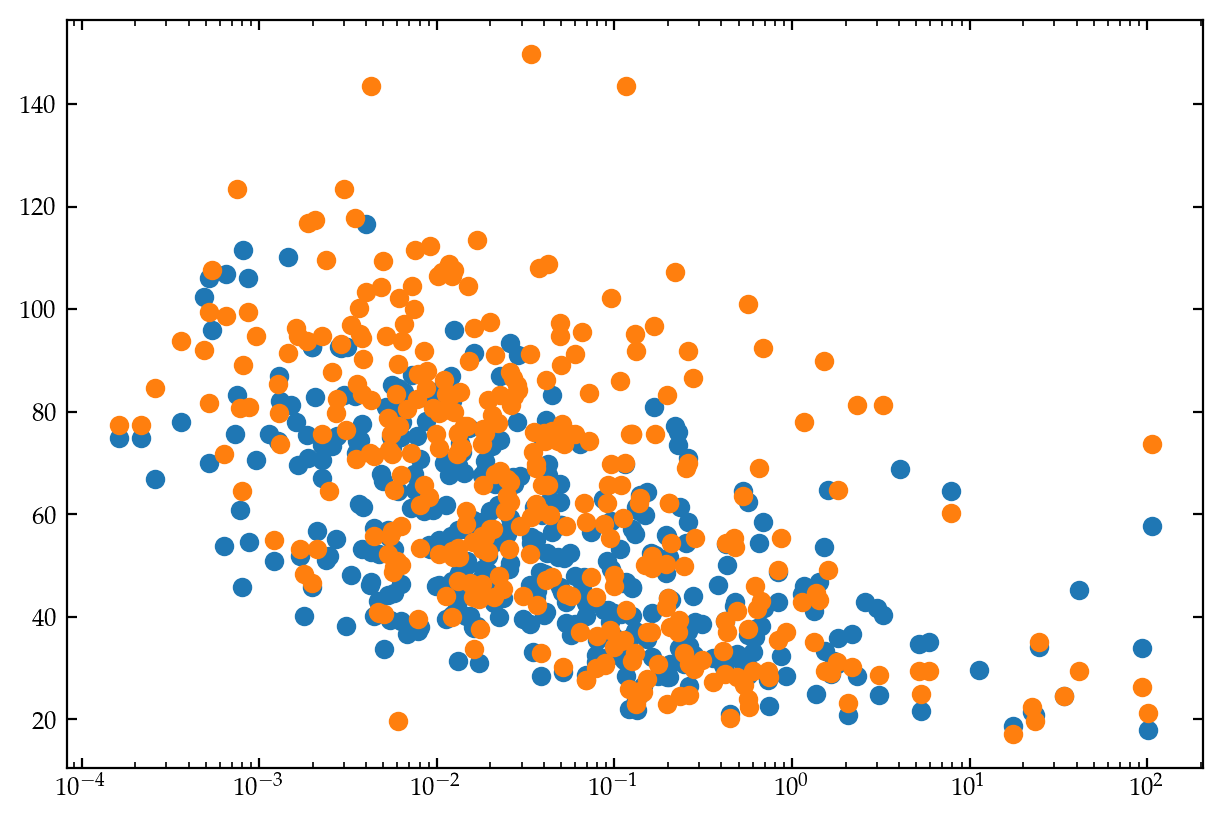

In [11]:
plt.scatter(data_all.ratio, data_all.theta_mean)
plt.scatter(data_all.ratio, data_all.theta_mean_disk)
plt.semilogx()

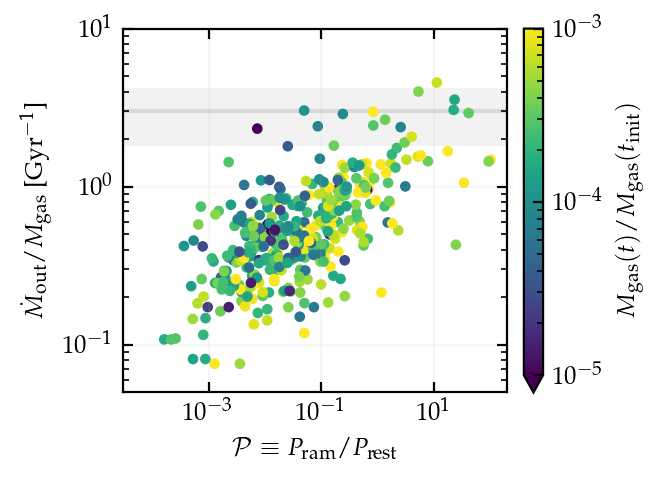

In [6]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=True)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05], figure=fig)
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])

# x = data_all.Pram_adv / (data_all.Prest/data_all.SigmaGas_x*data_all.SigmaGas_y)
x = data_all.ratio
y = data_all.Mdot_expelled_by_Mgas
outliers = (y > 2) & (x< 0.7)

im = ax.scatter(x, y, s=8, c=data_all.FG, norm=mpl.colors.LogNorm(vmax=1e-5, vmin=1e-3))
# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm out}/M_{\rm gas}$ [Gyr$^{-1}$]')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.loglog()
ax.set_xlim(3e-5, 2e2)
ax.set_ylim(5e-2, 1e1)
ax.plot([1e-5,1e3],[3,3],color='0.85', zorder=-90)
ax.fill_between([1e-5,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)

fig.colorbar(im, cax=cax, label=r'$M_{\rm gas}(t)/M_{\rm gas}(t_{\rm init})$', extend='min')

plt.show()

/Users/hollis/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:144: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/hollis/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:2032: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[0, 1] *= sx
/Users/hollis/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:2033: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[0, 2] *= sx
/Users/hollis/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:2034: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 0] *= sy
/Users/hollis/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:2036: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] *= sy


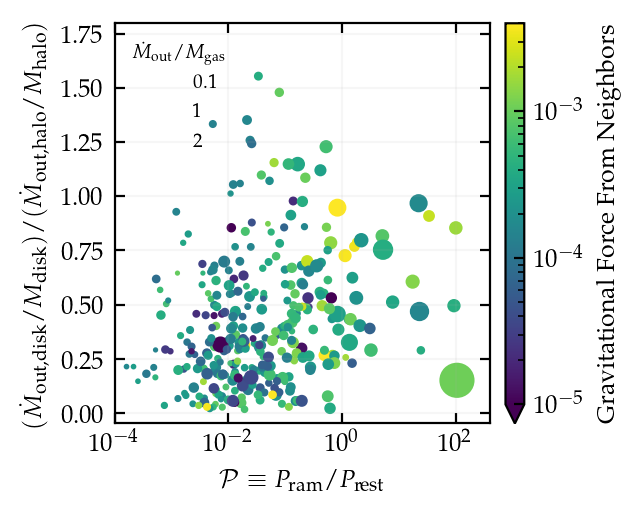

In [25]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05])
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])

from copy import copy
vmin, vmax = 1e-5, 4e-3
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)


x = data_all.ratio
y = data_all.Mdot_expelled_disk_by_Mdisk/data_all.Mdot_expelled_halo_by_Mhalo
cond = ~np.isnan(data_all.Mdot_expelled_by_Mgas)

im = ax.scatter(x[cond], y[cond], 
                c=data_all.FG[cond], norm=norm, s=10*data_all.Mdot_expelled_by_Mgas[cond])

outliers = (y > 1) & (x > 1e-2) & (x < 1)
# ax.scatter(x[outliers], y[outliers], c='r', s=3)


# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$(\dot{M}_{\rm out,disk}/M_{\rm disk})/(\dot{M}_{\rm out,halo}/M_{\rm halo})$')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.semilogx()
ax.set_xlim(1e-4, 4e2)
ax.set_ylim(-0.05, 1.8)
# ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
# ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)
leg = ax.legend(im.legend_elements("sizes", num=[1, 10, 20])[0], ['0.1', '1', '2'], fontsize=7, title=r'$\dot{M}_{\rm out}/M_{\rm gas}$', loc='upper left')
leg.get_title().set_fontsize('7')

fig.colorbar(im, cax=cax, label=r'Gravitational Force From Neighbors', extend='min')

plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
# plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

In [25]:
data_all.M_disk-data_all.Mdisk_div - data_all.M_expelled_disk

0    -4.260627e+06
1    -1.879647e+07
2     7.356983e+06
3     1.467406e+06
4     3.511241e+06
          ...     
34             NaN
35             NaN
36             NaN
37             NaN
38             NaN
Length: 512, dtype: float64

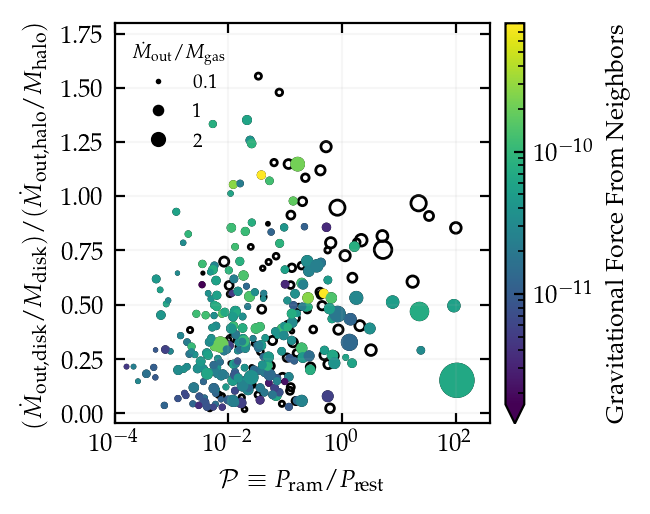

In [33]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05])
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])

x = data_all.ratio
y = data_all.Mdot_expelled_disk_by_Mdisk/data_all.Mdot_expelled_halo_by_Mhalo
c = data_all.SFR/data_all.M_disk
cond = ~np.isnan(data_all.Mdot_expelled_by_Mgas) & ~np.isinf(data_all.Mdot_expelled_by_Mgas)
norm = mpl.colors.LogNorm(vmax=8e-10)


im = ax.scatter(x[cond], y[cond], 
                fc='none', ec='k', norm=norm, s=10*data_all.Mdot_expelled_by_Mgas[cond])

im = ax.scatter(x[cond], y[cond], 
                c=c[cond], norm=norm, s=10*data_all.Mdot_expelled_by_Mgas[cond])

outliers = (y > 1) & (x > 1e-2) & (x < 1)
# ax.scatter(x[outliers], y[outliers], c='r', s=3)


# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$(\dot{M}_{\rm out,disk}/M_{\rm disk})/(\dot{M}_{\rm out,halo}/M_{\rm halo})$')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.semilogx()
ax.set_xlim(1e-4, 4e2)
ax.set_ylim(-0.05, 1.8)
# ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
# ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)
leg = ax.legend(im.legend_elements("sizes", num=[1, 10, 20])[0], ['0.1', '1', '2'], fontsize=7, title=r'$\dot{M}_{\rm out}/M_{\rm gas}$', loc='upper left')
leg.get_title().set_fontsize('7')

fig.colorbar(im, cax=cax, label=r'Gravitational Force From Neighbors', extend='min')

plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
# plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

In [51]:
data_k.keys()

Index(['t', 'a', 'h1dist', 'dNN', 'M_star', 'M_gas', 'satRvir', 'hostRvir',
       'vel_CGM', 'rho_CGM', 'Pram', 'n_CGM', 'vel_CGM_adv', 'rho_CGM_adv',
       'std_vel_CGM', 'std_rho_CGM', 'Pram_adv', 'Prest', 'SigmaGas_x',
       'dphidz', 'SFR', 'sSFR', 'ratio', 'ratio_prev', 'dt', 'tau', 'tquench',
       'Mgas_div', 'time_x', 'M_SNeaff', 'time_y', 'M_disk', 'Mdisk_div',
       'time_x', 'M_expelled', 'Mdot_expelled', 'Mdot_expelled_by_Mgas',
       'time_y', 'theta_mean', 'time_x', 'M_expelled_halo',
       'Mdot_expelled_halo', 'Mdot_expelled_halo_by_Mgas',
       'Mdot_expelled_halo_by_Mhalo', 'time_y', 'theta_mean_halo', 'time_x',
       'M_expelled_disk', 'Mdot_expelled_disk', 'Mdot_expelled_disk_by_Mgas',
       'Mdot_expelled_disk_by_Mdisk', 'time_y', 'theta_mean_disk', 'time_x',
       'M_expelled_th30', 'Mdot_expelled_th30', 'Mdot_expelled_th30_by_Mgas',
       'time_y', 'M_accreted', 'Mdot_accreted', 'Mdot_accreted_by_Mgas',
       'time_x', 'M_accreted_disk', 'Mdot_accret

3
39.9311066723964
60.582953954219015
149.87312692717637


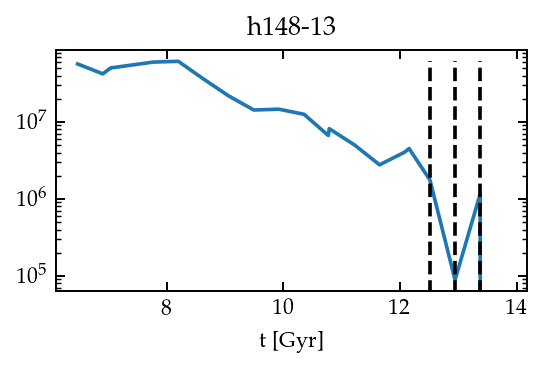

2
44.398047547402896
96.72807169048069


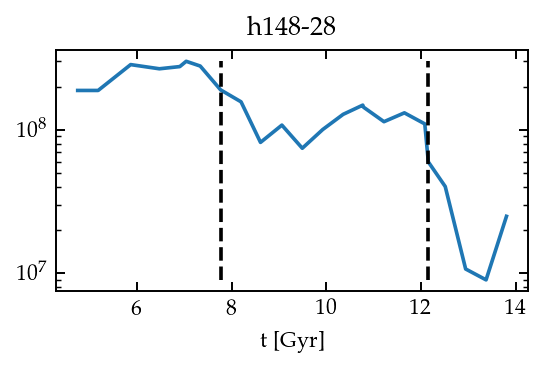

2
30.06646001868965
27.57460538786495


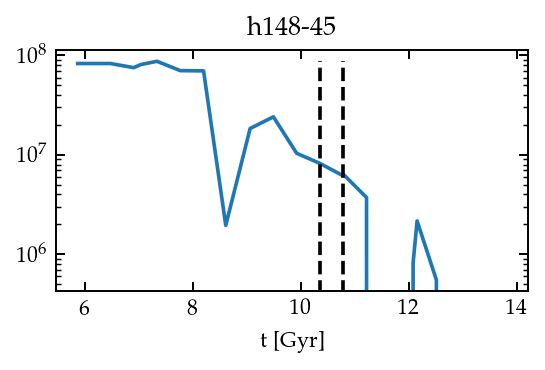

2
70.07720553005758
24.549155866999186


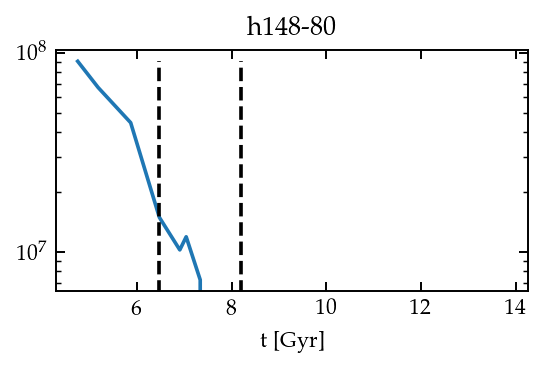

2
96.37621714488314
106.55821851143305


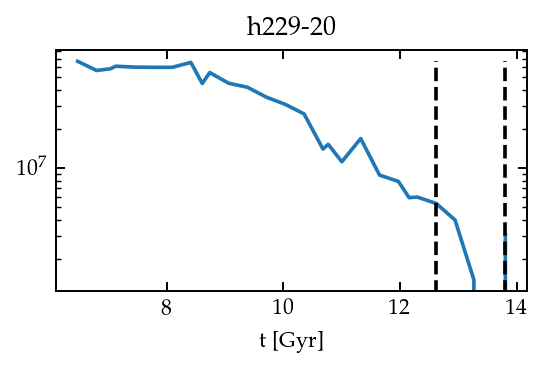

4
60.560862974750684
67.83307437855787
74.2154004675008
91.83088946089997


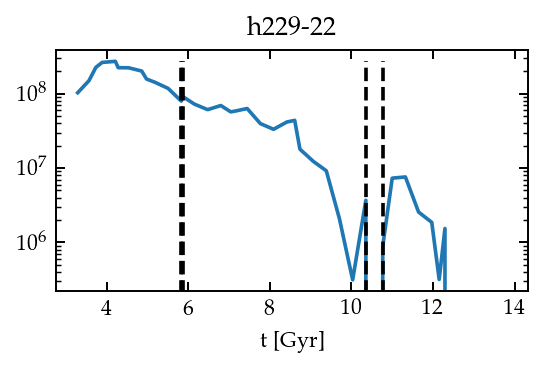

1
75.56522232515836


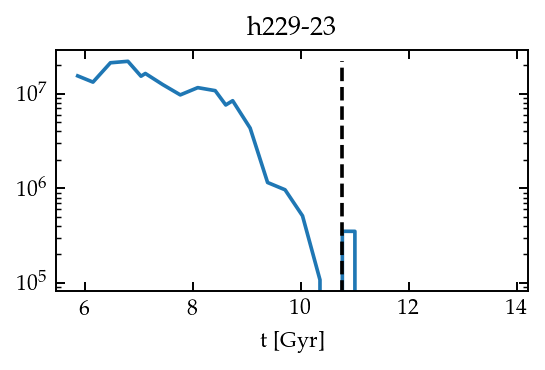

1
62.179173480788435


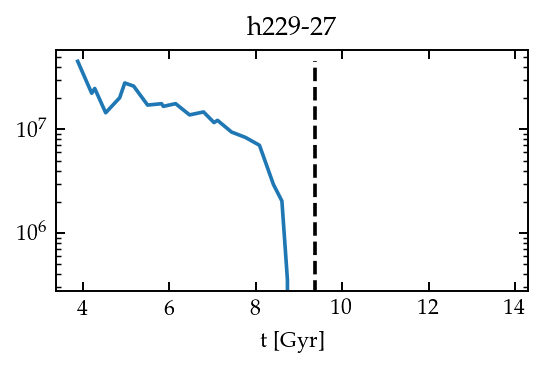

5
63.52382373853002
36.92935063453208
36.92935063453208
36.92935063453208
36.92935063453208


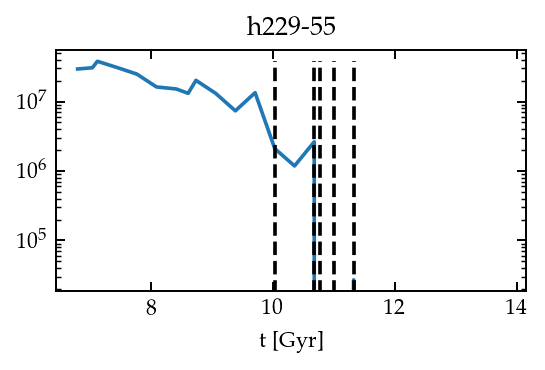

4
65.74675669602847
65.74675669602847
65.74675669602847
65.74675669602847


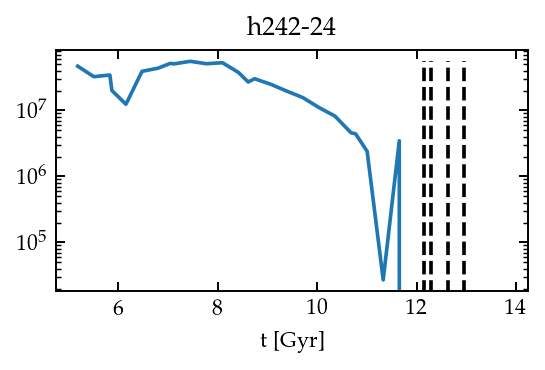

1
62.423008266071776


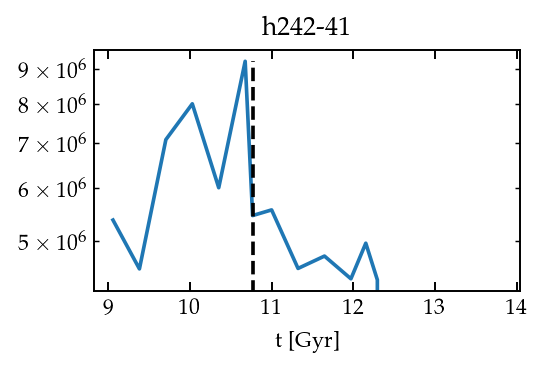

1
86.12648510144784


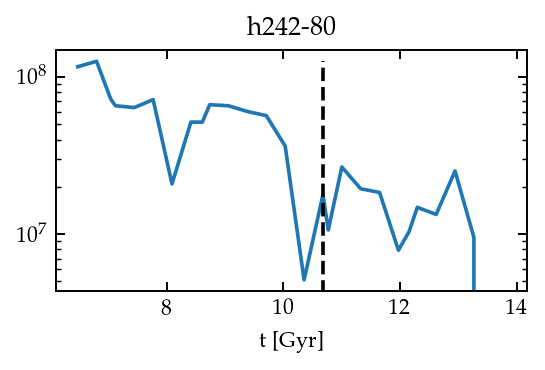

4
28.88939387671529
55.29881635296382
55.29881635296382
55.29881635296382


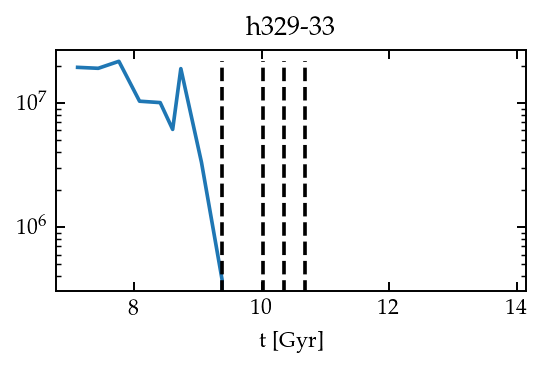

In [9]:
outlier_keys = data_all[outliers][['key']]

for k in np.unique(outlier_keys):
    data_k = data_all[data_all.key==k]
    outliers_k = outliers[data_all.key==k]
    
    fig, ax = plt.subplots(1,1,figsize=(3,2),dpi=175)
    ax.plot(data_k.t, data_k.M_disk)
    
    ts = np.array(data_k.t)[outliers_k]
    print(len(ts))
    for t in ts:
        ax.plot([t,t],[np.min(data_k.M_disk),np.max(data_k.M_disk)],'k--')
        print(data_k[data_k.t==t]['theta_mean_disk'].tolist()[0])
    
    ax.set_xlabel('t [Gyr]')
    ax.set_title(k.replace('_','-'))
    plt.semilogy()
    plt.show()

    

In [73]:
sim, haloid = 'h148', 13

In [74]:
# Load in ram pressure data
path = '../../Data/ram_pressure.hdf5'
key = f'{sim}_{haloid}'
data = pd.read_hdf(path, key=key)

# convert data to numpy arrays (i.e. remove pynbody unit information) and calculate ratio
data['Pram_adv'] = np.array(data.Pram_adv,dtype=float)
data['Pram'] = np.array(data.Pram,dtype=float)
data['Prest'] = np.array(data.Prest,dtype=float)
data['ratio'] = data.Pram_adv / data.Prest

ratio_prev = np.array(data.Pram_adv/data.Prest,dtype=float)
ratio_prev = np.append(ratio_prev[0], ratio_prev[:-1])
data['ratio_prev'] = ratio_prev

dt = np.array(data.t)[1:] - np.array(data.t)[:-1]
dt = np.append(dt[0],dt)
data['dt'] = dt

# load ejected/expelled data
expelled,accreted = read_ejected_expelled(sim, haloid)

# Mgas_div is the gas mass we divide by when plotting rates. this is the gas mass 1 snapshot ago
Mgas_div = np.array(data.M_gas,dtype=float)
Mgas_div = np.append(Mgas_div[0], Mgas_div[:-1])
data['Mgas_div'] = Mgas_div

# load in particle data
particles = read_tracked_particles(sim,haloid)
# m_disk = 0 if particle is not in the disk, = particle mass if it is. this allows us to compute total mass in the disk
particles['m_disk'] = np.array(particles.mass,dtype=float)*np.array(particles.sat_disk,dtype=int)

# group the particles data by unique times and sum the mass of particles that are in the disk, to get total mass
# data = pd.merge(data, particles.groupby(['time']).m_disk.sum().reset_index(), how='left', left_on='t', right_on='time')
# data = data.rename(columns={'m_disk':'M_disk'})

Returning (expelled, accreted) for h148-13...


In [77]:
pd.merge(data, particles.groupby(['time']).m_disk.sum().reset_index(), how='left', left_on='t', right_on='time')

t         a      h1dist         dNN              M_star  \
0    6.474131  0.537186  423.531296  178.684714  100847839.53591666   
1    6.905111  0.563402  361.437487  178.728207  101175469.43702735   
2    7.039793  0.571574  340.566235  178.166036   101182058.5286643   
3    7.336092  0.589531  292.055470  175.412003  101457993.92692062   
4    7.767072  0.615628  213.638074  164.678961  101922259.70865524   
5    8.198053  0.641740  133.332843  133.332843  102957595.61049445   
6    8.608831  0.666686  107.208916   78.253150  103847635.48326856   
7    9.060013  0.694192  160.381779  160.381779  104234329.50824556   
8    9.490994  0.720611  232.374541   55.961806  104293734.10214442   
9    9.921974  0.747210  289.417623  108.765248  104345228.71441951   
10  10.352954  0.774023  335.017232  161.787537  104388702.06779113   
11  10.767100  0.800022  365.682649  207.963950  104404100.38593733   
12  10.783935  0.801084  366.420212  209.730898  104399071.33972734   
13  11.214915  0.828424  381.954008  253.267716  104412212.34652689   
14  11.645896  0.856075  389.294598  288.755131  104418977.69850108   
15  12.076876  0.884065  386.213594  329.809211  104396530.55312231   
16  12.150951  0.888913  384.764358  335.894919  104406176.27793697   
17  12.507856  0.912425  373.517709  337.814526  104429215.21384482   
18  12.938837  0.941183  350.175460  325.147477  104403649.45377362   
19  13.369817  0.970365  319.919225  319.919225  104386453.10955867   
20  13.800797  1.000000  284.687462  284.687462  104376733.61681984   

                 M_gas    satRvir    hostRvir     vel_CGM      rho_CGM  ...  \
0    314970038.6902275  42.360119  177.866525  184.559286   218.474060  ...   
1   308855984.29167813  44.759939  188.949459  202.219302   259.355120  ...   
2    301198403.8916383  45.468217  192.398621  208.994033   333.859921  ...   
3    277943421.0439347  47.157674  200.539727  225.969959   852.895770  ...   
4   159423887.21248782  49.372360  218.455662  251.073050  1511.600202  ...   
5   125586218.46095285  51.239292  235.865510  291.403008  3185.753708  ...   
6    86829226.25884873  39.123962  250.434675  310.871571  4379.328865  ...   
7    55521474.97990627  49.516763  267.722410  249.980990  1657.042798  ...   
8    43592049.31248152  27.976160  284.057447  169.335823   979.463459  ...   
9    39897326.01088829  51.291885  296.681438  129.465974   291.037380  ...   
10   34805456.11337077  52.641336  308.938054  109.751691   197.299479  ...   
11  29298131.731836673  53.795636  322.313416  100.809240   165.096159  ...   
12   29127108.91674745  53.855233  322.871344  100.655824   163.918939  ...   
13  25483949.595796302  55.265414  339.599308  102.323683   241.145986  ...   
14  20388525.376740195  56.895278  356.340785  107.435608   169.092213  ...   
15   18301286.21355214  58.651199  374.031846  113.551672   154.497156  ...   
16  18124313.424328953  58.959664  376.528614  114.845041   149.909261  ...   
17  15704401.854370117  60.451886  389.584807  121.174972   166.196070  ...   
18  12322373.729045011  62.287737  403.766194  131.745068   218.488358  ...   
19   9882573.749556027  64.104493  417.889129  145.737272   261.309072  ...   
20   7503452.808617334  65.870410  432.304078  164.521503   366.856856  ...   

              SigmaGas      dphidz       SFR         sSFR     ratio  \
0     170201.660478939  416.600325  0.006685  6.62895e-11  0.002740   
1   142372.95083385304  424.941547  0.006486  6.41029e-11  0.007728   
2    156325.7031222481  419.832261  0.002601  2.57041e-11  0.012432   
3    213625.2056783062  418.050255  0.004567  4.50179e-11  0.049683   
4    5096302.225314851  411.149801  0.004102  4.02489e-11  0.068964   
5   11997472.585736599  412.362356  0.006812  6.61636e-11  0.088327   
6    7267159.043981016  386.088501  0.004624  4.45285e-11  0.196654   
7    5676521.635988705  370.076333  0.003115  2.98864e-11  0.023668   
8   2894727.0715715885  353.128225  0.001655   1.5873e-11  0.012326   


In [79]:
pd.merge_asof(data, particles.groupby(['time']).m_disk.sum().reset_index(), left_on='t', right_on='time', direction='nearest', tolerance=1)

t         a      h1dist         dNN              M_star  \
0    6.474131  0.537186  423.531296  178.684714  100847839.53591666   
1    6.905111  0.563402  361.437487  178.728207  101175469.43702735   
2    7.039793  0.571574  340.566235  178.166036   101182058.5286643   
3    7.336092  0.589531  292.055470  175.412003  101457993.92692062   
4    7.767072  0.615628  213.638074  164.678961  101922259.70865524   
5    8.198053  0.641740  133.332843  133.332843  102957595.61049445   
6    8.608831  0.666686  107.208916   78.253150  103847635.48326856   
7    9.060013  0.694192  160.381779  160.381779  104234329.50824556   
8    9.490994  0.720611  232.374541   55.961806  104293734.10214442   
9    9.921974  0.747210  289.417623  108.765248  104345228.71441951   
10  10.352954  0.774023  335.017232  161.787537  104388702.06779113   
11  10.767100  0.800022  365.682649  207.963950  104404100.38593733   
12  10.783935  0.801084  366.420212  209.730898  104399071.33972734   
13  11.214915  0.828424  381.954008  253.267716  104412212.34652689   
14  11.645896  0.856075  389.294598  288.755131  104418977.69850108   
15  12.076876  0.884065  386.213594  329.809211  104396530.55312231   
16  12.150951  0.888913  384.764358  335.894919  104406176.27793697   
17  12.507856  0.912425  373.517709  337.814526  104429215.21384482   
18  12.938837  0.941183  350.175460  325.147477  104403649.45377362   
19  13.369817  0.970365  319.919225  319.919225  104386453.10955867   
20  13.800797  1.000000  284.687462  284.687462  104376733.61681984   

                 M_gas    satRvir    hostRvir     vel_CGM      rho_CGM  ...  \
0    314970038.6902275  42.360119  177.866525  184.559286   218.474060  ...   
1   308855984.29167813  44.759939  188.949459  202.219302   259.355120  ...   
2    301198403.8916383  45.468217  192.398621  208.994033   333.859921  ...   
3    277943421.0439347  47.157674  200.539727  225.969959   852.895770  ...   
4   159423887.21248782  49.372360  218.455662  251.073050  1511.600202  ...   
5   125586218.46095285  51.239292  235.865510  291.403008  3185.753708  ...   
6    86829226.25884873  39.123962  250.434675  310.871571  4379.328865  ...   
7    55521474.97990627  49.516763  267.722410  249.980990  1657.042798  ...   
8    43592049.31248152  27.976160  284.057447  169.335823   979.463459  ...   
9    39897326.01088829  51.291885  296.681438  129.465974   291.037380  ...   
10   34805456.11337077  52.641336  308.938054  109.751691   197.299479  ...   
11  29298131.731836673  53.795636  322.313416  100.809240   165.096159  ...   
12   29127108.91674745  53.855233  322.871344  100.655824   163.918939  ...   
13  25483949.595796302  55.265414  339.599308  102.323683   241.145986  ...   
14  20388525.376740195  56.895278  356.340785  107.435608   169.092213  ...   
15   18301286.21355214  58.651199  374.031846  113.551672   154.497156  ...   
16  18124313.424328953  58.959664  376.528614  114.845041   149.909261  ...   
17  15704401.854370117  60.451886  389.584807  121.174972   166.196070  ...   
18  12322373.729045011  62.287737  403.766194  131.745068   218.488358  ...   
19   9882573.749556027  64.104493  417.889129  145.737272   261.309072  ...   
20   7503452.808617334  65.870410  432.304078  164.521503   366.856856  ...   

              SigmaGas      dphidz       SFR         sSFR     ratio  \
0     170201.660478939  416.600325  0.006685  6.62895e-11  0.002740   
1   142372.95083385304  424.941547  0.006486  6.41029e-11  0.007728   
2    156325.7031222481  419.832261  0.002601  2.57041e-11  0.012432   
3    213625.2056783062  418.050255  0.004567  4.50179e-11  0.049683   
4    5096302.225314851  411.149801  0.004102  4.02489e-11  0.068964   
5   11997472.585736599  412.362356  0.006812  6.61636e-11  0.088327   
6    7267159.043981016  386.088501  0.004624  4.45285e-11  0.196654   
7    5676521.635988705  370.076333  0.003115  2.98864e-11  0.023668   
8   2894727.0715715885  353.128225  0.001655   1.5873e-11  0.012326   


In [71]:
data_k.M_disk

0              NaN
1              NaN
2     5.040180e+07
3     5.413022e+07
4     6.005953e+07
5              NaN
6     3.713373e+07
7     2.182753e+07
8     1.431321e+07
9     1.465857e+07
10    1.257992e+07
11             NaN
12    8.181525e+06
13    5.036338e+06
14    2.773456e+06
15    4.057968e+06
16             NaN
17             NaN
18    8.855800e+04
19    1.158531e+06
20             NaN
Name: M_disk, dtype: float64

In [65]:
# Load in ram pressure data
sim, haloid = 'h148',80
path = '../../Data/ram_pressure.hdf5'
key = f'{sim}_{haloid}'
data = pd.read_hdf(path, key=key)

In [67]:
data.keys()

Index(['t', 'a', 'h1dist', 'dNN', 'M_star', 'M_gas', 'satRvir', 'hostRvir',
       'vel_CGM', 'rho_CGM', 'Pram', 'n_CGM', 'vel_CGM_adv', 'rho_CGM_adv',
       'std_vel_CGM', 'std_rho_CGM', 'Pram_adv', 'Prest', 'SigmaGas', 'dphidz',
       'SFR', 'sSFR'],
      dtype='object')

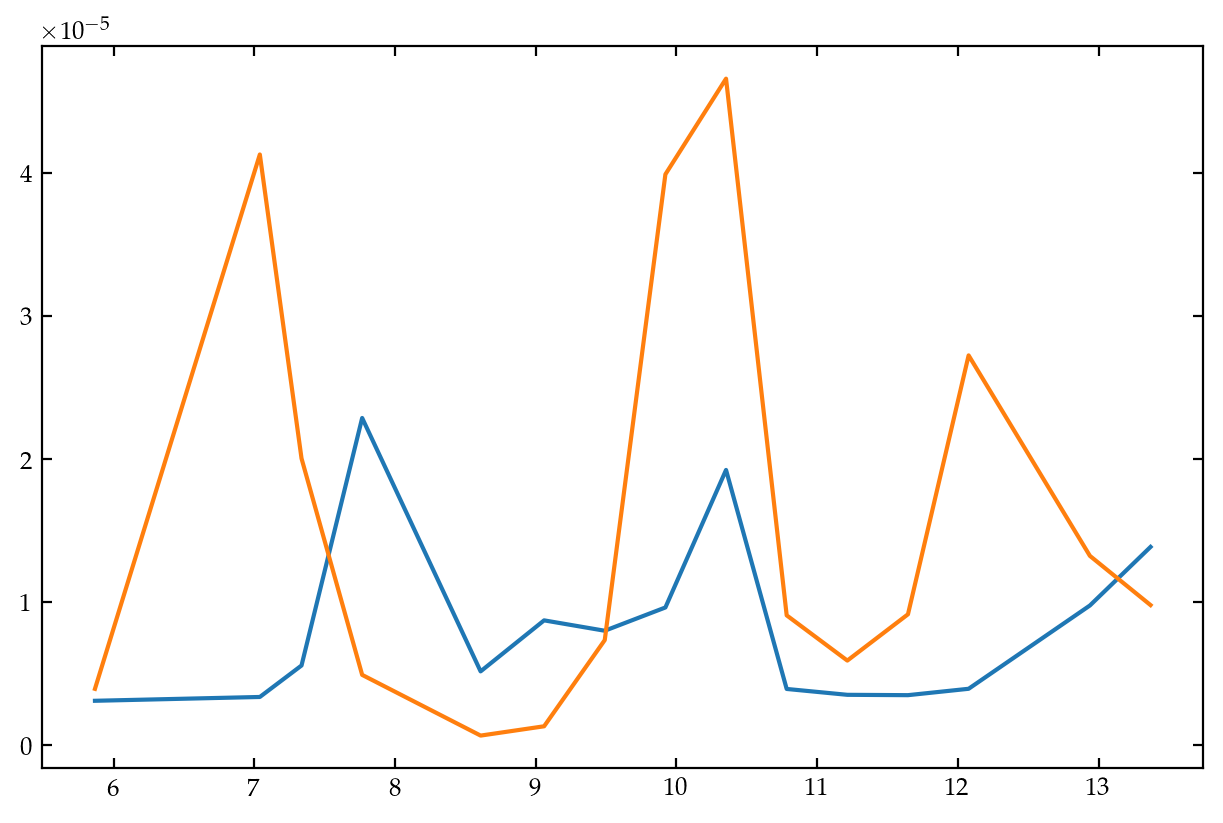

In [115]:
plt.plot(timesteps_target.t, dNN)
plt.plot(timesteps_target.t, timesteps_target.Pram/1e13)

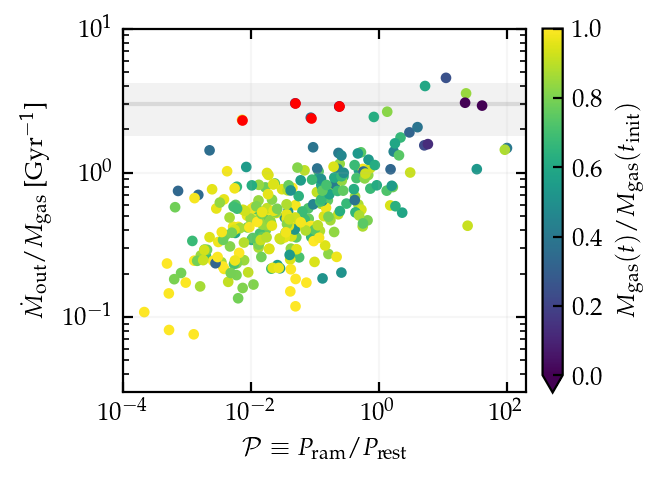

In [107]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=True)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05], figure=fig)
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])

x = data_all.ratio 
y = data_all.Mdot_expelled_by_Mgas
outliers = (y > 2) & (x< 0.7)

im = ax.scatter(data_all.ratio, data_all.Mdot_expelled_by_Mgas, s=8, c=data_all.f_gas, norm=mpl.colors.LogNorm(vmax=1, vmin=1.05e-3))
im = ax.scatter(data_all.ratio[outliers], data_all.Mdot_expelled_by_Mgas[outliers], s=8, c='r')
# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm out}/M_{\rm gas}$ [Gyr$^{-1}$]')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.loglog()
ax.set_xlim(1e-4, 2e2)
ax.set_ylim(3e-2, 1e1)
ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)

fig.colorbar(im, cax=cax, label=r'$M_{\rm gas}(t)/M_{\rm gas}(t_{\rm init})$', extend='min')

plt.show()

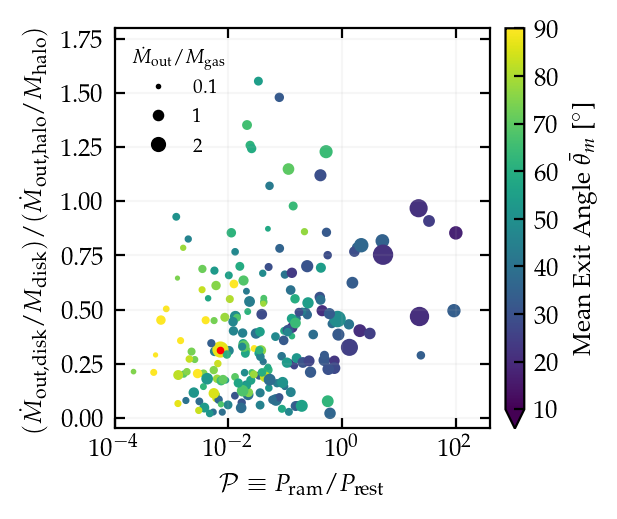

In [23]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05])
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])

from copy import copy
vmin, vmax = 10, 90
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)


x = data_all.ratio
y = data_all.Mdot_expelled_disk_by_Mdisk/data_all.Mdot_expelled_halo_by_Mhalo
cond = ~np.isnan(data_all.Mdot_expelled_by_Mgas)

im = ax.scatter(x[cond], y[cond], 
                c=data_all.theta_mean[cond], norm=norm, s=10*data_all.Mdot_expelled_by_Mgas[cond])

# outliers = (y > 0.9) & (x > 1e-2) & (x < 1)
ax.scatter(x[outliers&cond], y[outliers&cond], c='r', s=3)


# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$(\dot{M}_{\rm out,disk}/M_{\rm disk})/(\dot{M}_{\rm out,halo}/M_{\rm halo})$')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.semilogx()
ax.set_xlim(1e-4, 4e2)
ax.set_ylim(-0.05, 1.8)
# ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
# ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)
leg = ax.legend(im.legend_elements("sizes", num=[1, 10, 20])[0], ['0.1', '1', '2'], fontsize=7, title=r'$\dot{M}_{\rm out}/M_{\rm gas}$', loc='upper left')
leg.get_title().set_fontsize('7')

fig.colorbar(im, cax=cax, label=r'Mean Exit Angle $\bar{\theta}_m$ [$^\circ$]', extend='min')

plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
# plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

In [27]:
data_all.M_disk[outliers&cond]

3     2.007481e+07
13    0.000000e+00
14    0.000000e+00
15    0.000000e+00
Name: M_disk, dtype: float64

[]

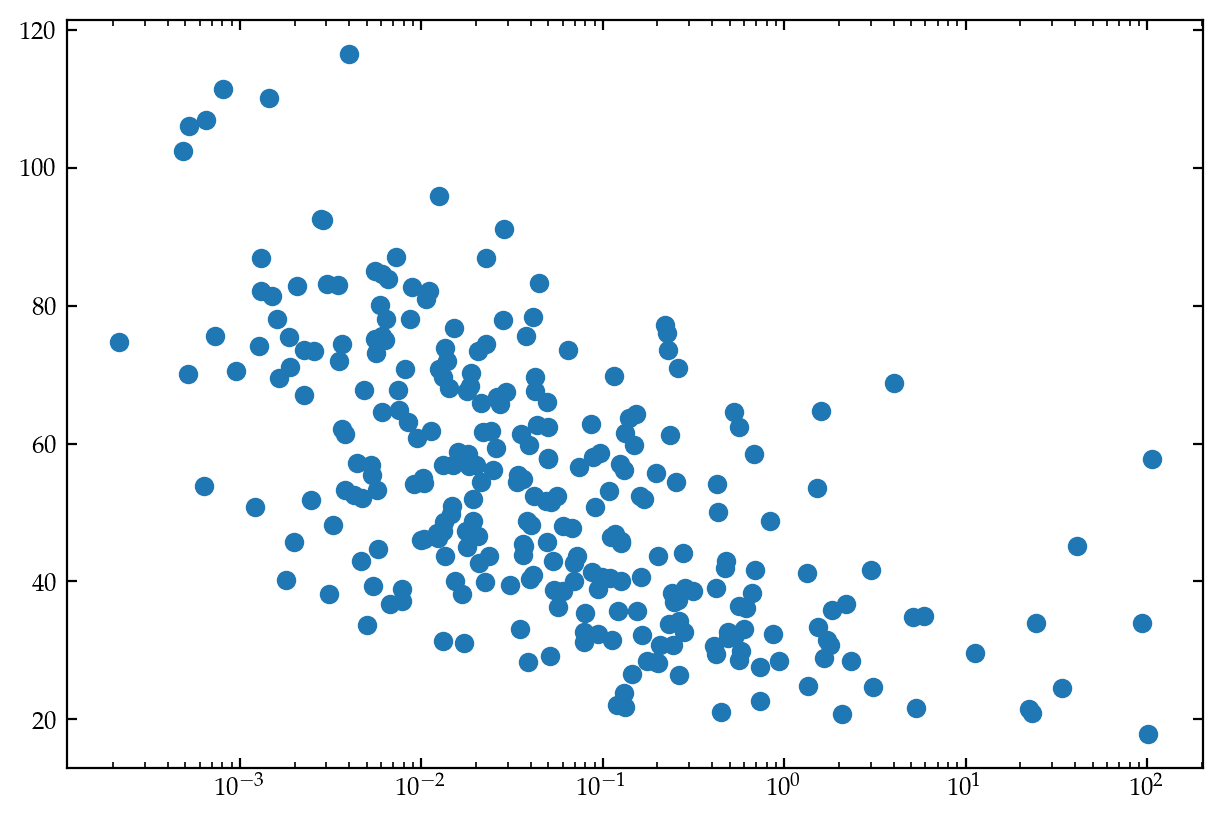

In [6]:
plt.scatter(data_all.ratio, data_all.theta_mean)
plt.semilogx()

In [10]:
data_all['0_x']

0           NaN
1           NaN
2     70.754124
3     62.387419
4     40.116079
        ...    
34          NaN
35          NaN
36          NaN
37          NaN
38          NaN
Name: 0_x, Length: 512, dtype: float64

In [18]:
expelled.angle.

Signature:
expelled.angle.mean(
    axis=None,
    skipna=None,
    level=None,
    numeric_only=None,
    **kwargs,
)
Docstring:
Return the mean of the values for the requested axis.

Parameters
----------
axis : {index (0)}
    Axis for the function to be applied on.
skipna : bool, default True
    Exclude NA/null values when computing the result.
level : int or level name, default None
    If the axis is a MultiIndex (hierarchical), count along a
    particular level, collapsing into a scalar.
numeric_only : bool, default None
    Include only float, int, boolean columns. If None, will attempt to use
    everything, then use only numeric data. Not implemented for Series.
**kwargs
    Additional keyword arguments to be passed to the function.

Returns
-------
scalar or Series (if level specified)
File:      ~/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py
Type:      method


In [21]:
expelled, accreted = read_ejected_expelled('h329',33)

expelled.groupby(['time']).apply(lambda x: np.average(x.angle, weights=x.mass)).reset_index()

Returning (expelled, accreted) for h329-33...


time          0
0    7.443837  38.585320
1    7.767072  56.914690
2    8.090307  77.180434
3    8.413543  36.122452
4    8.608831  33.964723
5    8.736778  24.809208
6    9.060013  20.711399
7    9.383249  29.461962
8    9.706484  32.317421
9   10.029719  41.986508
10  10.352954  39.011205
11  10.676190  38.886113
12  10.767100  62.898146
13  10.999425  65.977623
14  11.322660  38.356753
15  11.645896  23.919411

In [9]:
data_all.theta_mean

0              NaN
1              NaN
2     1.858224e+06
3     1.627754e+06
4     1.050664e+06
          ...     
34             NaN
35             NaN
36             NaN
37             NaN
38             NaN
Name: theta_mean, Length: 512, dtype: float64

(array([260.,  19.,  10.,   2.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.07591931,  1.42787953,  2.77983975,  4.13179996,  5.48376018,
         6.83572039,  8.18768061,  9.53964083, 10.89160104, 12.24356126,
        13.59552147]),
 <BarContainer object of 10 artists>)

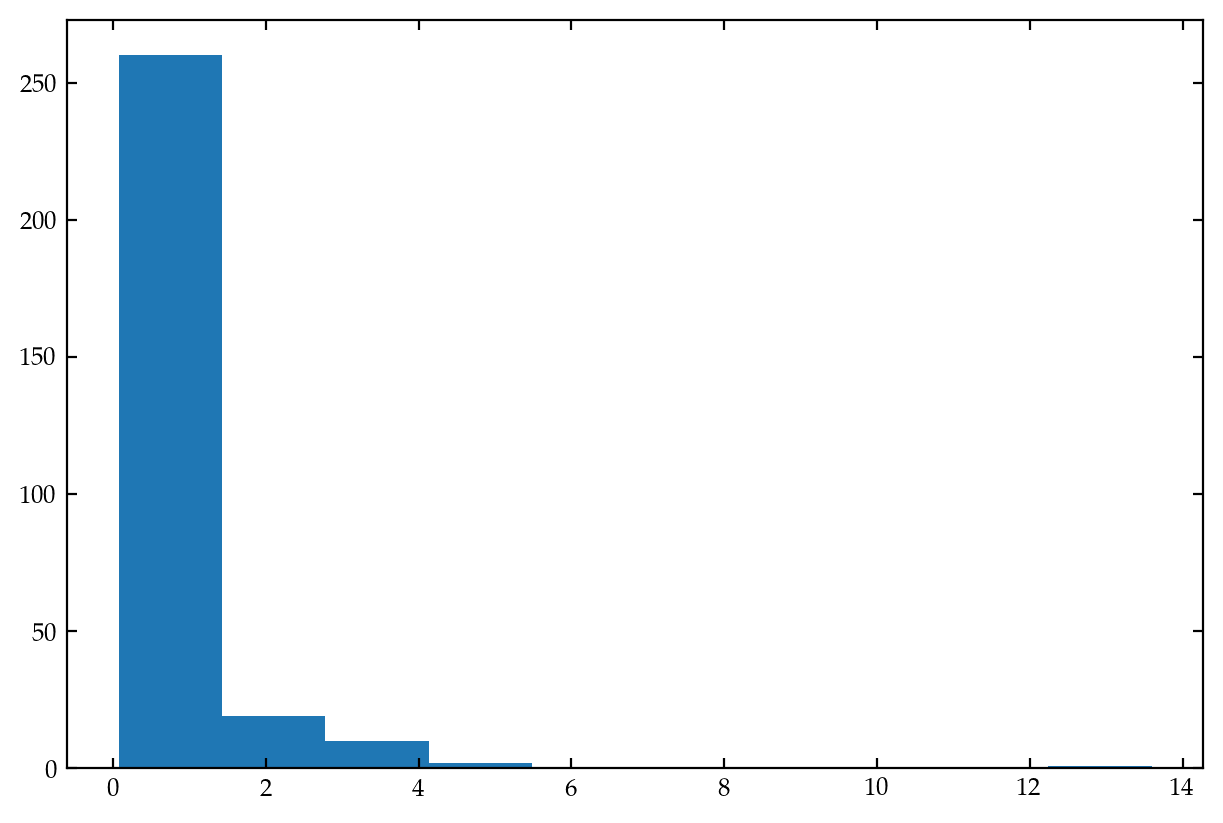

In [19]:
plt.hist(data_all.Mdot_expelled/data_all.Mgas_div)

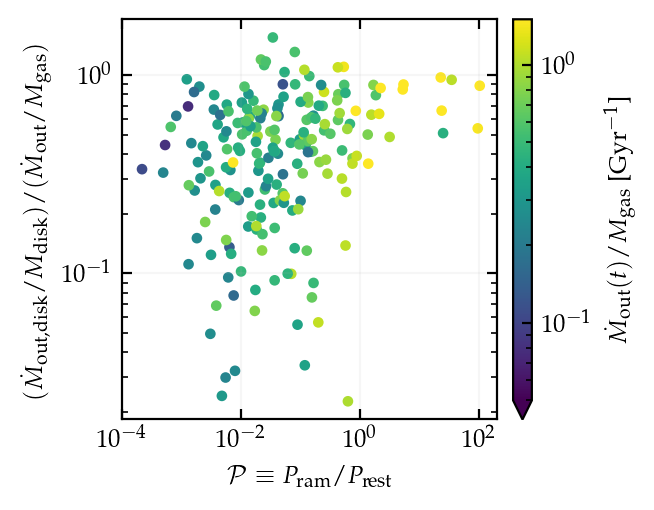

In [5]:
fig = plt.figure(dpi=200, figsize=(3.2,2.3), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1,0.05])
cax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,0])

im = ax.scatter(data_all.ratio, (data_all.Mdot_expelled_disk/data_all.Mdisk_div)/(data_all.Mdot_expelled/data_all.Mgas_div), s=8, 
                c=data_all.Mdot_expelled_by_Mgas, norm=mpl.colors.LogNorm(vmax=1.5, vmin=5e-2))
# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$(\dot{M}_{\rm out,disk}/M_{\rm disk})/(\dot{M}_{\rm out}/M_{\rm gas})$')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.loglog()
ax.set_xlim(1e-4, 2e2)
# ax.set_ylim(1e-2, 5)
# ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
# ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)

fig.colorbar(im, cax=cax, label=r'$\dot{M}_{\rm out}(t)/M_{\rm gas}$ [Gyr$^{-1}$]', extend='min')

plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
# plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

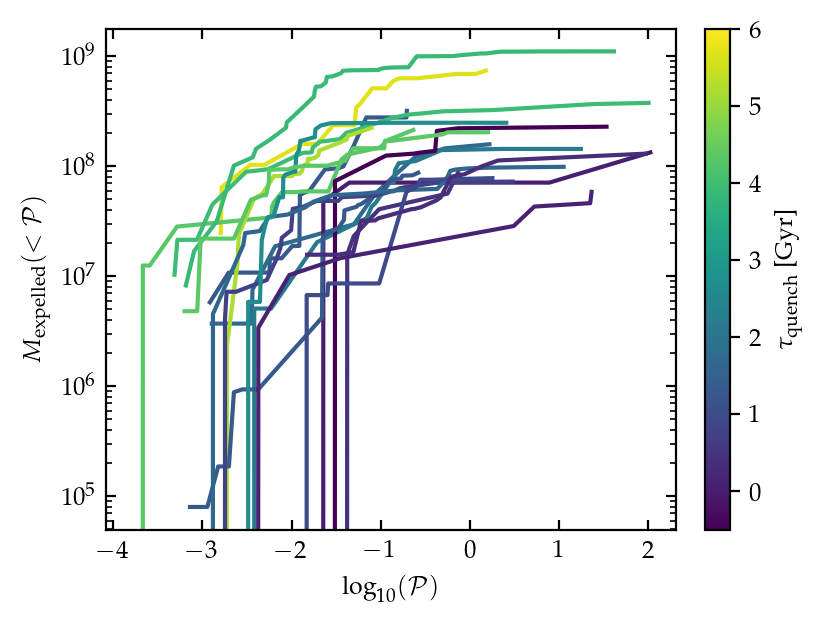

In [6]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

vmin, vmax = 7.5, 9
cmap = mpl.cm.get_cmap('viridis')

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    d = d.sort_values('ratio')
    
    ts = read_timescales()
    ts = ts[(ts.sim==key[:4])&(ts.haloid==int(key[5:]))]
    tau = float(ts.tinfall-ts.tquench)
    
    #c = np.log10(np.array(d.M_gas)[np.argmin(np.array(d.time))])
    c = tau 
    vmin, vmax = -0.5, 6
    ax.plot(np.log10(d.ratio), np.nancumsum(d.M_expelled), color=cmap((c-vmin)/(vmax-vmin)))


cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                    ax=ax, label=r'$\tau_{\rm quench}$ [Gyr]')
cbar.ax.tick_params(direction='out',which='both')
 
ax.set_ylabel(r'$M_{\rm expelled}(< \mathcal{P})$')
ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.semilogy()
plt.show()

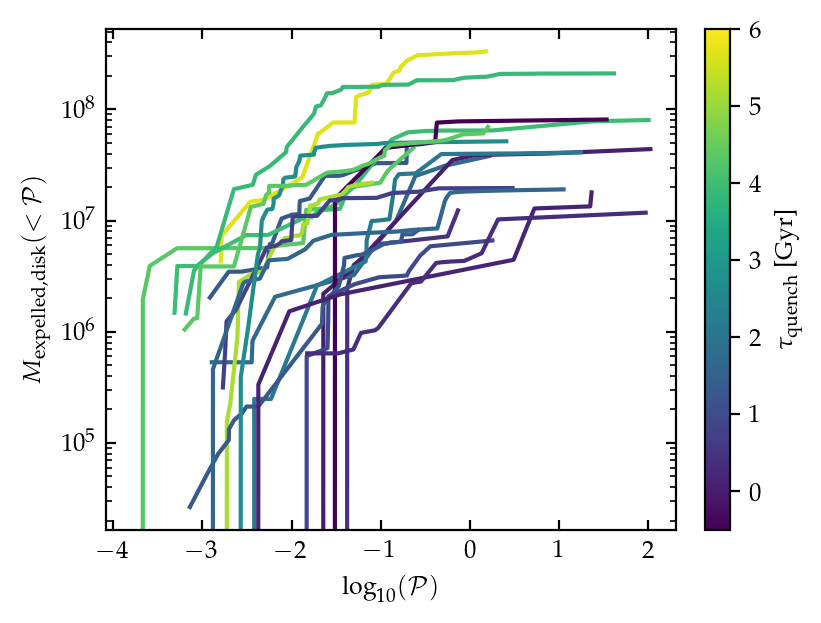

In [15]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

vmin, vmax = 7.5, 9
cmap = mpl.cm.get_cmap('viridis')

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    d = d.sort_values('ratio')
    
    ts = read_timescales()
    ts = ts[(ts.sim==key[:4])&(ts.haloid==int(key[5:]))]
    tau = float(ts.tinfall-ts.tquench)
    
    c = tau 
    vmin, vmax = -0.5, 6
    ax.plot(np.log10(d.ratio), np.nancumsum(d.M_expelled_disk), color=cmap((c-vmin)/(vmax-vmin)))


cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                    ax=ax, label=r'$\tau_{\rm quench}$ [Gyr]')
cbar.ax.tick_params(direction='out',which='both')
 
ax.set_ylabel(r'$M_{\rm expelled,disk}(< \mathcal{P})$')
ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.semilogy()
plt.show()

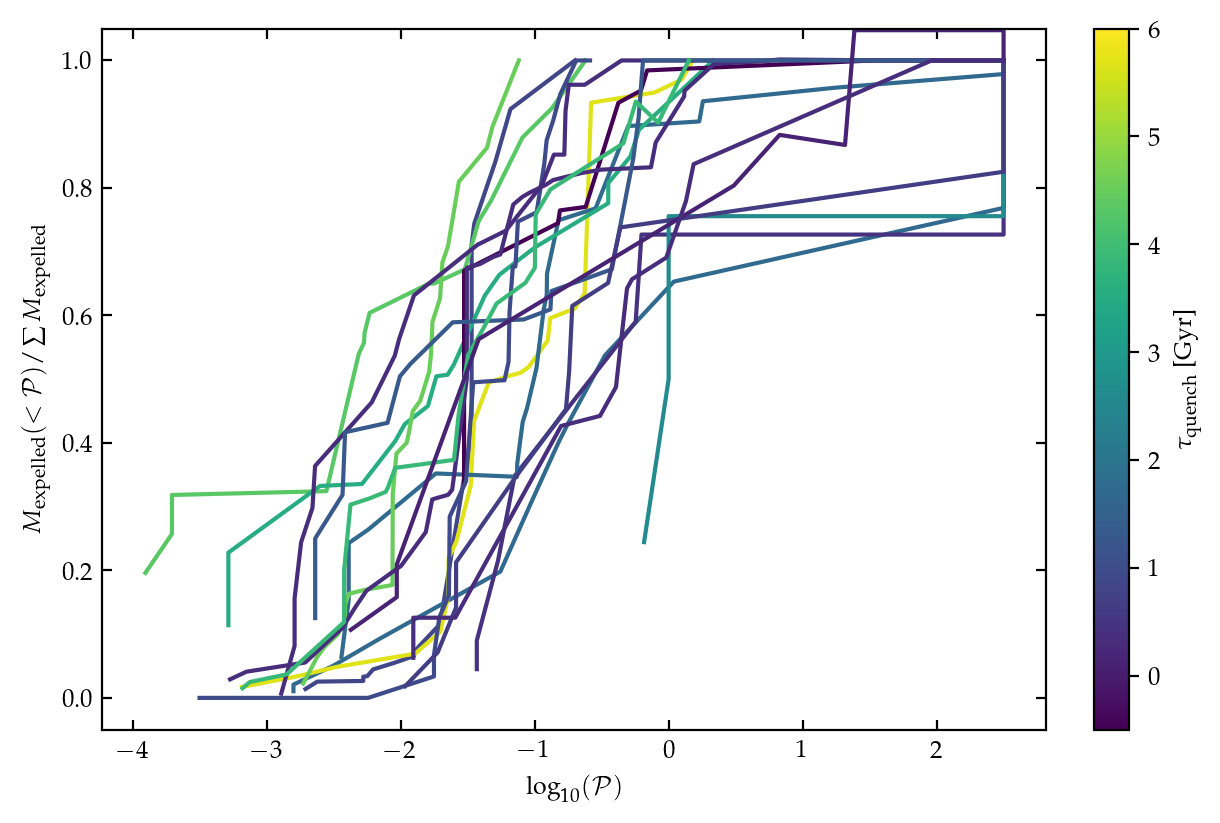

In [52]:
fig, ax = plt.subplots(1,1,dpi=200)

cmap = mpl.cm.get_cmap('viridis')

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    d = d.sort_values('ratio_prev')
    
    ts = read_timescales()
    ts = ts[(ts.sim==key[:4])&(ts.haloid==int(key[5:]))]
    tau = float(ts.tinfall-ts.tquench)
    
    #c = np.log10(np.array(d.M_gas)[np.argmin(np.array(d.time))])
    #vmin, vmax = 7.5, 9
    
    c = tau 
    vmin, vmax = -0.5, 6
    
    x = np.log10(d.ratio_prev)
    y = np.nancumsum(d.M_expelled-d.M_expelled_disk)/np.sum(d.M_expelled-d.M_expelled_disk)
    x[np.isinf(x)] = 2.5
    ax.plot(x, y, color=cmap((c-vmin)/(vmax-vmin)))
    

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                    ax=ax, label=r'$\tau_{\rm quench}$ [Gyr]')
cbar.ax.tick_params(direction='out',which='both')

ax.set_ylim(-0.05,1.05)
ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'$M_{\rm expelled}(<\mathcal{P})/\sum M_{\rm expelled}$')
plt.show()

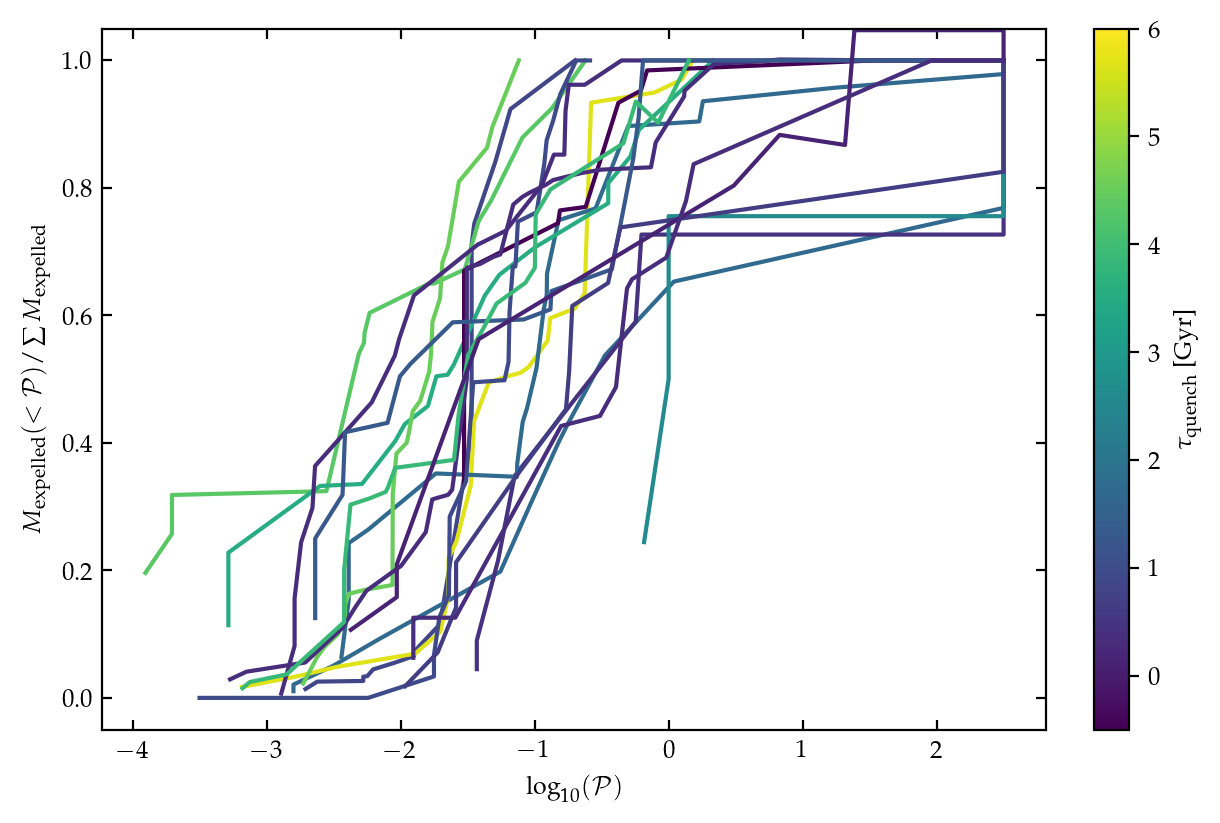

In [53]:
fig, ax = plt.subplots(1,1,dpi=200)

cmap = mpl.cm.get_cmap('viridis')

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    d = d.sort_values('ratio_prev')
    
    ts = read_timescales()
    ts = ts[(ts.sim==key[:4])&(ts.haloid==int(key[5:]))]
    tau = float(ts.tinfall-ts.tquench)
    
    #c = np.log10(np.array(d.M_gas)[np.argmin(np.array(d.time))])
    #vmin, vmax = 7.5, 9
    
    c = tau 
    vmin, vmax = -0.5, 6
    
    x = np.log10(d.ratio_prev)
    y = np.nancumsum(d.M_expelled-d.M_expelled_disk)/np.sum(d.M_expelled-d.M_expelled_disk)
    x[np.isinf(x)] = 2.5
    ax.plot(x, y, color=cmap((c-vmin)/(vmax-vmin)))
    

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                    ax=ax, label=r'$\tau_{\rm quench}$ [Gyr]')
cbar.ax.tick_params(direction='out',which='both')

ax.set_ylim(-0.05,1.05)
ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'$M_{\rm expelled}(<\mathcal{P})/\sum M_{\rm expelled}$')
plt.show()

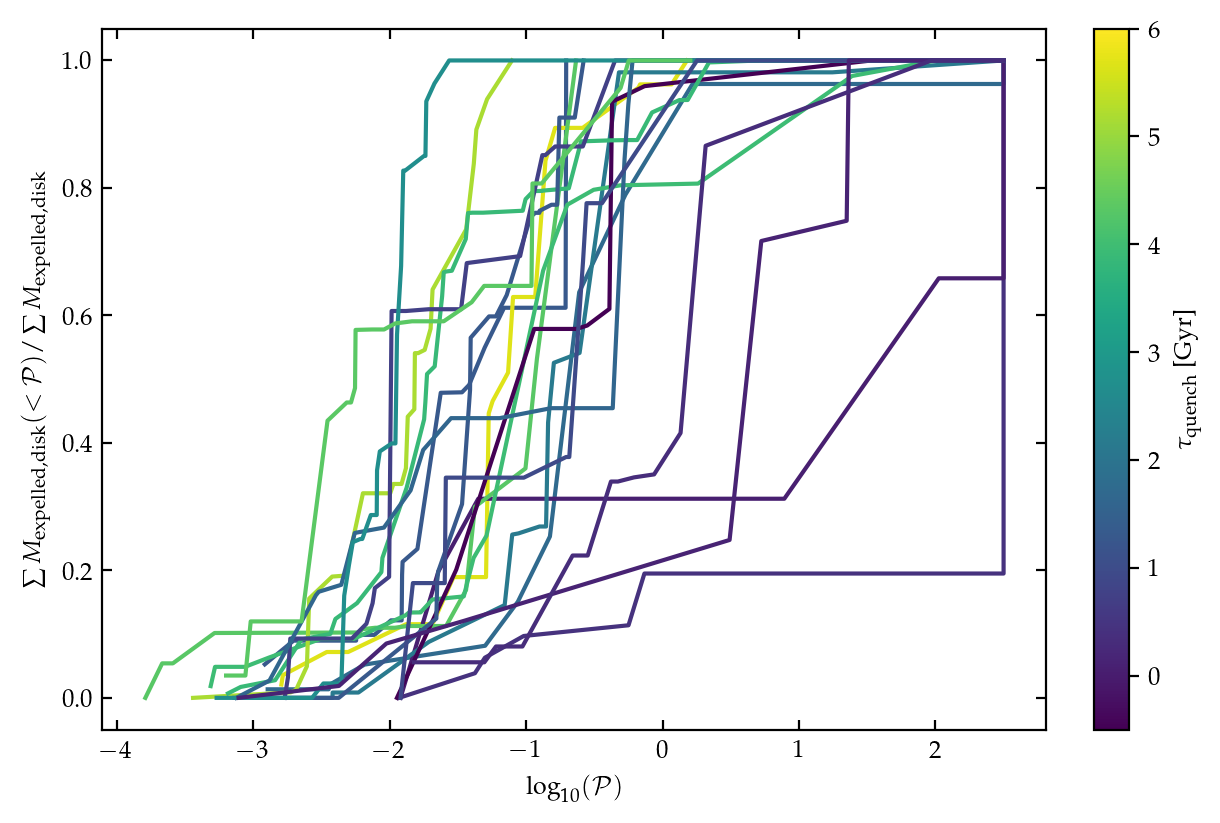

In [7]:
fig, ax = plt.subplots(1,1,dpi=200)

cmap = mpl.cm.get_cmap('viridis')

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    d = d.sort_values('ratio')
    
    ts = read_timescales()
    ts = ts[(ts.sim==key[:4])&(ts.haloid==int(key[5:]))]
    tau = float(ts.tinfall-ts.tquench)
    
    #c = np.log10(np.array(d.M_gas)[np.argmin(np.array(d.time))])
    #vmin, vmax = 7.5, 9
    
    c = tau 
    vmin, vmax = -0.5, 6
    
    x = np.log10(d.ratio)
    y = np.nancumsum(d.M_expelled_disk)/np.sum(d.M_expelled_disk)
    x[np.isinf(x)] = 2.5
    ax.plot(x, y, color=cmap((c-vmin)/(vmax-vmin)))
    

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                    ax=ax, label=r'$\tau_{\rm quench}$ [Gyr]')
cbar.ax.tick_params(direction='out',which='both')


ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'$\sum M_{\rm expelled,disk}(<\mathcal{P})/\sum M_{\rm expelled,disk}$')
plt.show()

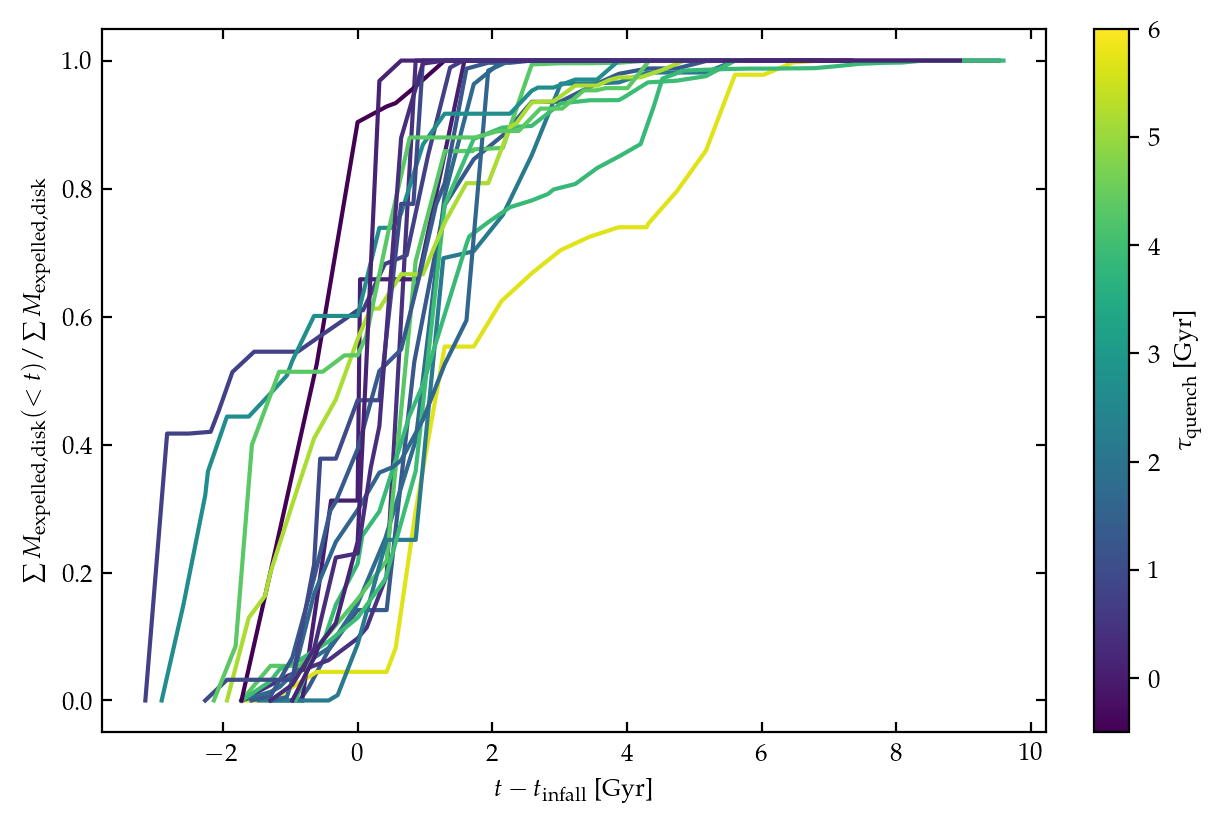

In [6]:
fig, ax = plt.subplots(1,1,dpi=200)

cmap = mpl.cm.get_cmap('viridis')

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    d = d.sort_values('t')
    
    ts = read_timescales()
    ts = ts[(ts.sim==key[:4])&(ts.haloid==int(key[5:]))]
    tau = float(ts.tinfall-ts.tquench)
    tinfall = age - float(ts.tinfall)
    
    #c = np.log10(np.array(d.M_gas)[np.argmin(np.array(d.time))])
    #vmin, vmax = 7.5, 9
    
    c = tau 
    vmin, vmax = -0.5, 6
    
    x = d.t-tinfall
    y = np.nancumsum(d.M_expelled_disk)/np.sum(d.M_expelled_disk)
    x[np.isinf(x)] = 2.5
    ax.plot(x, y, color=cmap((c-vmin)/(vmax-vmin)))
    

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                    ax=ax, label=r'$\tau_{\rm quench}$ [Gyr]')
cbar.ax.tick_params(direction='out',which='both')


ax.set_xlabel(r'$t-t_{\rm infall}$ [Gyr]')
ax.set_ylabel(r'$\sum M_{\rm expelled,disk}(<t)/\sum M_{\rm expelled,disk}$')
plt.show()

In [1]:
from analysis import *
data_all = read_all_ram_pressure()

1 Returning (expelled, accreted) for h148-12...
2 Returning (expelled, accreted) for h148-249...
3 Returning (expelled, accreted) for h148-251...
4 Returning (expelled, accreted) for h148-27...
5 Returning (expelled, accreted) for h148-282...
6 Returning (expelled, accreted) for h148-34...
7 Returning (expelled, accreted) for h148-38...
8 Returning (expelled, accreted) for h148-55...
9 Returning (expelled, accreted) for h148-65...
10 Returning (expelled, accreted) for h229-14...
11 Returning (expelled, accreted) for h229-18...
12 Returning (expelled, accreted) for h229-20...
13 Returning (expelled, accreted) for h229-22...
14 Returning (expelled, accreted) for h229-49...
15 Returning (expelled, accreted) for h242-21...
16 Returning (expelled, accreted) for h242-38...
17 Returning (expelled, accreted) for h242-69...
18 Returning (expelled, accreted) for h329-117...
19 Returning (expelled, accreted) for h329-29...


h242_21


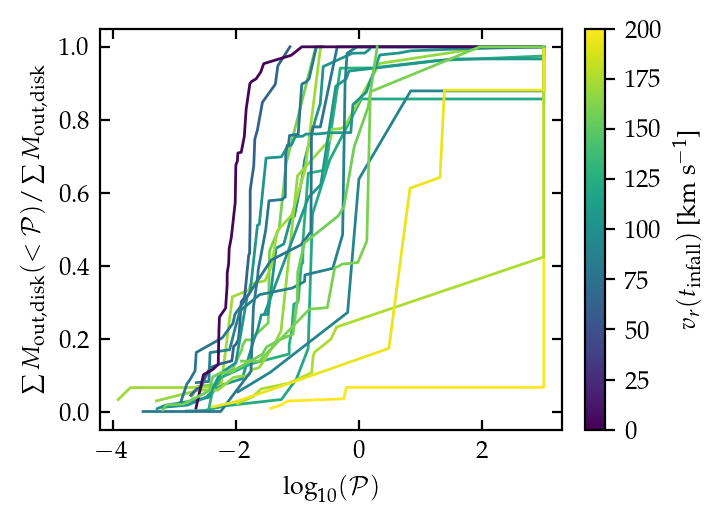

In [2]:
fig, ax = plt.subplots(1,1,figsize=(3.5, 2.5), dpi=200, constrained_layout=True)

cmap = mpl.cm.get_cmap('viridis')

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    d = d.sort_values('ratio')

    ts = read_timescales()
    ts = ts[(ts.sim==key[:4])&(ts.haloid==int(key[5:]))]
    tau = float(ts.tinfall-ts.tquench)
    
    ip = read_infall_properties()
    ip = ip[(ip.sim==key[:4])&(ip.haloid==int(key[5:]))]
    
    
    c = float(-ip.v_r) 
    vmin, vmax = 0, 200
    if c < 25:
        print(key)
    
    x = np.log10(d.ratio)
    y = np.nancumsum(d.M_expelled_disk)/np.sum(d.M_expelled_disk)
    x[np.isinf(x)] = 3
    ax.plot(x, y, color=cmap((c-vmin)/(vmax-vmin)), linewidth=1)
    

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                    ax=ax, label=r'$v_r(t_{\rm infall})$ [km~s$^{-1}$]')
cbar.ax.tick_params(direction='out',which='both')


ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'$\sum M_{\rm out,disk}(<\mathcal{P})/\sum M_{\rm out,disk}$')
ax.set_xlim(-4.2, 3.3)
plt.savefig('plots/cumulative_Mout.pdf')

plt.show()

h242_21


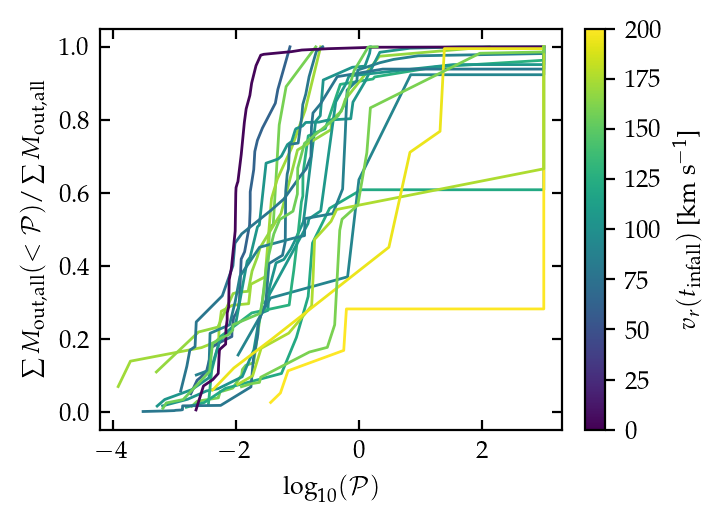

In [36]:
fig, ax = plt.subplots(1,1,figsize=(3.5, 2.5), dpi=200, constrained_layout=True)

cmap = mpl.cm.get_cmap('viridis')

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    d = d.sort_values('ratio')

    ts = read_timescales()
    ts = ts[(ts.sim==key[:4])&(ts.haloid==int(key[5:]))]
    tau = float(ts.tinfall-ts.tquench)
    
    ip = read_infall_properties()
    ip = ip[(ip.sim==key[:4])&(ip.haloid==int(key[5:]))]
    
    
    c = float(-ip.v_r) 
    vmin, vmax = 0, 200
    if c < 25:
        print(key)
    
    x = np.log10(d.ratio)
    y = np.nancumsum(d.M_expelled)/np.sum(d.M_expelled)
    x[np.isinf(x)] = 3
    ax.plot(x, y, color=cmap((c-vmin)/(vmax-vmin)), linewidth=1)
    

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                    ax=ax, label=r'$v_r(t_{\rm infall})$ [km~s$^{-1}$]')
cbar.ax.tick_params(direction='out',which='both')


ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'$\sum M_{\rm out,all}(<\mathcal{P})/\sum M_{\rm out,all}$')
ax.set_xlim(-4.2, 3.3)
# plt.savefig('plots/cumulative_Mout.pdf')

plt.show()

h242_21


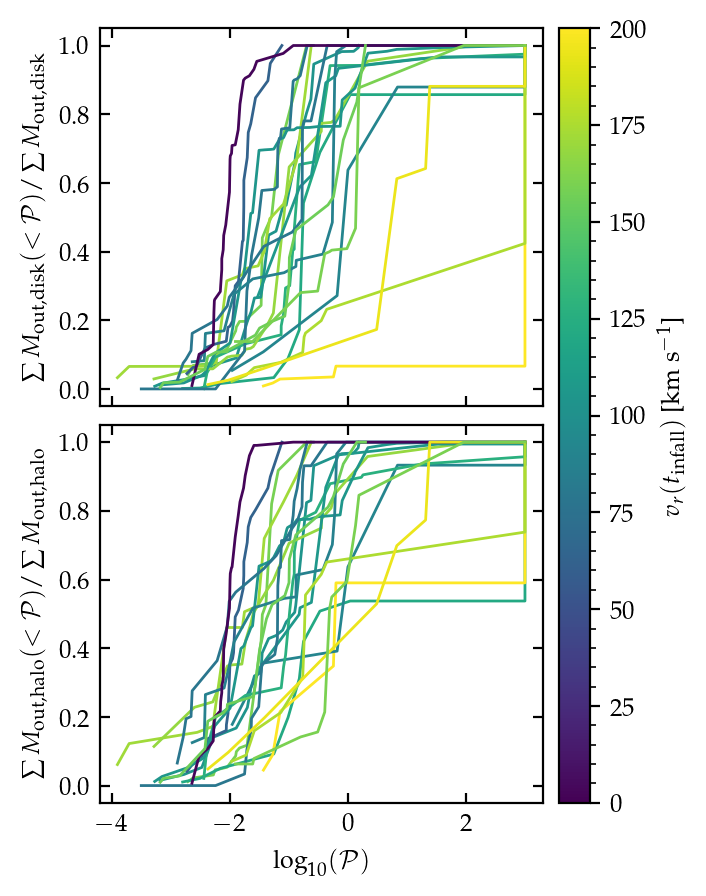

In [4]:
fig = plt.figure(figsize=(3.5, 4.4), dpi=200, constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[1,0.07])
gs.update(wspace=0.07, hspace=0.05, left=0.15, right=0.85, top=0.98, bottom=0.1)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
cax = plt.subplot(gs[:,1])

cmap = mpl.cm.get_cmap('viridis')

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    d = d.sort_values('ratio')

    ts = read_timescales()
    ts = ts[(ts.sim==key[:4])&(ts.haloid==int(key[5:]))]
    tau = float(ts.tinfall-ts.tquench)
    
    ip = read_infall_properties()
    ip = ip[(ip.sim==key[:4])&(ip.haloid==int(key[5:]))]
    
    
    c = float(-ip.v_r) 
    vmin, vmax = 0, 200
    if c < 25:
        print(key)
    
    x = np.log10(d.ratio)
    x[np.isinf(x)] = 3
    
    y = np.nancumsum(d.M_expelled_disk)/np.sum(d.M_expelled_disk)
    ax0.plot(x, y, color=cmap((c-vmin)/(vmax-vmin)), linewidth=1)
    
    M_expelled_halo = d.M_expelled-d.M_expelled_disk
    M_expelled_halo[M_expelled_halo < 0] = 0
    y = np.nancumsum(M_expelled_halo)/np.sum(M_expelled_halo)
    ax1.plot(x, y, color=cmap((c-vmin)/(vmax-vmin)), linewidth=1)
    

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                    cax=cax, label=r'$v_r(t_{\rm infall})$ [km~s$^{-1}$]')
cax.tick_params(direction='out',which='both')
cax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))


ax0.set_ylabel(r'$\sum M_{\rm out,disk}(<\mathcal{P})/\sum M_{\rm out,disk}$')
ax1.set_ylabel(r'$\sum M_{\rm out,halo}(<\mathcal{P})/\sum M_{\rm out,halo}$')

ax1.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax0.tick_params(labelbottom=False)
ax0.set_xlim(-4.2, 3.3)
ax1.set_xlim(-4.2, 3.3)


plt.savefig('plots/cumulative_Mout.pdf')

plt.show()

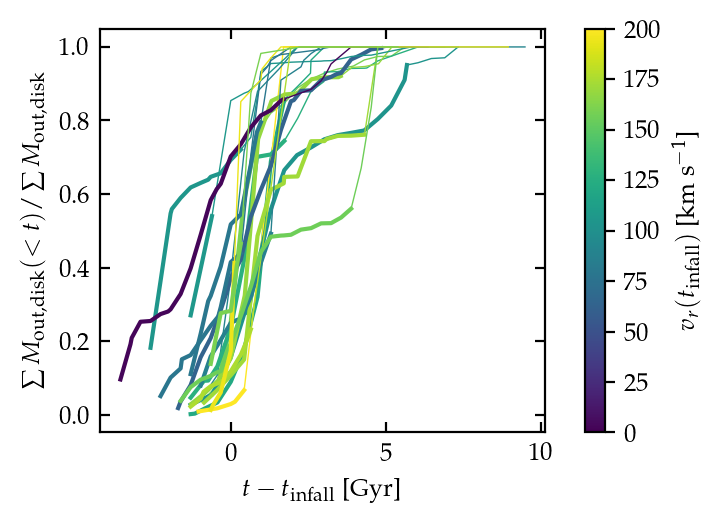

In [25]:
fig, ax = plt.subplots(1,1,figsize=(3.5, 2.5), dpi=200, constrained_layout=True)

cmap = mpl.cm.get_cmap('viridis')

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    d = d.sort_values('t')
    
    ts = read_timescales()
    ts = ts[(ts.sim==key[:4])&(ts.haloid==int(key[5:]))]
    tau = float(ts.tinfall-ts.tquench)
    tinfall = age - float(ts.tinfall)
    tquench = age - float(ts.tquench)
    
    ip = read_infall_properties()
    ip = ip[(ip.sim==key[:4])&(ip.haloid==int(key[5:]))]
    
    c = float(-ip.v_r) 
    vmin, vmax = 0, 200
    
    x = d.t-tinfall
    y = np.nancumsum(d.M_expelled_disk)/np.sum(d.M_expelled_disk)  
    q = d.t > d.tquench
    
    ax.plot(x, y, color=cmap((c-vmin)/(vmax-vmin)), linewidth=0.5)
    ax.plot(x[~q], y[~q], color=cmap((c-vmin)/(vmax-vmin)), linewidth=1.5)
    


cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                    ax=ax, label=r'$v_r(t_{\rm infall})$ [km~s$^{-1}$]')
cbar.ax.tick_params(direction='out',which='both')



ax.set_xlabel(r'$t-t_{\rm infall}$ [Gyr]')
ax.set_ylabel(r'$\sum M_{\rm out,disk}(<t)/\sum M_{\rm out,disk}$')
plt.show()

13 h148_12
11 h148_249
17 h148_251
4 h148_27
26 h148_282
1 h148_34
12 h148_38
4 h148_55
21 h148_65
1 h229_14
21 h229_18
18 h229_20
22 h229_22
15 h229_49
11 h242_21
5 h242_38
3 h242_69
33 h329_117
18 h329_29


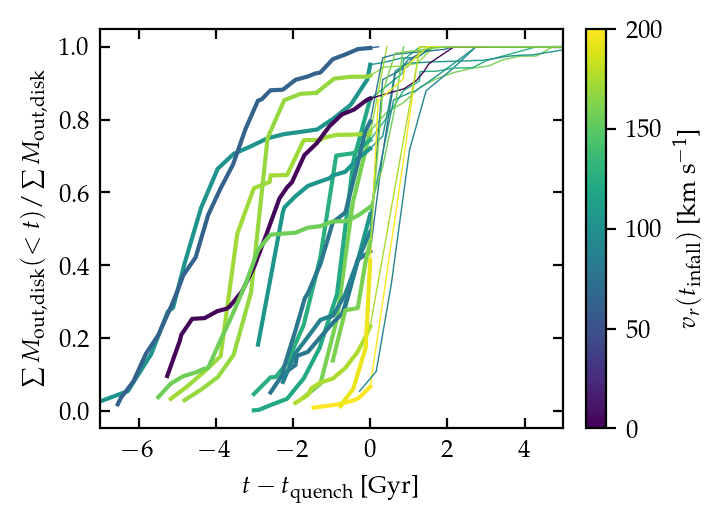

In [12]:
fig, ax = plt.subplots(1,1,figsize=(3.5, 2.5), dpi=200, constrained_layout=True)

cmap = mpl.cm.get_cmap('viridis')

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    d = d.sort_values('t')
    
    ts = read_timescales()
    ts = ts[(ts.sim==key[:4])&(ts.haloid==int(key[5:]))]
    tau = float(ts.tinfall-ts.tquench)
    tinfall = age - float(ts.tinfall)
    tquench = age - float(ts.tquench)
    
    ip = read_infall_properties()
    ip = ip[(ip.sim==key[:4])&(ip.haloid==int(key[5:]))]
    
    c = float(-ip.v_r) 
    vmin, vmax = 0, 200
    
    x = d.t-tquench
    y = np.nancumsum(d.M_expelled_disk)/np.sum(d.M_expelled_disk)  
    q = d.t > d.tquench
    print(len(q[q]), key)
    
    ax.plot(x, y, color=cmap((c-vmin)/(vmax-vmin)), linewidth=0.5)
    ax.plot(x[~q], y[~q], color=cmap((c-vmin)/(vmax-vmin)), linewidth=1.5)
    


cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                    ax=ax, label=r'$v_r(t_{\rm infall})$ [km~s$^{-1}$]')
cbar.ax.tick_params(direction='out',which='both')


ax.set_xlim(-7,5)
ax.set_xlabel(r'$t-t_{\rm quench}$ [Gyr]')
ax.set_ylabel(r'$\sum M_{\rm out,disk}(<t)/\sum M_{\rm out,disk}$')
plt.savefig('plots/cumulative_Mout_time.pdf')
plt.show()

In [14]:
ip.v_r/ip.v_rel

1   -0.705514
dtype: float64

In [12]:
data = read_tracked_particles('h148',282)
data.keys()
    

Index(['time', 'pid', 'rho', 'temp', 'mass', 'coolontime', 'r', 'r_per_Rvir',
       'x', 'y', 'z', 'satRvir', 'a', 'vx', 'vy', 'vz', 'v', 'r_rel_host',
       'r_rel_host_per_Rvir', 'x_rel_host', 'y_rel_host', 'z_rel_host',
       'hostRvir', 'vx_rel_host', 'vy_rel_host', 'vz_rel_host', 'v_rel_host',
       'sat_Xc', 'sat_Yc', 'sat_Zc', 'sat_vx', 'sat_vy', 'sat_vz', 'host_Xc',
       'host_Yc', 'host_Zc', 'host_vx', 'host_vy', 'host_vz', 'sat_Mstar',
       'sat_Mgas', 'host_Mstar', 'host_Mgas', 'sat_r_half', 'sat_r_gas',
       'host_r_half', 'host_r_gas', 'in_sat', 'in_host', 'in_other_sat',
       'in_IGM', 'dt', 'r_gal', 'host_r_gal', 'sat_disk', 'sat_halo',
       'host_disk', 'host_halo', 'other_sat', 'IGM'],
      dtype='object')

In [18]:
for key in np.unique(data_all.key):
    d = data_all[data_all.key=key]
    t = np.array(d.t)
    h1dist = np.array(d.h1dist)
    print(f'{key}, {h1dist[np.argmin(t)]:,2f}')

SyntaxError: invalid syntax (<ipython-input-18-abd93306207a>, line 2)

In [1]:
data = pd.read_hdf('../../Data/tracked_particles.hdf5', key='h148_282')
np.unique(data.time)

NameError: name 'pd' is not defined

In [2]:
from analysis import *

In [3]:
data = read_ram_pressure('h148',282)
data[['t','sSFR','M_gas','h1dist','hostRvir']]

Returning (expelled, accreted) for h148-282...


t         sSFR               M_gas      h1dist    hostRvir
0    3.457268  7.11084e-10  196066181.41885316  203.912208   79.835880
1    3.888249  2.56655e-10  184943407.58933532  152.986713   95.646244
2    4.282192  4.39834e-10  119943865.89846405   86.323152  112.413367
3    4.750210          0.0   33438086.75603907   68.799583  126.809222
4    5.181190          0.0  13280482.065001586  126.081508  136.730159
5    5.868065          0.0                 0.0  145.241142  144.587569
6    6.474131          0.0                 0.0  122.979329  156.773659
7    6.905111          0.0                 0.0   75.304145  164.773772
8    7.039793          0.0                 0.0   57.714994  167.197539
9    7.336092          0.0                 0.0   59.377587  171.710999
10   7.767072          0.0                 0.0  113.527392  179.248466
11   8.198053          0.0                 0.0  138.588447  193.394946
12   8.608831          0.0                 0.0  139.246468  203.352130
13   9.060013          0.0                 0.0  108.594822  212.325915
14   9.490994          0.0                 0.0   61.186154  219.545336
15   9.921974          0.0                 0.0  110.420094  225.234444
16  10.352954          0.0                 0.0  163.307276  228.679719
17  10.767100          0.0                 0.0  187.295149  233.374132
18  10.783935          0.0                 0.0  187.578939  233.553929
19  11.214915          0.0                 0.0  180.112437  237.833200
20  11.645896          0.0                 0.0  152.801200  241.905989
21  12.076876          0.0                 0.0  106.196139  246.371563
22  12.150951          0.0                 0.0   97.331157  247.223971
23  12.507856          0.0                 0.0   70.864693  252.524628
24  12.938837          0.0                 0.0  109.349385  259.191981
25  13.369817          0.0                 0.0  155.153482  262.030874
26  13.800797          0.0                 0.0  181.458121  266.078681

In [7]:
data = pd.read_hdf('../../Data/ram_pressure.hdf5', key='h148_282')
np.unique(data.t)

array([ 4.75020951,  5.18118989,  5.86806487,  6.47413103,  6.90511141,
        7.03979278,  7.33609179,  7.76707217,  8.19805255,  8.60883073,
        9.06001331,  9.49099369,  9.92197407, 10.35295445, 10.76709966,
       10.78393483, 11.21491521, 11.6458956 , 12.07687598, 12.15095073,
       12.50785636, 12.93883674, 13.36981712, 13.8007975 ])

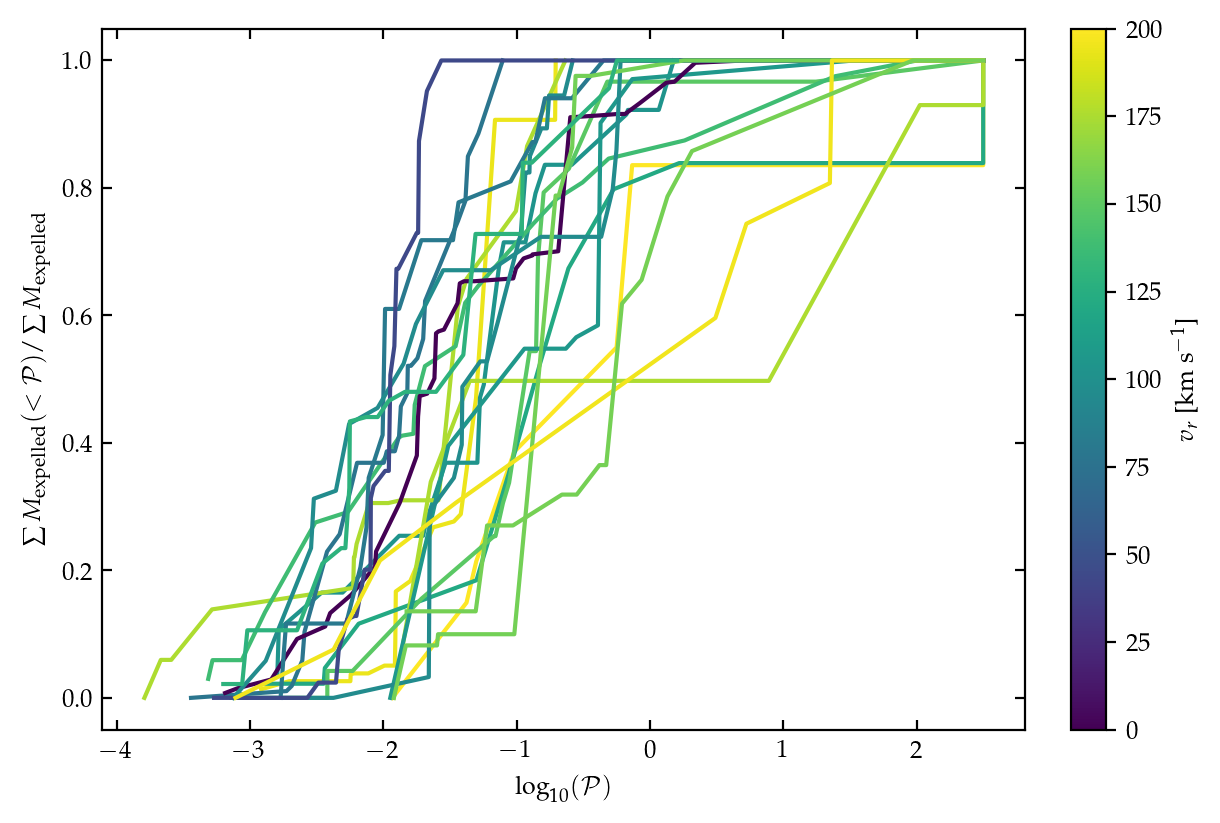

In [17]:
fig, ax = plt.subplots(1,1,dpi=200)

cmap = mpl.cm.get_cmap('viridis')

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    d = d.sort_values('ratio')

    ts = read_timescales()
    ts = ts[(ts.sim==key[:4])&(ts.haloid==int(key[5:]))]
    tau = float(ts.tinfall-ts.tquench)
    
    ip = read_infall_properties()
    ip = ip[(ip.sim==key[:4])&(ip.haloid==int(key[5:]))]
    
    c = float(-ip.v_r) 
    vmin, vmax = 0, 200
    
    x = np.log10(d.ratio)
    y = np.nancumsum(d.M_expelled-d.M_expelled_disk)/np.sum(d.M_expelled-d.M_expelled_disk)
    x[np.isinf(x)] = 2.5
    ax.plot(x, y, color=cmap((c-vmin)/(vmax-vmin)))
    

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                    ax=ax, label=r'$v_r$ [km~s$^{-1}$]')
cbar.ax.tick_params(direction='out',which='both')


ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'$\sum M_{\rm expelled}(<\mathcal{P})/\sum M_{\rm expelled}$')
plt.show()

h148_13 193.8657249724246
h148_278 201.0366444409515
h148_28 103.51716191907508
h148_283 120.47870169523944
h148_329 175.1366312328802
h148_37 175.2817761889388
h148_45 149.14803046872802
h148_68 137.8164061011883
h148_80 106.57201266901593
h229_20 77.61717165175187
h229_22 -12.100285455980032
h229_23 96.05763096132753
h229_27 80.48563683086567
h229_55 96.76153362337612
h242_24 43.819047670659465
h242_41 157.1642034350649
h242_80 128.8183059994925
h329_137 195.35379293791988
h329_33 158.40858675839533


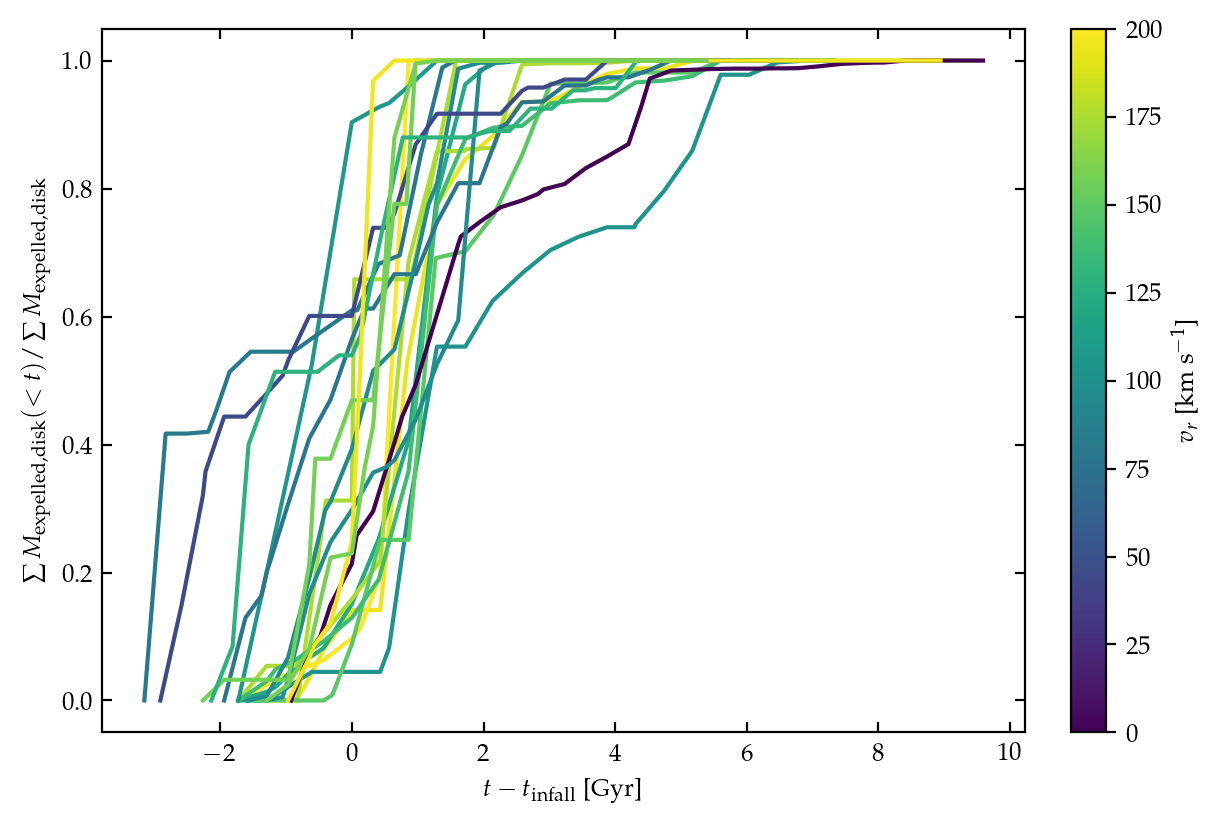

In [4]:
fig, ax = plt.subplots(1,1,dpi=200)

cmap = mpl.cm.get_cmap('viridis')

for key in np.unique(data_all.key):
    #if not key in ['h148_278']: continue;
    d = data_all[data_all.key==key]
    d = d.sort_values('t')
    
    ts = read_timescales()
    ts = ts[(ts.sim==key[:4])&(ts.haloid==int(key[5:]))]
    tau = float(ts.tinfall-ts.tquench)
    tinfall = age - float(ts.tinfall)
        
    ip = read_infall_properties()
    ip = ip[(ip.sim==key[:4])&(ip.haloid==int(key[5:]))]
    
    c = float(-ip.v_r) 
    print(key, c)
    vmin, vmax = 0, 200
    
    x = d.t-tinfall
    y = np.nancumsum(d.M_expelled_disk)/np.sum(d.M_expelled_disk)
    x[np.isinf(x)] = 2.5
    
    #y = d.sSFR
    
    ax.plot(x, y, color=cmap((c-vmin)/(vmax-vmin)))
    

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                    ax=ax, label=r'$v_r$ [km s$^{-1}$]')
cbar.ax.tick_params(direction='out',which='both')


ax.set_xlabel(r'$t-t_{\rm infall}$ [Gyr]')
ax.set_ylabel(r'$\sum M_{\rm expelled,disk}(<t)/\sum M_{\rm expelled,disk}$')
plt.show()

In [10]:
d.keys()

Index(['t', 'a', 'h1dist', 'dNN', 'M_star', 'M_gas', 'satRvir', 'hostRvir',
       'vel_CGM', 'rho_CGM', 'Pram', 'n_CGM', 'vel_CGM_adv', 'rho_CGM_adv',
       'std_vel_CGM', 'std_rho_CGM', 'Pram_adv', 'Prest', 'SigmaGas', 'dphidz',
       'SFR', 'sSFR', 'ratio', 'ratio_prev', 'dt', 'tau', 'tquench',
       'Mgas_div', 'time_x', 'M_SNeaff', 'time_y', 'M_disk', 'Mdisk_div',
       'time_x', 'M_ejected', 'Mdot_ejected', 'Mdot_ejected_by_Mgas',
       'Mdot_ejected_by_Mdisk', 'time_y', 'M_cooled', 'Mdot_cooled',
       'Mdot_cooled_by_Mgas', 'Mdot_cooled_by_Mdisk', 'time_x', 'M_expelled',
       'Mdot_expelled', 'Mdot_expelled_by_Mgas', 'time_y', 'M_expelled_disk',
       'Mdot_expelled_disk', 'Mdot_expelled_disk_by_Mgas',
       'Mdot_expelled_disk_by_Mdisk', 'time_x', 'M_expelled_th30',
       'Mdot_expelled_th30', 'Mdot_expelled_th30_by_Mgas', 'time_y',
       'M_accreted', 'Mdot_accreted', 'Mdot_accreted_by_Mgas', 'time',
       'M_accreted_disk', 'Mdot_accreted_disk', 'Mdot_accreted_d

/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

h148_13 193.8657249724246
h148_278 201.0366444409515
h148_28 103.51716191907508
h148_283 120.47870169523944
h148_329 175.1366312328802
h148_37 175.2817761889388
h148_45 149.14803046872802
h148_68 137.8164061011883
h148_80 106.57201266901593
h229_20 77.61717165175187
h229_22 -12.100285455980032
h229_23 96.05763096132753


/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

h229_27 80.48563683086567
h229_55 96.76153362337612
h242_24 43.819047670659465
h242_41 157.1642034350649
h242_80 128.8183059994925
h329_137 195.35379293791988
h329_33 158.40858675839533


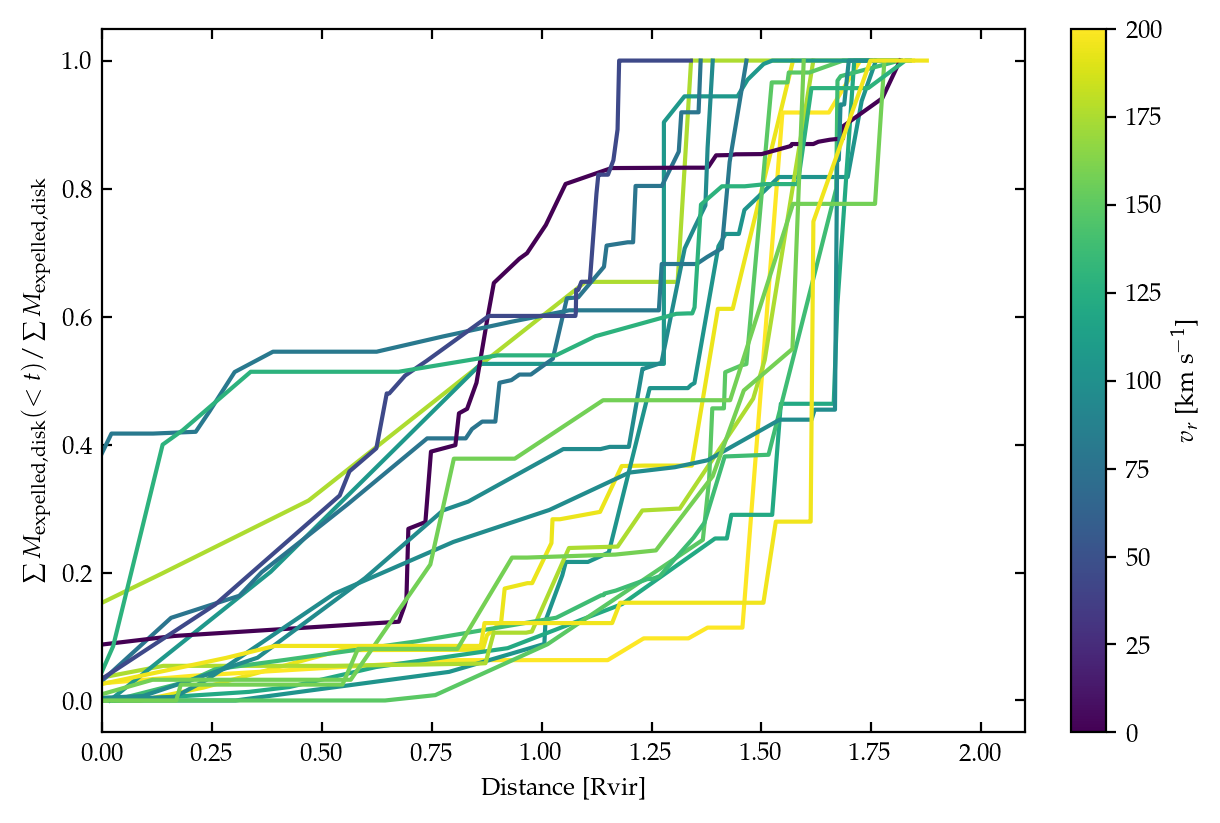

In [14]:
fig, ax = plt.subplots(1,1,dpi=200)

cmap = mpl.cm.get_cmap('viridis')

for key in np.unique(data_all.key):
    #if not key in ['h148_278']: continue;
    d = data_all[data_all.key==key]
    d['h1dist_rvir'] = 2-d.h1dist/d.hostRvir
    d = d.sort_values('h1dist_rvir')
    
    ts = read_timescales()
    ts = ts[(ts.sim==key[:4])&(ts.haloid==int(key[5:]))]
    tau = float(ts.tinfall-ts.tquench)
    tinfall = age - float(ts.tinfall)
        
    ip = read_infall_properties()
    ip = ip[(ip.sim==key[:4])&(ip.haloid==int(key[5:]))]
    
    c = float(-ip.v_r) 
    print(key, c)
    vmin, vmax = 0, 200
    
    x = d.h1dist_rvir
    y = np.nancumsum(d.M_expelled_disk)/np.sum(d.M_expelled_disk)
    #x[np.isinf(x)] = 2.5
    
    #y = d.sSFR
    
    ax.plot(x, y, color=cmap((c-vmin)/(vmax-vmin)))
    

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                    ax=ax, label=r'$v_r$ [km s$^{-1}$]')
cbar.ax.tick_params(direction='out',which='both')

ax.set_xlim(0, 2.1)
ax.set_xlabel(r'Distance [Rvir]')
ax.set_ylabel(r'$\sum M_{\rm expelled,disk}(<t)/\sum M_{\rm expelled,disk}$')
plt.show()

In [69]:
ejected, cooled, expelled, accreted = read_ejected_expelled('h148',278)
expelled.groupby(['time'])['mass'].sum().reset_index()

Returning (ejected, cooled, expelled, accreted) for h148-278...


time          mass
0  5.868065  1.581404e+07
1  6.474131  7.341660e+06
2  6.905111  1.754506e+07
3  7.039793  1.574344e+07
4  7.336092  3.072958e+07
5  7.767072  6.564540e+07

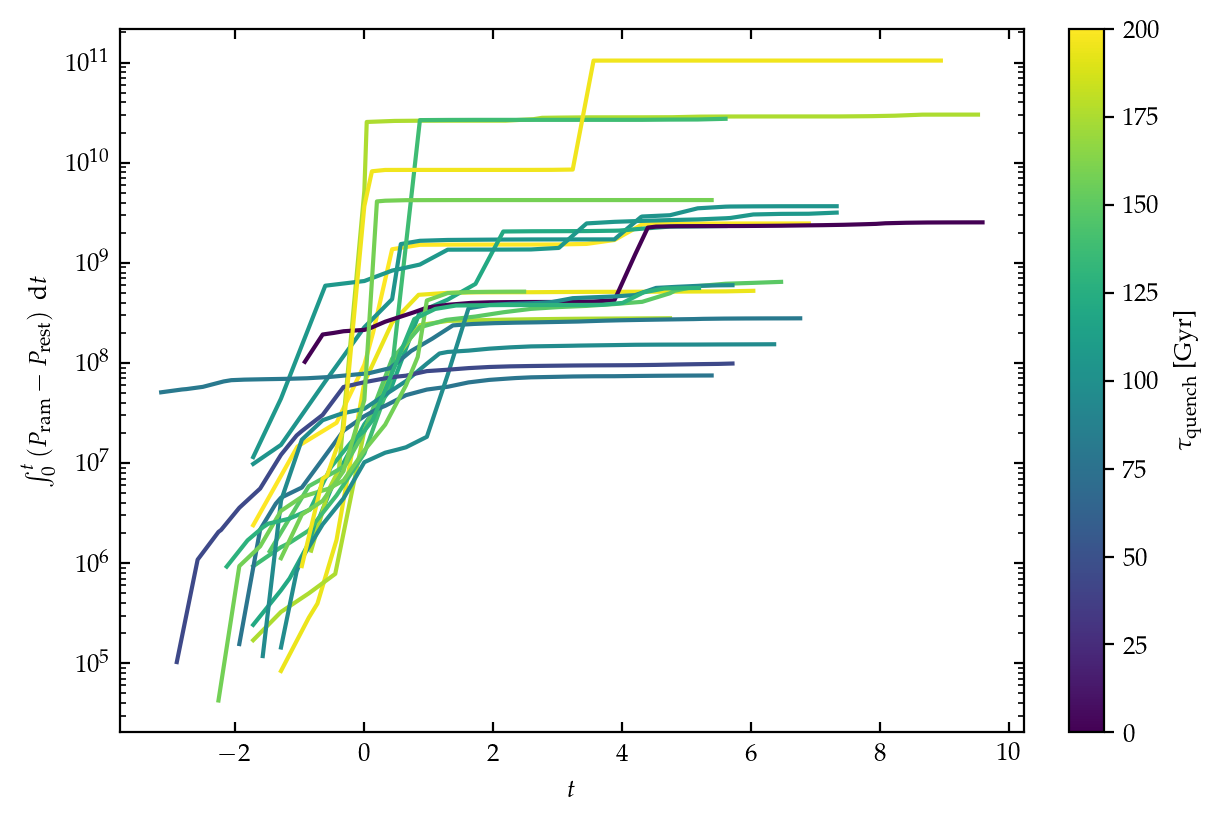

In [20]:
fig, ax = plt.subplots(1,1,dpi=200)

cmap = mpl.cm.get_cmap('viridis')

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    
    ts = read_timescales()
    ts = ts[(ts.sim==key[:4])&(ts.haloid==int(key[5:]))]
    tau = float(ts.tinfall-ts.tquench)
    tinfall = age - float(ts.tinfall)
    
    ip = read_infall_properties()
    ip = ip[(ip.sim==key[:4])&(ip.haloid==int(key[5:]))]
    
    c = float(-ip.v_r) 
    vmin, vmax = 0, 200
    
    d.sort_values('t')

    dt = np.array(d.t)[1:] - np.array(d.t)[:-1]
    dt = np.append(dt[0], dt)
    
    x = d.t-tinfall
    y = np.nancumsum((d.Pram_adv)*dt)
    #x[np.isinf(x)] = 2.5
    ax.plot(x, y, color=cmap((c-vmin)/(vmax-vmin)))
    

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                    ax=ax, label=r'$\tau_{\rm quench}$ [Gyr]')
cbar.ax.tick_params(direction='out',which='both')

ax.semilogy()
# ax.set_ylim(1e6, 2e11)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\int_0^t \left(P_{\rm ram}-P_{\rm rest}\right)~{\rm d}t$')
plt.show()

In [25]:
d.Prest

0     1.039095e+08
1     9.977123e+07
2     2.339967e+08
3     5.800490e+07
4     1.719284e+08
5     2.219619e+08
6     3.902123e+08
7     7.664032e+07
8     4.100052e+07
9     1.305834e+07
10    1.131927e+07
11    3.695263e+06
12    1.940804e+06
13    1.467848e+06
14    7.102490e+05
15    3.662421e+05
16    0.000000e+00
17    0.000000e+00
18    0.000000e+00
19    0.000000e+00
20    0.000000e+00
21    0.000000e+00
22    0.000000e+00
23    0.000000e+00
24    0.000000e+00
Name: Prest, dtype: float64

In [4]:
data_all.t

0      6.474131
1      6.905111
2      7.039793
3      7.336092
4      7.767072
        ...    
34    12.615601
35    12.938837
36    13.262072
37    13.585307
38    13.800797
Name: t, Length: 512, dtype: float64

array([0.12049159, 0.12049159, 0.12733269, 0.24414307, 0.24681033,
       0.25810062, 0.31187658, 0.31475062, 0.32515052, 0.3747294 ,
       0.39970165, 0.6158534 , 0.64816719, 0.7651023 , 0.8653581 ,
       0.99811986, 0.99832877, 0.99853767, 0.99874658, 0.99895548,
       0.99916438, 0.99937329, 0.99958219, 0.9997911 , 1.        ])

## Fraction of gas mass expelled at different ram pressure ratios, and expulsion probabilities <a class="anchor" id="expulsion-prob"></a>

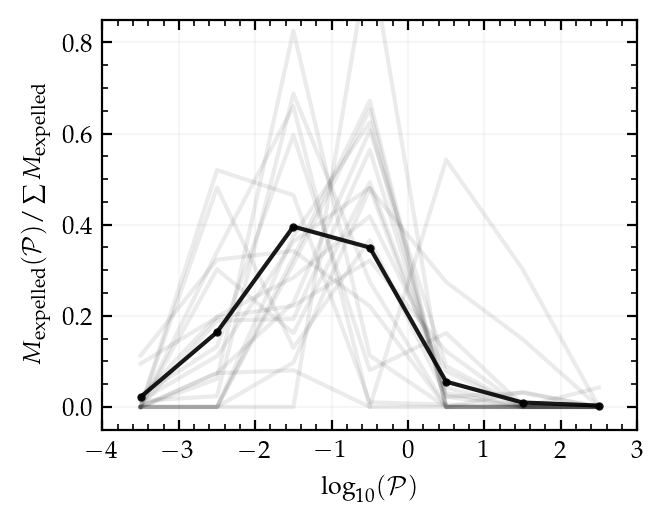

In [47]:
import scipy.stats

fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.2,2.5), constrained_layout=True)

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    x = np.log10(d.ratio)
    y = d.M_expelled
    cond = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isinf(x)) & (~np.isinf(y))
    BigSum = np.sum(y[cond])
    Sum, bins, binnumber = scipy.stats.binned_statistic(x[cond], y[cond], statistic='sum', bins=np.arange(-4, 4, 1))
    bc = 0.5*(bins[1:]+bins[:-1])
    ax.plot(bc, Sum/BigSum, 'k-', ms=2, alpha=0.08)

x = np.log10(data_all.ratio)
y = data_all.M_expelled
cond = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isinf(x)) & (~np.isinf(y))
BigSum = np.sum(y[cond])
Sum, bins, binnumber = scipy.stats.binned_statistic(x[cond], y[cond], statistic='sum', bins=np.arange(-4, 4, 1))
bc = 0.5*(bins[1:]+bins[:-1])
im = ax.plot(bc, Sum/BigSum, 'ko-', ms=2, alpha=0.9)
    
ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'$M_{\rm expelled}(\mathcal{P})/\sum M_{\rm expelled}$')
ax.set_xlim(-4, 3)
ax.set_ylim(-0.05, 0.85)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)

# plt.savefig('plots/fraction_expelled_by_Pram.pdf')
plt.show()

This is roughly equivalent to just a histogram of the number of snapshots we observe at different $\mathcal{P}$. However, we see less mass expulsion between -3 and -2, and more between -1 and 0, than we would expect from the histogram.

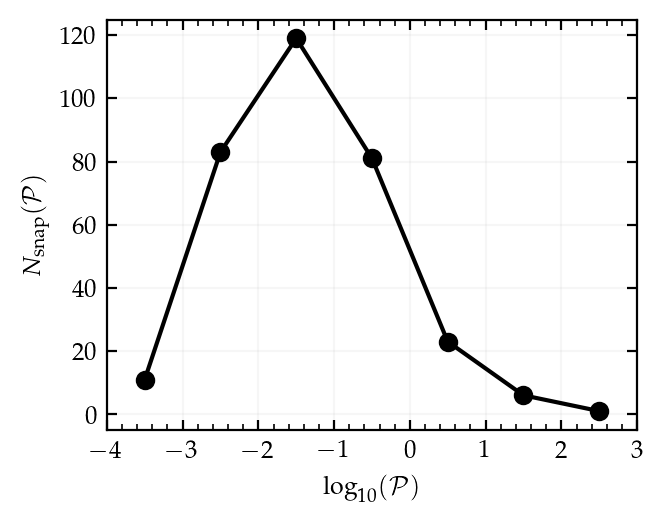

In [48]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.2,2.5), constrained_layout=True)

N, bins = np.histogram(np.log10(data_all.ratio), bins=np.arange(-4, 4, 1))
bc = 0.5*(bins[1:]+bins[:-1])
im = ax.plot(bc, N, 'ko-')
ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'$N_{\rm snap}(\mathcal{P})$')
ax.set_xlim(-4, 3)
# ax.set_ylim(-0.05, 0.85)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.grid(alpha=0.1, zorder=-1000)
plt.show()

The different shapes of these two curves is a result of the different probability of expulsion at different ram pressure ratios. We can calculate that probability as the number of particles that have just been expelled, at some time $t_2$, divided by the number of particles in the satellite at the previous snapshot of time $t_1$. 

In [50]:
import warnings
warnings.filterwarnings("ignore")

ratios, N_e, N_p, E_prob = np.array([]),np.array([]),np.array([]),np.array([])
ratios_disk, N_e_disk, N_p_disk, E_prob_disk = np.array([]),np.array([]),np.array([]),np.array([])
ratios_sne, N_e_sne, N_p_sne, E_prob_sne = np.array([]),np.array([]),np.array([]),np.array([])

for key in np.unique(data_all.key):
    print(key, end=' ')
    d = data_all[data_all.key==key]
    
    # full satellite
    expelled = pd.read_hdf(f'../../Data/expelled_particles.hdf5', key=key)
    particles = read_tracked_particles(key[:4],int(key[5:]))
    particles = particles[particles.in_sat]
    
    expelled_grp = expelled.groupby(['time']).pid.count().reset_index()
    expelled_grp = expelled_grp.rename(columns={'pid':'N_e'})
    particles_grp = particles.groupby(['time']).pid.count().reset_index()
    particles_grp = particles_grp.rename(columns={'pid':'N_p'})
    
    d = pd.merge(d.sort_values('t'), expelled_grp.sort_values('time'), left_on='t', right_on='time', how='left')
    d = pd.merge(d.sort_values('t'), particles_grp.sort_values('time'), left_on='t', right_on='time', how='left')

    times = np.unique(d.t)
    ratios1 = np.array(d.ratio)
    N_e1 = np.array(d.N_e)[1:]
    N_p1 = np.array(d.N_p)[:-1]
    E_prob1 = N_e1/N_p1
    ratios1 = ratios1[1:]
    
    ratios = np.append(ratios,ratios1)
    N_e = np.append(N_e, N_e1)
    N_p = np.append(N_p, N_p1)
    E_prob = np.append(E_prob, E_prob1)
    
    # disk
    d = data_all[data_all.key==key]
    expelled = pd.read_hdf(f'../../Data/expelled_particles.hdf5', key=key)
    expelled = expelled[expelled.state1=='sat_disk']
    particles = read_tracked_particles(key[:4],int(key[5:]))
    particles = particles[particles.sat_disk]

    expelled_grp = expelled.groupby(['time']).pid.count().reset_index()
    expelled_grp = expelled_grp.rename(columns={'pid':'N_e'})
    particles_grp = particles.groupby(['time']).pid.count().reset_index()
    particles_grp = particles_grp.rename(columns={'pid':'N_p'})
    
    d = pd.merge(d.sort_values('t'), expelled_grp.sort_values('time'), left_on='t', right_on='time', how='left')
    d = pd.merge(d.sort_values('t'), particles_grp.sort_values('time'), left_on='t', right_on='time', how='left')

    times = np.unique(d.t)
    ratios1 = np.array(d.ratio)
    N_e1 = np.array(d.N_e)[1:]
    N_p1 = np.array(d.N_p)[:-1]
    E_prob1 = N_e1/N_p1
    ratios1 = ratios1[1:]
    
    ratios_disk = np.append(ratios_disk,ratios1)
    N_e_disk = np.append(N_e_disk, N_e1)
    N_p_disk = np.append(N_p_disk, N_p1)
    E_prob_disk = np.append(E_prob_disk, E_prob1)
    
    
    # SNe-affected, currently or in last {t_thresh} Gyr
    t_thresh = 0.5 
    
    d = data_all[data_all.key==key]
    expelled = pd.read_hdf(f'../../Data/expelled_particles.hdf5', key=key)
    expelled = expelled[expelled.coolontime > expelled.time - t_thresh]
    particles = read_tracked_particles(key[:4],int(key[5:]))
    particles = particles[(particles.in_sat)&(particles.coolontime > particles.time - t_thresh)]

    expelled_grp = expelled.groupby(['time']).pid.count().reset_index()
    expelled_grp = expelled_grp.rename(columns={'pid':'N_e'})
    particles_grp = particles.groupby(['time']).pid.count().reset_index()
    particles_grp = particles_grp.rename(columns={'pid':'N_p'})
    
    d = pd.merge(d.sort_values('t'), expelled_grp.sort_values('time'), left_on='t', right_on='time', how='left')
    d = pd.merge(d.sort_values('t'), particles_grp.sort_values('time'), left_on='t', right_on='time', how='left')

    times = np.unique(d.t)
    ratios1 = np.array(d.ratio)
    N_e1 = np.array(d.N_e)[1:]
    N_p1 = np.array(d.N_p)[:-1]
    E_prob1 = N_e1/N_p1
    ratios1 = ratios1[1:]
    
    ratios_sne = np.append(ratios_sne,ratios1)
    N_e_sne = np.append(N_e_sne, N_e1)
    N_p_sne = np.append(N_p_sne, N_p1)
    E_prob_sne = np.append(E_prob_sne, E_prob1)

h148_12 h148_249 h148_251 h148_27 h148_282 h148_34 h148_38 h148_55 h148_65 h229_14 h229_18 h229_20 h229_22 h229_49 h242_21 h242_38 h242_69 h329_117 h329_29 

In [51]:
cond = ~np.isnan(E_prob) & ~np.isinf(E_prob)
ratios = ratios[cond]
N_e = N_e[cond]
N_p = N_p[cond]
E_prob = E_prob[cond]

cond_disk = ~np.isnan(E_prob_disk) & ~np.isinf(E_prob_disk)
ratios_disk = ratios_disk[cond_disk]
N_e_disk = N_e_disk[cond_disk]
N_p_disk = N_p_disk[cond_disk]
E_prob_disk = E_prob_disk[cond_disk]

cond_sne = ~np.isnan(E_prob_sne) & ~np.isinf(E_prob_sne)
ratios_sne = ratios_sne[cond_sne]
N_e_sne = N_e_sne[cond_sne]
N_p_sne = N_p_sne[cond_sne]
E_prob_sne = E_prob_sne[cond_sne]

In [52]:
bins = np.append(np.arange(-4,2,1),2.2)
bc = 0.5*(bins[1:] + bins[:-1])
E_prob_median, E_prob_weighted, E_prob_weighted_log, std = np.array([]),np.array([]),np.array([]),np.array([])
E_prob_median_disk, E_prob_weighted_disk, E_prob_weighted_log_disk, std_disk = np.array([]),np.array([]),np.array([]),np.array([])
E_prob_median_sne, E_prob_weighted_sne, E_prob_weighted_log_sne, std_sne = np.array([]),np.array([]),np.array([]),np.array([])

for left_edge, right_edge in zip(bins[:-1],bins[1:]):
    cond = (np.log10(ratios) >= left_edge) & (np.log10(ratios) < right_edge)
    E_prob_weighted = np.append(E_prob_weighted,np.average(E_prob[cond], weights=N_p[cond]))
    E_prob_weighted_log = np.append(E_prob_weighted_log,np.average(E_prob[cond], weights=np.log10(N_p)[cond]))
    E_prob_median = np.append(E_prob_median,np.median(E_prob[cond]))
    std = np.append(std, np.std(E_prob[cond]))
    
    cond = (np.log10(ratios_disk) >= left_edge) & (np.log10(ratios_disk) < right_edge)
    E_prob_weighted_disk = np.append(E_prob_weighted_disk,np.average(E_prob_disk[cond], weights=N_p_disk[cond]))
    E_prob_weighted_log_disk = np.append(E_prob_weighted_log_disk,np.average(E_prob_disk[cond], weights=np.log10(N_p_disk)[cond]))
    E_prob_median_disk = np.append(E_prob_median_disk,np.median(E_prob_disk[cond]))
    std_disk = np.append(std_disk, np.std(E_prob_disk[cond]))
    
    
    cond = (np.log10(ratios_sne) >= left_edge) & (np.log10(ratios_sne) < right_edge)
    E_prob_weighted_sne = np.append(E_prob_weighted_sne,np.average(E_prob_sne[cond], weights=N_p_sne[cond]))
    E_prob_weighted_log_sne = np.append(E_prob_weighted_log_sne,np.average(E_prob_sne[cond], weights=np.log10(N_p_sne)[cond]))
    E_prob_median_sne = np.append(E_prob_median_sne,np.median(E_prob_sne[cond]))
    std_sne = np.append(std_sne, np.std(E_prob_sne[cond]))

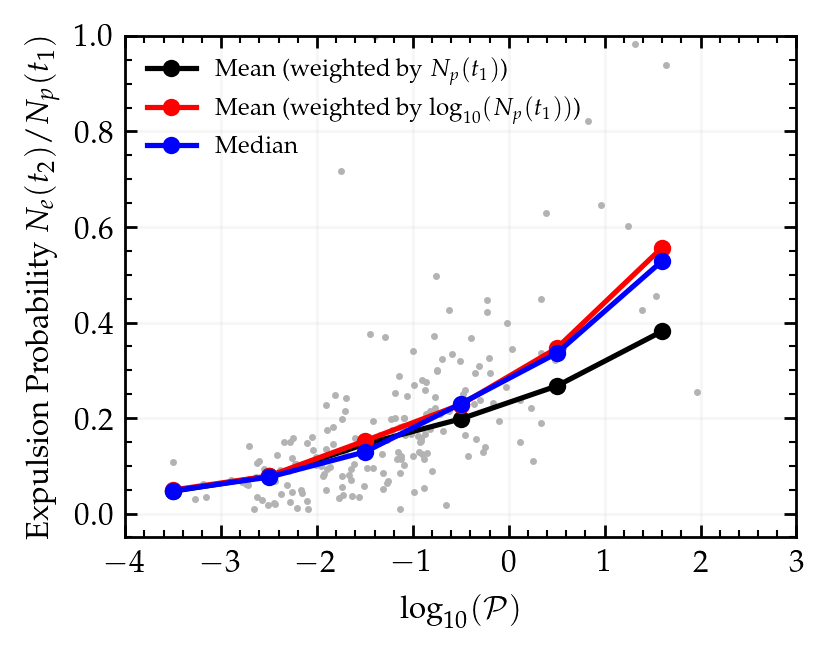

In [53]:
fig, ax = plt.subplots(1,1,dpi=250, figsize=(3.2,2.5), constrained_layout=True)

ax.scatter(np.log10(ratios), E_prob, c='0.7', s=1)
ax.plot(bc, E_prob_weighted, 'ko-', ms=4, label=r'Mean (weighted by $N_p(t_1)$)')
ax.plot(bc, E_prob_weighted_log, 'ro-', ms=4, label=r'Mean (weighted by $\log_{10}(N_p(t_1))$)')
ax.plot(bc, E_prob_median, 'bo-', ms=4, label='Median')

ax.legend(frameon=False, fontsize=7)
ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'Expulsion Probability $N_{e}(t_2)/N_{p}(t_1)$')
ax.set_xlim(-4, 3)
ax.set_ylim(-0.05, 1)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)
plt.show()

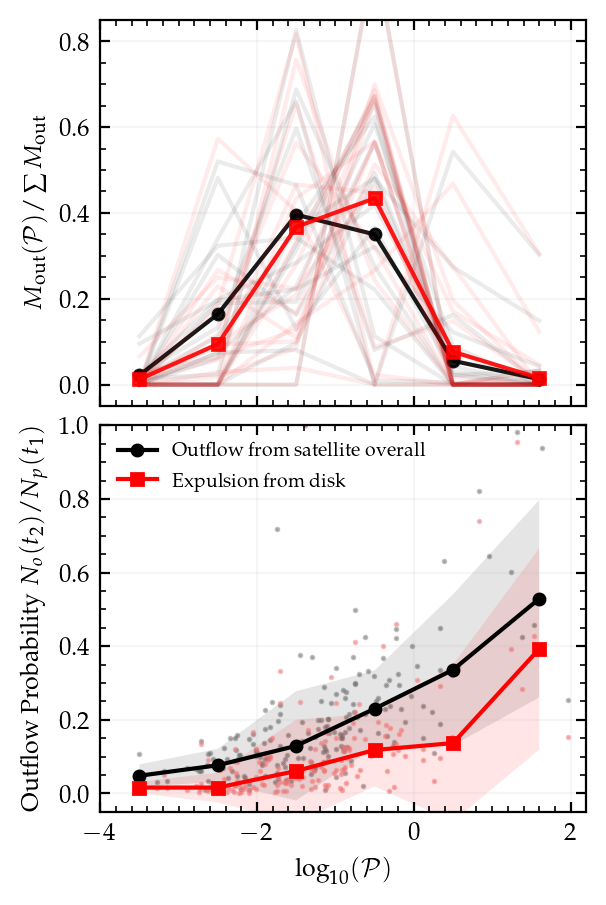

In [57]:
import scipy.stats 

bins_main = np.append(np.arange(-4,2,1),2.2)

fig, ax = plt.subplots(2,1,dpi=200, figsize=(3,4.5), sharex=True, constrained_layout=False)

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    x = np.log10(d.ratio)
    y = d.M_expelled
    cond = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isinf(x)) & (~np.isinf(y))
    BigSum = np.sum(y[cond])
    Sum, bins, binnumber = scipy.stats.binned_statistic(x[cond], y[cond], statistic='sum', bins=bins_main)
    bc = 0.5*(bins[1:]+bins[:-1])
    ax[0].plot(bc, Sum/BigSum, 'k-', ms=2, alpha=0.08)

x = np.log10(data_all.ratio)
y = data_all.M_expelled
cond = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isinf(x)) & (~np.isinf(y))
BigSum = np.sum(y[cond])
Sum, bins, binnumber = scipy.stats.binned_statistic(x[cond], y[cond], statistic='sum', bins=bins_main)
bc = 0.5*(bins[1:]+bins[:-1])
im = ax[0].plot(bc, Sum/BigSum, 'ko-', ms=4, alpha=0.9)

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    x = np.log10(d.ratio)
    y = d.M_expelled_disk
    cond = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isinf(x)) & (~np.isinf(y))
    BigSum = np.sum(y[cond])
    Sum, bins, binnumber = scipy.stats.binned_statistic(x[cond], y[cond], statistic='sum', bins=bins_main)
    bc = 0.5*(bins[1:]+bins[:-1])
    ax[0].plot(bc, Sum/BigSum, 'r-', ms=2, alpha=0.08)

x = np.log10(data_all.ratio)
y = data_all.M_expelled_disk
cond = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isinf(x)) & (~np.isinf(y))
BigSum = np.sum(y[cond])
Sum, bins, binnumber = scipy.stats.binned_statistic(x[cond], y[cond], statistic='sum', bins=bins_main)
bc = 0.5*(bins[1:]+bins[:-1])
im = ax[0].plot(bc, Sum/BigSum, 'rs-', ms=4, alpha=0.9)

    
ax[0].set_ylabel(r'$M_{\rm out}(\mathcal{P})/\sum M_{\rm out}$')
ax[0].set_xlim(-4, 2.2)
ax[0].set_ylim(-0.05, 0.85)
ax[0].tick_params(direction='in', which='both', top=True, right=True)
ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[0].grid(alpha=0.1, zorder=-1000)

bins = bins_main
bc = 0.5*(bins[1:] + bins[:-1])
E_prob_median, E_prob_weighted, E_prob_weighted_log, std = np.array([]),np.array([]),np.array([]),np.array([])
E_prob_median_disk, E_prob_weighted_disk, E_prob_weighted_log_disk, std_disk = np.array([]),np.array([]),np.array([]),np.array([])
E_prob_median_sne, E_prob_weighted_sne, E_prob_weighted_log_sne, std_sne = np.array([]),np.array([]),np.array([]),np.array([])

for left_edge, right_edge in zip(bins[:-1],bins[1:]):
    cond = (np.log10(ratios) >= left_edge) & (np.log10(ratios) < right_edge)
    E_prob_weighted = np.append(E_prob_weighted,np.average(E_prob[cond], weights=N_p[cond]))
    E_prob_weighted_log = np.append(E_prob_weighted_log,np.average(E_prob[cond], weights=np.log10(N_p)[cond]))
    E_prob_median = np.append(E_prob_median,np.median(E_prob[cond]))
    std = np.append(std, np.std(E_prob[cond]))
    
    cond = (np.log10(ratios_disk) >= left_edge) & (np.log10(ratios_disk) < right_edge)
    E_prob_weighted_disk = np.append(E_prob_weighted_disk,np.average(E_prob_disk[cond], weights=N_p_disk[cond]))
    E_prob_weighted_log_disk = np.append(E_prob_weighted_log_disk,np.average(E_prob_disk[cond], weights=np.log10(N_p_disk)[cond]))
    E_prob_median_disk = np.append(E_prob_median_disk,np.median(E_prob_disk[cond]))
    std_disk = np.append(std_disk, np.std(E_prob_disk[cond]))
        
    cond = (np.log10(ratios_sne) >= left_edge) & (np.log10(ratios_sne) < right_edge)
    E_prob_weighted_sne = np.append(E_prob_weighted_sne,np.average(E_prob_sne[cond], weights=N_p_sne[cond]))
    E_prob_weighted_log_sne = np.append(E_prob_weighted_log_sne,np.average(E_prob_sne[cond], weights=np.log10(N_p_sne)[cond]))
    E_prob_median_sne = np.append(E_prob_median_sne,np.median(E_prob_sne[cond]))
    std_sne = np.append(std_sne, np.std(E_prob_sne[cond]))


# ax[1].scatter(np.log10(ratios_sne), E_prob_sne, c='lightblue', s=1, alpha=0.5)
# ax[1].fill_between(bc, E_prob_median_sne-std_sne, E_prob_median_sne+std_sne, color='b', ec=None, alpha=0.1)
# ax[1].plot(bc, E_prob_median_sne, 'bD-', ms=4, label=r'Expulsion of recently SNe-affected gas')
    
ax[1].scatter(np.log10(ratios), E_prob, c='0.5', s=1, alpha=0.5)
ax[1].fill_between(bc, E_prob_median-std, E_prob_median+std, color='k', ec=None, alpha=0.1)
ax[1].plot(bc, E_prob_median, 'ko-', ms=4, label=r'Outflow from satellite overall')

ax[1].scatter(np.log10(ratios_disk), E_prob_disk, c='lightcoral', s=1, alpha=0.5)
ax[1].fill_between(bc, E_prob_median_disk-std_disk, E_prob_median_disk+std_disk, color='r', ec=None, alpha=0.1)
ax[1].plot(bc, E_prob_median_disk, 'rs-', ms=4, label=r'Expulsion from disk')



ax[1].legend(frameon=False, fontsize=7)
ax[1].set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax[1].set_ylabel(r'Outflow Probability $N_{o}(t_2)/N_{p}(t_1)$')
ax[1].set_xlim(-4, 2.2)
ax[1].set_ylim(-0.05, 1)
ax[1].tick_params(direction='in', which='both', top=True, right=True)
ax[1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax[1].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[1].grid(alpha=0.1, zorder=-1000)

plt.subplots_adjust(hspace=0.05, top=0.98, right=0.98, bottom=0.1, left=0.17)
plt.savefig('plots/outflow_prob_by_Pram.pdf')
plt.show()

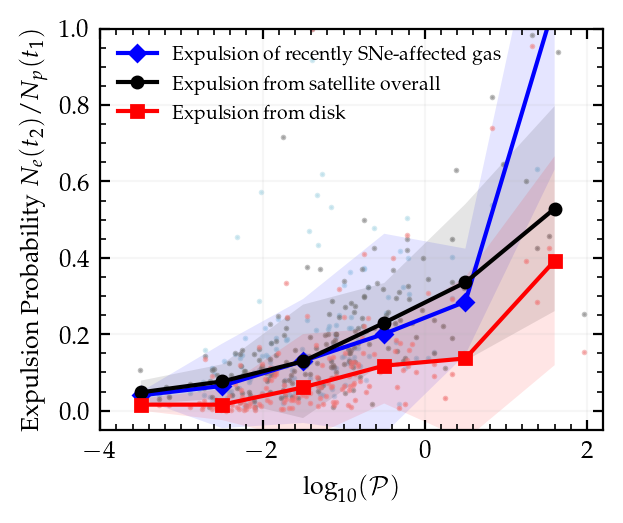

In [55]:
bins_main = np.append(np.arange(-4,2,1),2.2)

fig, ax = plt.subplots(1,1,dpi=200, figsize=(3,2.5), sharex=True)

ax.scatter(np.log10(ratios_sne), E_prob_sne, c='lightblue', s=1, alpha=0.5)
ax.fill_between(bc, E_prob_median_sne-std_sne, E_prob_median_sne+std_sne, color='b', ec=None, alpha=0.1)
ax.plot(bc, E_prob_median_sne, 'bD-', ms=4, label=r'Expulsion of recently SNe-affected gas')
    
ax.scatter(np.log10(ratios), E_prob, c='0.5', s=1, alpha=0.5)
ax.fill_between(bc, E_prob_median-std, E_prob_median+std, color='k', ec=None, alpha=0.1)
ax.plot(bc, E_prob_median, 'ko-', ms=4, label=r'Expulsion from satellite overall')

ax.scatter(np.log10(ratios_disk), E_prob_disk, c='lightcoral', s=1, alpha=0.5)
ax.fill_between(bc, E_prob_median_disk-std_disk, E_prob_median_disk+std_disk, color='r', ec=None, alpha=0.1)
ax.plot(bc, E_prob_median_disk, 'rs-', ms=4, label=r'Expulsion from disk')

ax.legend(frameon=False, fontsize=7)
ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'Expulsion Probability $N_{e}(t_2)/N_{p}(t_1)$')
ax.set_xlim(-4, 2.2)
ax.set_ylim(-0.05, 1)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)

plt.savefig('plots/expulsion_prob_SNe.pdf')
plt.show()

We see increasing expulsion probablity with increasing ram pressure ratio, as expected. But can we combine this with the histogram to get back out the fraction of mass expelled at different ram pressure ratios?

We calculate this as $N_{\rm snap}(\mathcal{P}) \times P_{\rm expelled}(\mathcal{P}) / \sum N_{\rm snap}\times P_{\rm expelled}$

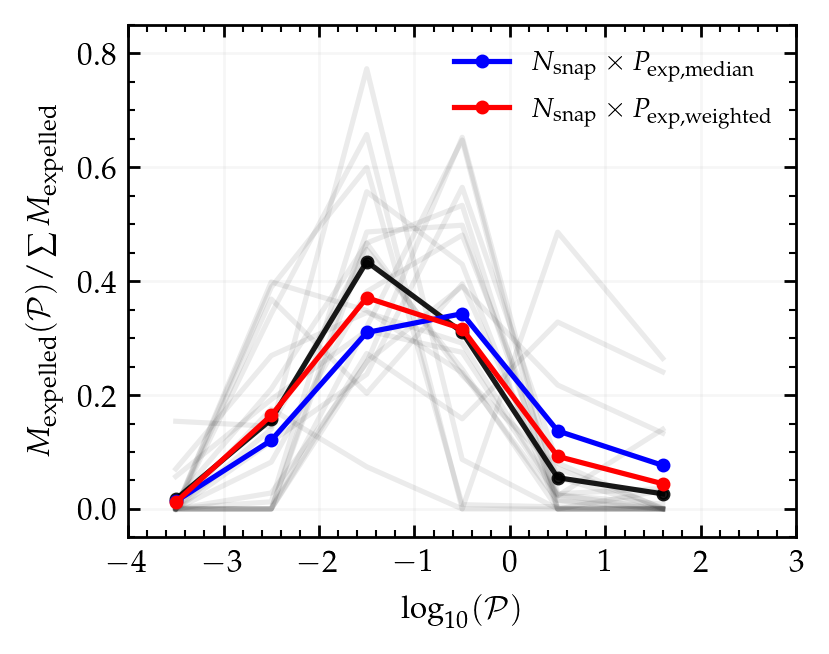

In [14]:
fig, ax = plt.subplots(1,1,dpi=250, figsize=(3.2,2.5), constrained_layout=True)
bins = np.append(np.arange(-4, 2, 1),2.2)

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    x = np.log10(d.ratio)
    y = d.M_expelled
    cond = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isinf(x)) & (~np.isinf(y))
    BigSum = np.sum(y[cond])
    Sum, bins, binnumber = scipy.stats.binned_statistic(x[cond], y[cond], statistic='sum', bins=bins)
    bc = 0.5*(bins[1:]+bins[:-1])
    ax.plot(bc, Sum/BigSum, 'k-', ms=2, alpha=0.08)

x = np.log10(data_all.ratio)
y = data_all.M_expelled
cond = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isinf(x)) & (~np.isinf(y))
BigSum = np.sum(y[cond])
Sum, bins, binnumber = scipy.stats.binned_statistic(x[cond], y[cond], statistic='sum', bins=bins)
bc = 0.5*(bins[1:]+bins[:-1])
im = ax.plot(bc, Sum/BigSum, 'ko-', ms=3, alpha=0.9)

N, bins = np.histogram(np.log10(data_all.ratio), bins=bins, density=True)
plt.plot(bc, N*E_prob_median/(np.sum(N*E_prob_median)), 'bo-', ms=3, label=r'$N_{\rm snap}\times P_{\rm exp,median}$')
plt.plot(bc, N*E_prob_weighted/(np.sum(N*E_prob_weighted)), 'ro-', ms=3, label=r'$N_{\rm snap}\times P_{\rm exp,weighted}$')

ax.legend(frameon=False, fontsize=8)
ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'$M_{\rm expelled}(\mathcal{P})/\sum M_{\rm expelled}$')
ax.set_xlim(-4, 3)
ax.set_ylim(-0.05, 0.85)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)

# plt.savefig('plots/fraction_expelled_by_Pram.pdf')
plt.show()

We see that we can pretty neatly back out the fraction of gas mass expelled at each ram pressure ratio. We do a bit better when we use the probability weighted by the number of particles (i.e. $N_p(t_1)$), as this takes into account the fact that satellites have more material available to be expelled when they are at lower ram pressure ratios. 

## Tidal Effects <a class="anchor" id="tidal-effects"></a>

In [16]:
from tqdm import tqdm
timescales = read_timescales()
timescales = timescales[(timescales.quenched==True)&(~np.isnan(timescales.tinfall))]
tau = timescales.tinfall - timescales.tquench

r_peris, r_peris_tq, keys, z0_halo_fracs, tq_halo_fracs = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
for t in tqdm(timescales.iterrows(), total=len(timescales)):
    t = t[1]
    sim = t.sim
    haloid = t.haloid
    key = sim + '_' + str(int(haloid))
    
    ts = read_timesteps(sim)
    ts = ts[ts.z0haloid==haloid]
    ts = ts.sort_values('t')
    
    tq = age - t.tquench
    
    r_peri = np.min(ts.h1dist)
    r_peri_tq = np.min(ts.h1dist[ts.t <= tq])
    
    M_halos = np.array(ts.mass-ts.mstar-ts.mgas,dtype=float)
    z0_halo_frac = M_halos[-1]/np.max(M_halos)
    tq_halo_frac = M_halos[np.argmin(np.abs(ts.t-tq))]/np.max(M_halos)
    
    r_peris = np.append(r_peris, r_peri)
    r_peris_tq = np.append(r_peris_tq, r_peri_tq)
    z0_halo_fracs = np.append(z0_halo_fracs, z0_halo_frac)
    tq_halo_fracs = np.append(tq_halo_fracs, tq_halo_frac)
    keys= np.append(keys, key)
    

100%|██████████| 71/71 [01:23<00:00,  1.17s/it]


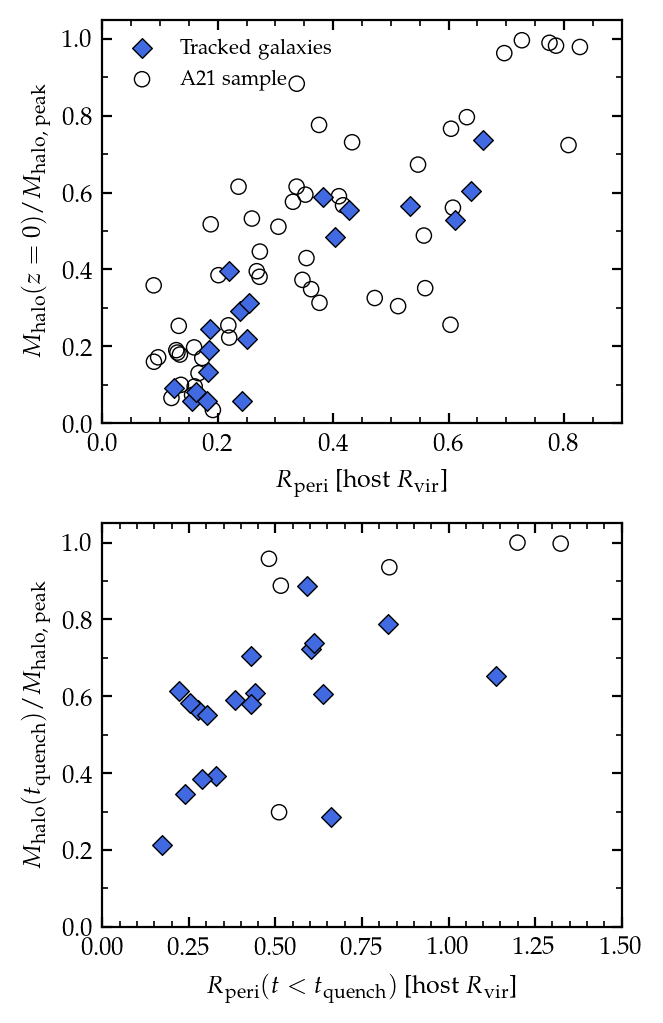

In [19]:
fig, ax = plt.subplots(2,1,figsize=(3.2import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

np.random.seed(9876789)

OLS estimation¶

Artificial data:

nsample = 100
x = np.linspace(0, 10, 100)
X = np.column_stack((x, x**2))
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)

Our model needs an intercept so we add a column of 1s:

X = sm.add_constant(X)
y = np.dot(X, beta) + e

Fit and summary:

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

, 5), dpi=200, constrained_layout=True)

cond = np.array([k in np.unique(data_all.key) for k in keys])
ax[0].scatter([100,100], [100,100], s=25, marker='D', fc='royalblue', ec='k', linewidths=0.5, label='Tracked galaxies')
ax[0].scatter(r_peris[~cond], z0_halo_fracs[~cond], s=30, ec='k', fc='none', linewidths=0.5, label='A21 sample')
ax[0].scatter(r_peris[cond], z0_halo_fracs[cond], s=25, marker='D',fc='royalblue', ec='k', linewidths=0.5)

ax[0].legend(frameon=False, loc='upper left', fontsize=7.5)
ax[0].set_ylabel(r'$M_{\rm halo}(z=0)/M_{\rm halo,~peak}$')
ax[0].set_xlabel(r'$R_{\rm peri}$ [host $R_{\rm vir}$]')
ax[0].set_xlim(0, 0.9)

ax[1].scatter(r_peris_tq[~cond], tq_halo_fracs[~cond], s=30, ec='k', fc='none', linewidths=0.5)
ax[1].scatter(r_peris_tq[cond], tq_halo_fracs[cond], s=25, marker='D',fc='royalblue', ec='k', linewidths=0.5)

ax[1].set_ylabel(r'$M_{\rm halo}(t_{\rm quench})/M_{\rm halo,~peak}$')
ax[1].set_xlabel(r'$R_{\rm peri}(t < t_{\rm quench})$ [host $R_{\rm vir}$]')
ax[1].set_xlim(0, 1.5)

for a in ax:
    a.set_ylim(0,1.05)
    a.tick_params(direction='in', which='both', top=True, right=True)
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

plt.savefig('plots/Mhalo_Rperi.pdf')
plt.show()

## Decomposing the Restoring Pressure <a class="anchor" id="restoring-pressure"></a>

We have seen that tidal effects are at least somewhat active at removing material directly from satellites. However, tidal forces can also aid in ram pressure by changing the potential of the satellite. This would affect the restoring pressure. 

Here, we aim to answer the question: does tidal stripping significantly aid ram pressure by lowering the restoring pressure?

Recall that the restoring pressure is defined as
$$P_{\rm rest} = \Sigma_{\rm gas} \bigg|\frac{d\Phi}{dz}\bigg|_{\rm max} \approx \left(\frac{M_{\rm gas}}{2\pi r_{\rm half}^2}\right)\left(\frac{v_{\rm max}^2}{r_{\rm max}}\right)$$
The first term is related to the gas surface density, while the other is related to the rotation curve. The second term should thus only be related to tidal effects. 

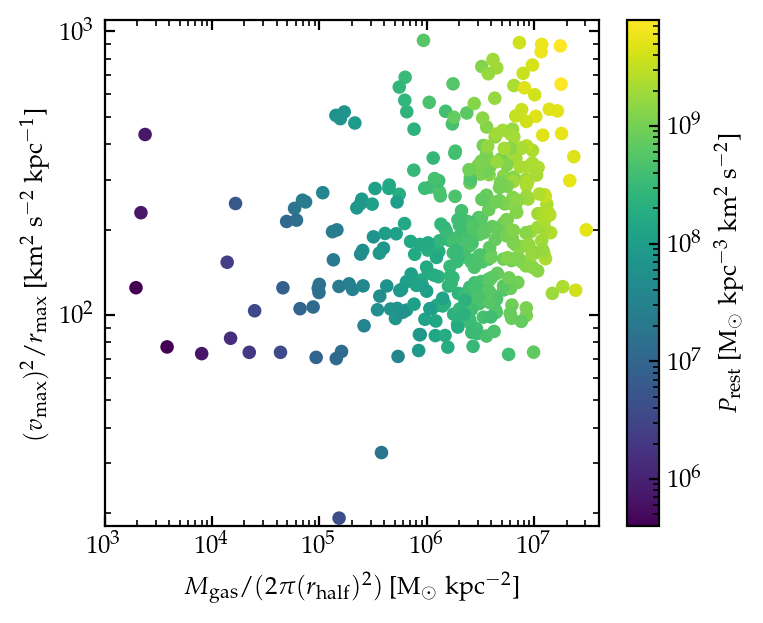

In [103]:
plt.figure(dpi=200, figsize=(3.7,3), constrained_layout=True)

dphidz = data_all.dphidz
dphidz /= data_all.a
dphidz *= 0.67
    
plt.scatter(data_all.SigmaGas, dphidz, s=15, c=data_all.Prest, norm=mpl.colors.LogNorm(vmin=4e5, vmax=8e9))
    
plt.colorbar(label=r'$P_{\rm rest}$ [M$_{\odot}$ kpc$^{-3}$ km$^2$ s$^{-2}$]')
plt.loglog()
plt.ylim(1.8e1, 1.1e3)
plt.xlim(1e3, 4e7)
plt.xlabel(r'$M_{\rm gas}/(2\pi (r_{\rm half})^2)$ [M$_{\odot}$ kpc$^{-2}$]')
plt.ylabel(r'$(v_{\rm max})^2 /r_{\rm max}$ [km$^{2}$ s$^{-2}$ kpc$^{-1}$]')

# plt.savefig('plots/Prest_decomp.pdf')
plt.show()

Here we can clearly see that $P_{\rm rest}$ is indeed made up of these two multiplicative components. However, this is not as useful as one might think. Satellites that are inititially lower-mass than others will inherently have lower restoring pressures, so a "low restoring pressure" doesn't necessarily mean a "reduced restoring pressure due to changes to SigmaGas or dphidz." 

Instead, we can normalize $P_{\rm rest}$ to its maximum value to better undertand *why the restoring pressure gets reduced from its maxmimum*. 

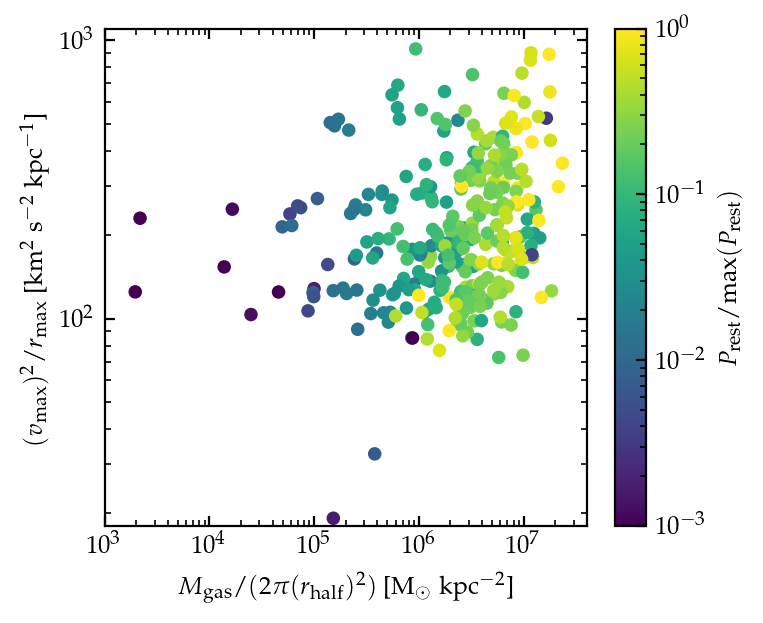

In [36]:
plt.figure(dpi=200, figsize=(3.7,3), constrained_layout=True)

dphidz = data_all.dphidz
dphidz /= data_all.a
dphidz *= 0.67
    
Prest_by_init = np.array([])
for key in np.unique(data_all.key):
    data = data_all[data_all.key==key]
    Prest_by_init = np.append(Prest_by_init, data.Prest/np.max(data.Prest))
    
    
plt.scatter(data_all.SigmaGas, dphidz, s=15, c=Prest_by_init, norm=mpl.colors.LogNorm(vmin=1e-3, vmax=1))
    
plt.colorbar(label=r'$P_{\rm rest}/{\rm max}(P_{\rm rest})$')
plt.loglog()
plt.ylim(1.8e1, 1.1e3)
plt.xlim(1e3, 4e7)
plt.xlabel(r'$M_{\rm gas}/(2\pi (r_{\rm half})^2)$ [M$_{\odot}$ kpc$^{-2}$]')
plt.ylabel(r'$(v_{\rm max})^2 /r_{\rm max}$ [km$^{2}$ s$^{-2}$ kpc$^{-1}$]')

plt.savefig('plots/Prest_decomp.pdf')
plt.show()

This shows us that when $P_{\rm rest}$ is significantly reduced from its maximum, this is typically because of low SigmaGas. 

We can make this a bit more quantitivate by performing OLS regression:

In [25]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

x = np.log10(np.array(data_all.SigmaGas,dtype=float))
y = np.log10(np.array(data_all.Prest,dtype=float))
cond = ~np.isinf(x) & ~np.isinf(y)
X = sm.add_constant(x)
model = sm.OLS(y[cond], X[cond])
results = model.fit()
print(results.summary())

x = np.log10(np.array(data_all.dphidz,dtype=float))
y = np.log10(np.array(data_all.Prest,dtype=float))
cond = ~np.isinf(x) & ~np.isinf(y)
X = sm.add_constant(x)
model = sm.OLS(y[cond], X[cond])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     5110.
Date:                Sun, 23 May 2021   Prob (F-statistic):          1.44e-220
Time:                        16:01:05   Log-Likelihood:                 80.714
No. Observations:                 377   AIC:                            -157.4
Df Residuals:                     375   BIC:                            -149.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0827      0.092     22.709      0.0

In [10]:
filepaths, haloids, h1ids = get_stored_filepaths_haloids('h148',282)


001269     79
001152     43
001024     42
000974     44
000640     73
000456     77
000347     69
000275     42
000225     53
000188     85
000139    NaN


 '001280', 
 '001269',
 '001152',
 '001106',
 '001024',
 '000974',
 '000896',
 '000866',
 '000768',
 '000701',
 '000640',
 '000512',
 '000456',
 '000384',
 '000347',
 '000275',
 '000225',
 '000188',
 '000139']

43

array([], dtype=int64)

42

In [45]:
haloids = np.append(haloids, np.array([np.nan, 79, 43, np.nan, 42, 44, np.nan, np.nan, np.nan, np.nan, 73, np.nan, 77, np.nan, 69, 42, 53, 85, np.nan]))

43

The $R^2$ values here tell us that 93% of the variance in $\log_{10}(P_{\rm rest})$ is explained by SigmaGas, while only 14% is explained by dphidz. 

## Gas Depletion Times <a class="anchor" id="depletion"></a>

Here, we want to show the timescale on which gas is lost based on the net gas-loss rates, both from the satellite overall and from the disk specifically. 

In [1]:
from analysis import *

data_all = read_all_ram_pressure(suffix='_no1Gyr')

1 Returning (expelled, accreted) for h148-12...
2 Returning (expelled, accreted) for h148-249...
3 Returning (expelled, accreted) for h148-251...
4 Returning (expelled, accreted) for h148-27...
5 Returning (expelled, accreted) for h148-282...
6 Returning (expelled, accreted) for h148-34...
7 Returning (expelled, accreted) for h148-38...
8 Returning (expelled, accreted) for h148-55...
9 Returning (expelled, accreted) for h148-65...
10 Returning (expelled, accreted) for h229-14...
11 Returning (expelled, accreted) for h229-18...
12 Returning (expelled, accreted) for h229-20...
13 Returning (expelled, accreted) for h229-22...
14 Returning (expelled, accreted) for h229-49...
15 Returning (expelled, accreted) for h242-21...
16 Returning (expelled, accreted) for h242-38...
17 Returning (expelled, accreted) for h242-69...
18 Returning (expelled, accreted) for h329-117...
19 Returning (expelled, accreted) for h329-29...


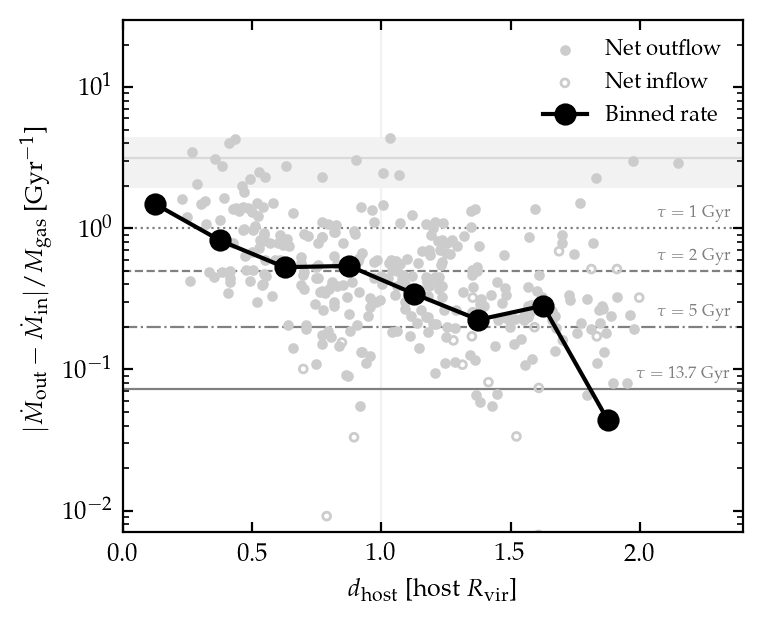

In [7]:
import scipy.stats

dist = np.array(data_all.h1dist/data_all.hostRvir)
bins = np.arange(0, 2.2, 0.25)
bc = 0.5*(bins[1:]+bins[:-1])

fig, ax = plt.subplots(1,1, figsize=(3.7, 3))

def netOutIn(y):
    return np.sum(y[y >= 0]) + np.sum(y[y < 0])

def sumif(y):
    return np.sum(y[~np.isnan(y)])

y = data_all.Mdot_expelled - data_all.Mdot_accreted
ydiv = data_all.Mgas_div
net, bin_edges, binnumber = scipy.stats.binned_statistic(dist, y, bins=bins, statistic=netOutIn)
div, bin_edges, binnumber = scipy.stats.binned_statistic(dist, ydiv, bins=bins, statistic=sumif)

x, y = dist, y/ydiv
ax.scatter(x[y > 0], y[y > 0], facecolor='0.8', edgecolor='0.8', label='Net outflow', s=8)
ax.scatter(x[y < 0], -y[y < 0], facecolor='none', edgecolor='0.8', label='Net inflow', s=8)
ax.plot(bc, net/div, 'ko-', zorder=100, ms=7, label='Binned rate')

# y = data_all.SFR * 1e9
# net, bin_edges, binnumber = scipy.stats.binned_statistic(dist, y, bins=bins, statistic=netOutIn)
# div, bin_edges, binnumber = scipy.stats.binned_statistic(dist, ydiv, bins=bins, statistic=sumif)
# ax.plot(bc, net/div, 'g^--', label='SF only', zorder=50, ms=5)

ax.plot([0,4], [1, 1], linewidth=0.8, linestyle=':', color='0.5', zorder=-300)
ax.plot([0,4], [0.5, 0.5], linewidth=0.8, linestyle='--', color='0.5', zorder=-300)
ax.plot([0,4], [0.2, 0.2], linewidth=0.8, linestyle='-.', color='0.5', zorder=-300)
ax.plot([0,4], [1/13.7, 1/13.7], linewidth=0.8, linestyle='-', color='0.5', zorder=-300)
ax.annotate(r'$\tau = 1~{\rm Gyr}$', (2.35, 1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 2~{\rm Gyr}$', (2.35, 0.5*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 5~{\rm Gyr}$', (2.35, 0.2*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 13.7~{\rm Gyr}$', (2.35, 1/13.7*1.2), color='0.5', fontsize=6, ha='right')

mu = 1/np.mean(data_all.dt)
sigma = np.std(data_all.dt)/(np.mean(data_all.dt)**2)
ax.plot([0, 4],[mu]*2,color='0.85', linestyle='-', linewidth=0.8, zorder=-100)
ax.fill_between([0, 4],[mu-sigma]*2,[mu+sigma]*2, fc='0.95', zorder=-110)
ax.plot([1,1],[1e-3,1e3],color='0.95', linestyle='-', linewidth=0.8, zorder=-1000)

ax.semilogy()
ax.set_ylim(7e-3, 3e1)
ax.set_xlim(0,2.4)
handles, labels = ax.get_legend_handles_labels()
order = [1,2,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=8)
ax.set_ylabel(r'$|\dot{M}_{\rm out}-\dot{M}_{\rm in}|/M_{\rm gas}$ [Gyr$^{-1}$]')
ax.set_xlabel(r'$d_{\rm host}$ [host $R_{\rm vir}$]')

plt.savefig('plots/overall_depletion.pdf')
plt.show()

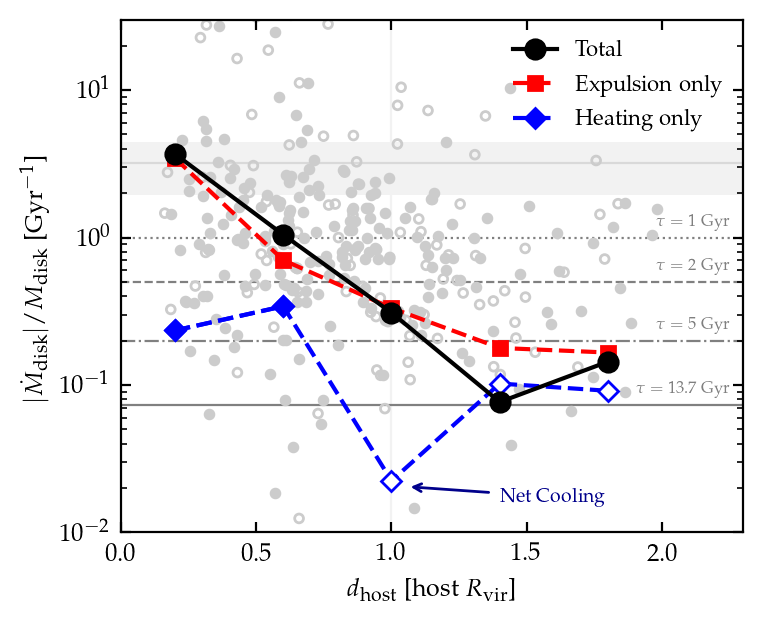

In [62]:
import scipy.stats

dist = np.array(data_all.h1dist/data_all.hostRvir)
bins = np.arange(0, 2.2, 0.4)
bc = 0.5*(bins[1:]+bins[:-1])

fig, ax = plt.subplots(1,1, figsize=(3.7, 3))

def netOutIn(y):
    return np.sum(y[y >= 0]) + np.sum(y[y < 0])

def sumif(y):
    return np.sum(y[~np.isnan(y)])

y = data_all.Mdot_ejected - data_all.Mdot_cooled + data_all.Mdot_expelled_disk - data_all.Mdot_accreted_disk
ydiv = data_all.Mdisk_div
net, bin_edges, binnumber = scipy.stats.binned_statistic(dist, y, bins=bins, statistic=netOutIn)
div, bin_edges, binnumber = scipy.stats.binned_statistic(dist, ydiv, bins=bins, statistic=sumif)
x, y = dist, y/ydiv
ax.scatter(x[y > 0], y[y > 0], facecolor='0.8', edgecolor='0.8', s=10)
ax.scatter(x[y < 0], -y[y < 0], facecolor='none', edgecolor='0.8', s=10)
ax.plot(bc, net/div, 'ko-', label='Total', zorder=100, ms=7)

y = data_all.Mdot_expelled_disk - data_all.Mdot_accreted_disk
net, bin_edges, binnumber = scipy.stats.binned_statistic(dist, y, bins=bins, statistic=netOutIn)
div, bin_edges, binnumber = scipy.stats.binned_statistic(dist, ydiv, bins=bins, statistic=sumif)
ax.plot(bc, net/div, 'ro--', label='Expulsion only', zorder=50, ms=5, marker='s')

y = data_all.Mdot_ejected - data_all.Mdot_cooled 
net, bin_edges, binnumber = scipy.stats.binned_statistic(dist, y, bins=bins, statistic=netOutIn)
div, bin_edges, binnumber = scipy.stats.binned_statistic(dist, ydiv, bins=bins, statistic=sumif)

ax.plot(bc, np.abs(net/div), 'bo--', mfc='w', ms=5, zorder=10, marker='D')
ax.plot(bc[(net/div)>0], (net/div)[(net/div)>0], 'bo--', label='Heating only', ms=5, zorder=10, marker='D')

ax.plot([0,4], [1, 1], linewidth=0.8, linestyle=':', color='0.5', zorder=-300)
ax.plot([0,4], [0.5, 0.5], linewidth=0.8, linestyle='--', color='0.5', zorder=-300)
ax.plot([0,4], [0.2, 0.2], linewidth=0.8, linestyle='-.', color='0.5', zorder=-300)
ax.plot([0,4], [1/13.7, 1/13.7], linewidth=0.8, linestyle='-', color='0.5', zorder=-300)
ax.annotate(r'$\tau = 1~{\rm Gyr}$', (2.25, 1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 2~{\rm Gyr}$', (2.25, 0.5*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 5~{\rm Gyr}$', (2.25, 0.2*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 13.7~{\rm Gyr}$', (2.25, 1/13.7*1.2), color='0.5', fontsize=6, ha='right')

mu = 1/np.mean(data_all.dt)
sigma = np.std(data_all.dt)/(np.mean(data_all.dt)**2)
ax.plot([0, 4],[mu]*2,color='0.85', linestyle='-', linewidth=0.8, zorder=-100)
ax.fill_between([0, 4],[mu-sigma]*2,[mu+sigma]*2, fc='0.95', zorder=-110)
ax.plot([1,1],[1e-3,1e3],color='0.95', linestyle='-', linewidth=0.8, zorder=-1000)

ax.semilogy()
ax.set_ylim(1e-2, 3e1)
ax.set_xlim(0,2.3)
ax.legend(fontsize=8)
ax.set_ylabel(r'$|\dot{M}_{\rm disk}|/M_{\rm disk}$ [Gyr$^{-1}$]')
ax.set_xlabel(r'$d_{\rm host}$ [host $R_{\rm vir}$]')
ax.annotate('Net Cooling', xy=(1.05, 2.05e-2), xytext=(1.4, 1.5e-2), arrowprops=dict(arrowstyle='->', color='darkblue'), va='bottom', fontsize=7, color='darkblue')

plt.savefig('plots/disk_depletion.pdf')
plt.show()

### some older depletion time plots that I haven't used

One includes ram pressure ratios, since that is relevant as well as distance. 

One colors points by the time until quenching to relate that to depletion time. This is a weird thing though, because satellites generally quench before they fully deplete their gas reservoirs. 

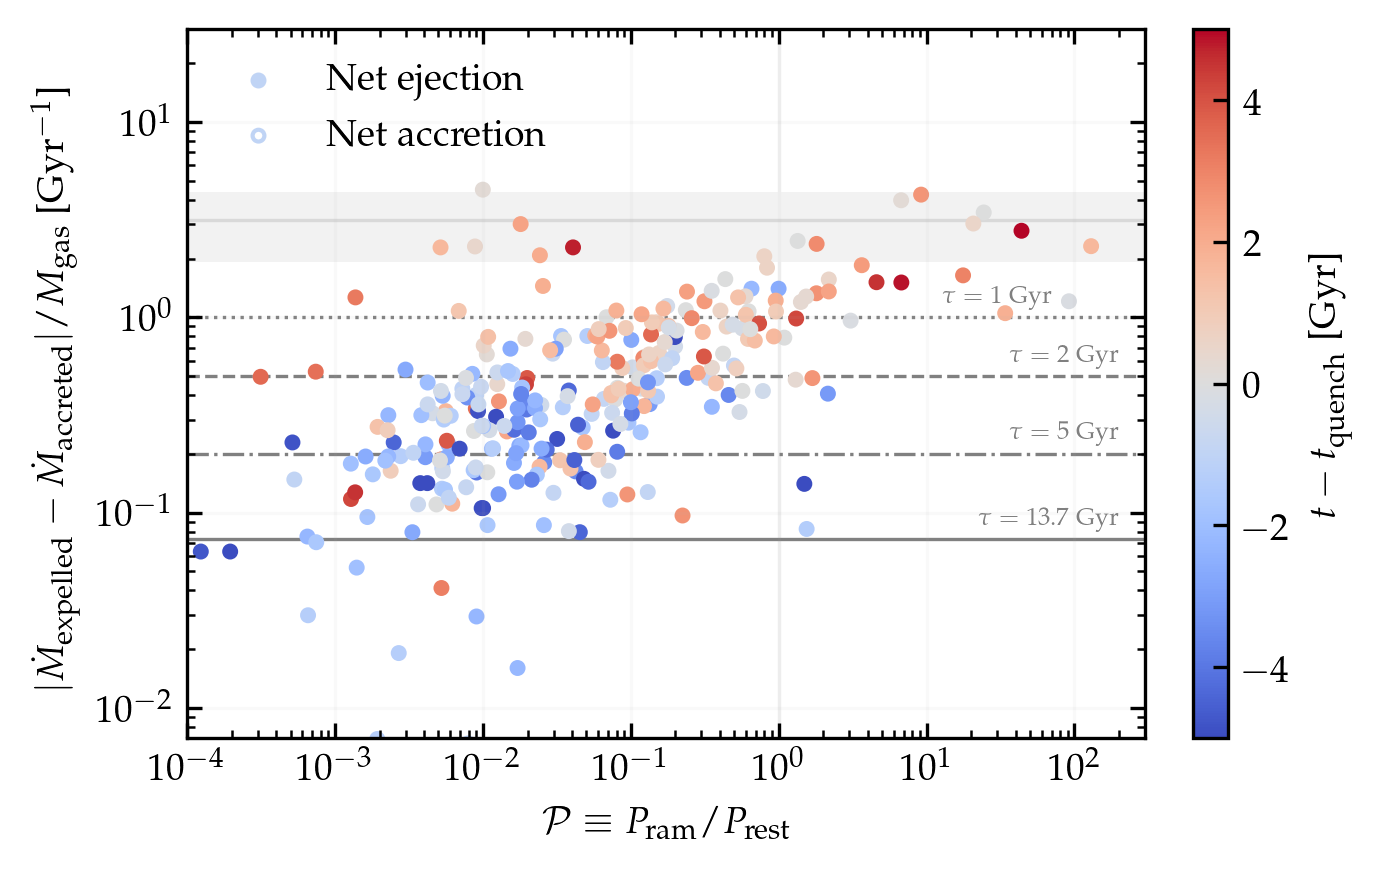

In [67]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5, 2.8), constrained_layout=True)

x = data_all.ratio
y = data_all.Mdot_expelled_by_Mgas - data_all.Mdot_accreted_by_Mgas
c = data_all.t-data_all.tquench
norm = mpl.colors.Normalize(vmin=-5, vmax=5)
cmap_name = 'coolwarm'

im = ax.scatter(x[y >= 0], y[y >= 0], c=c[y >= 0], s=8, norm=norm, cmap=cmap_name)
im = ax.scatter(x[y < 0], -y[y < 0], c=c[y < 0], s=8, norm=norm, fc='none', cmap=cmap_name)
fig.colorbar(im, ax=ax, label=r'$t-t_{\rm quench}$ [Gyr]')

cmap = mpl.cm.get_cmap(cmap_name)
ax.scatter([1e6],[1e6], s=8, fc=cmap(0.4), ec=cmap(0.4), label='Net ejection')
ax.scatter([1e6],[1e6], s=8, fc='none', ec=cmap(0.4), label='Net accretion')

ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$')
ax.set_ylabel(r'$|\dot{M}_{\rm expelled} - \dot{M}_{\rm accreted}|/M_{\rm gas}$ [Gyr$^{-1}$]')
# ax.set_yscale('symlog', linthresh = 1e5, linscale=0.5)
ax.loglog()
ax.set_xlim(1e-4,3e2)
ax.set_ylim(7e-3, 3e1)
ax.legend(frameon=False, loc='upper left')
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.07, zorder=-1000)
ax.plot([1e-4,1e4], [1, 1], linewidth=0.8, linestyle=':', color='0.5', zorder=-300)
ax.plot([1e-4,1e4], [0.5, 0.5], linewidth=0.8, linestyle='--', color='0.5', zorder=-300)
ax.plot([1e-4,1e4], [0.2, 0.2], linewidth=0.8, linestyle='-.', color='0.5', zorder=-300)
ax.plot([1e-4,1e4], [1/13.7, 1/13.7], linewidth=0.8, linestyle='-', color='0.5', zorder=-300)
ax.annotate(r'$\tau = 1~{\rm Gyr}$', (7e1, 1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 2~{\rm Gyr}$', (2e2, 0.5*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 5~{\rm Gyr}$', (2e2, 0.2*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 13.7~{\rm Gyr}$', (2e2, 1/13.7*1.2), color='0.5', fontsize=6, ha='right')
    
mu = 1/np.mean(data_all.dt)
sigma = np.std(data_all.dt)/(np.mean(data_all.dt)**2)
ax.plot([1e-4,1e4],[mu]*2,color='0.85', linestyle='-', linewidth=0.8, zorder=-100)
ax.fill_between([1e-4,1e4],[mu-sigma]*2,[mu+sigma]*2, fc='0.95', zorder=-110)
ax.plot([1,1],[1e-3,1e3],color='0.95', linestyle='-', linewidth=0.8, zorder=-1000)

plt.show()

In [3]:
import scipy.stats

/Users/hollis/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/hollis/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/hollis/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


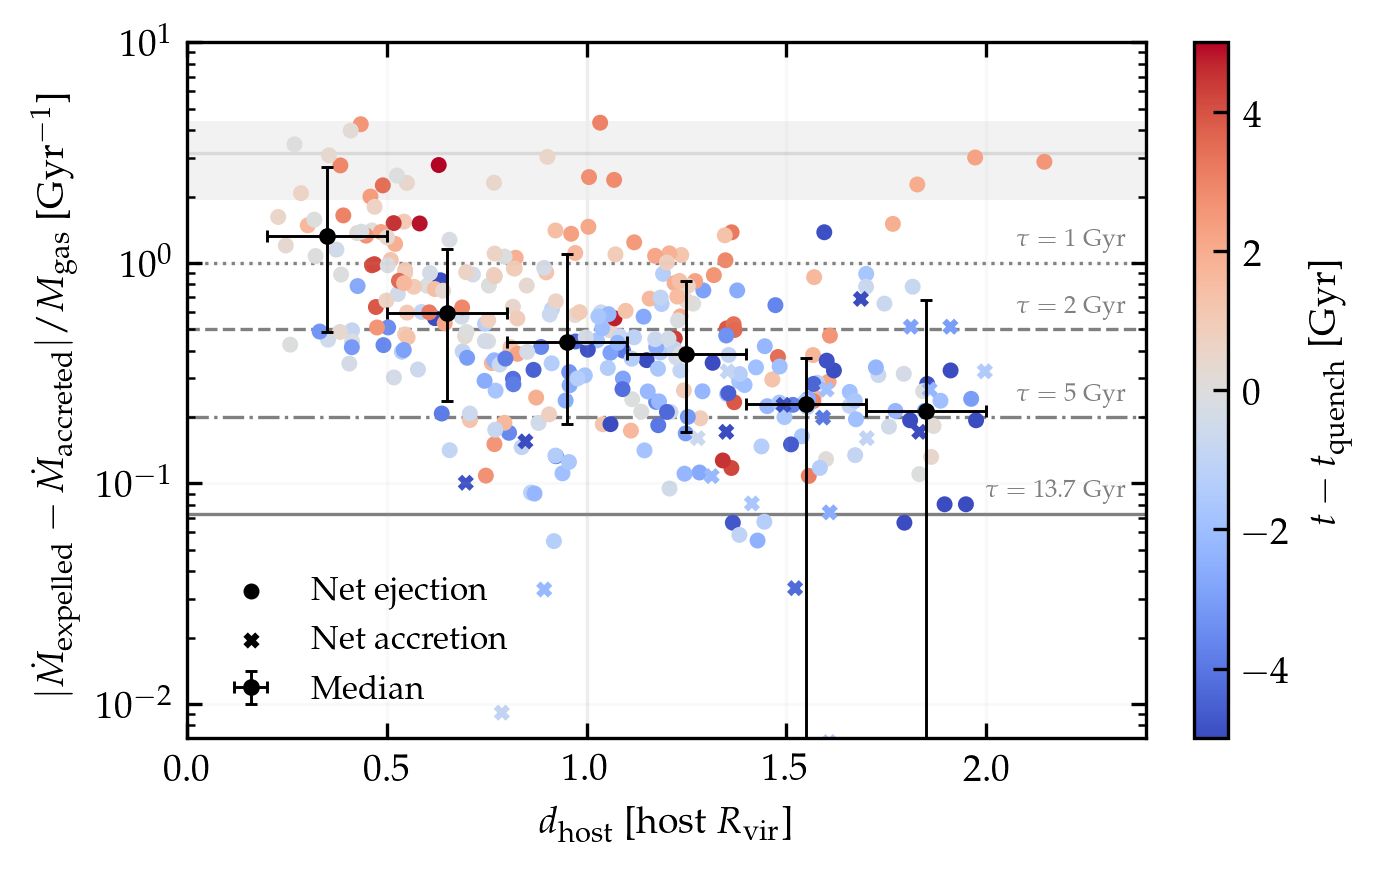

In [35]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5, 2.8), constrained_layout=True)

x = data_all.ratio
y = data_all.Mdot_expelled_by_Mgas - data_all.Mdot_accreted_by_Mgas
c = data_all.t-data_all.tquench
norm = mpl.colors.Normalize(vmin=-5, vmax=5)
cmap_name = 'coolwarm'

dist = np.array(data_all.h1dist/data_all.hostRvir)
bins = np.arange(0.2, 2.2, 0.3)
bc = 0.5*(bins[1:]+bins[:-1])

def netOutIn(y):
    return np.sum(y[y >= 0]) + np.sum(y[y < 0])

def sumif(y):
    return np.sum(y[~np.isnan(y)])

y = data_all.Mdot_expelled - data_all.Mdot_accreted
ydiv = data_all.Mgas_div
# net, bin_edges, binnumber = scipy.stats.binned_statistic(dist, y, bins=bins, statistic=netOutIn)
# div, bin_edges, binnumber = scipy.stats.binned_statistic(dist, ydiv, bins=bins, statistic=sumif)


median, bin_edges, binnumber = scipy.stats.binned_statistic(dist, y/ydiv, bins=bins, statistic=np.nanmedian)
perc16, bin_edges, binnumber = scipy.stats.binned_statistic(dist, y/ydiv, bins=bins, statistic=lambda x: np.nanpercentile(x, 16))
perc84, bin_edges, binnumber = scipy.stats.binned_statistic(dist, y/ydiv, bins=bins, statistic=lambda x: np.nanpercentile(x, 84))

x, y = dist, y/ydiv

im = ax.scatter(x[y >= 0], y[y >= 0], c=c[y >= 0], s=8, norm=norm, cmap=cmap_name)
im = ax.scatter(x[y < 0], -y[y < 0], c=c[y < 0], s=8, norm=norm, marker='x', cmap=cmap_name)
fig.colorbar(im, ax=ax, label=r'$t-t_{\rm quench}$ [Gyr]')


ax.errorbar(bc, median, xerr=0.5*np.median(bins[1:]-bins[:-1]), yerr=[median-perc16, perc84-median], 
            linewidth=0, elinewidth=0.7, color='k', marker='o', markersize=3, capthick=0.7, capsize=1.5, label='Median')
# ax.stairs(median, bins, color='k', label='Binned rate')
# ax.plot(bc, net/div, 'ko-', zorder=100, ms=5, label='Binned rate')

# y = data_all.SFR * 1e9
# net, bin_edges, binnumber = scipy.stats.binned_statistic(dist, y, bins=bins, statistic=netOutIn)
# div, bin_edges, binnumber = scipy.stats.binned_statistic(dist, ydiv, bins=bins, statistic=sumif)
# ax.plot(bc, net/div, 'g^--', label='SF only', zorder=50, ms=5)

ax.plot([0,4], [1, 1], linewidth=0.8, linestyle=':', color='0.5', zorder=-300)
ax.plot([0,4], [0.5, 0.5], linewidth=0.8, linestyle='--', color='0.5', zorder=-300)
ax.plot([0,4], [0.2, 0.2], linewidth=0.8, linestyle='-.', color='0.5', zorder=-300)
ax.plot([0,4], [1/13.7, 1/13.7], linewidth=0.8, linestyle='-', color='0.5', zorder=-300)
ax.annotate(r'$\tau = 1~{\rm Gyr}$', (2.35, 1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 2~{\rm Gyr}$', (2.35, 0.5*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 5~{\rm Gyr}$', (2.35, 0.2*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 13.7~{\rm Gyr}$', (2.35, 1/13.7*1.2), color='0.5', fontsize=6, ha='right')


cmap = mpl.cm.get_cmap(cmap_name)
ax.scatter([1e6],[1e6], s=8, c='k', label='Net ejection')
ax.scatter([1e6],[1e6], s=8, marker='x', c='k', label='Net accretion')

ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$')
ax.set_ylabel(r'$|\dot{M}_{\rm expelled} - \dot{M}_{\rm accreted}|/M_{\rm gas}$ [Gyr$^{-1}$]')
# ax.set_yscale('symlog', linthresh = 1e5, linscale=0.5)
ax.semilogy()
ax.set_xlim(1e-4,3e2)
ax.set_ylim(7e-3, 1e1)
ax.legend(frameon=False, loc='lower left', fontsize=8)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.07, zorder=-1000)

mu = 1/np.mean(data_all.dt)
sigma = np.std(data_all.dt)/(np.mean(data_all.dt)**2)
ax.plot([1e-4,1e4],[mu]*2,color='0.85', linestyle='-', linewidth=0.8, zorder=-100)
ax.fill_between([1e-4,1e4],[mu-sigma]*2,[mu+sigma]*2, fc='0.95', zorder=-110)
ax.plot([1,1],[1e-3,1e3],color='0.95', linestyle='-', linewidth=0.8, zorder=-1000)


ax.set_xlim(0,2.4)
ax.set_xlabel(r'$d_{\rm host}$ [host $R_{\rm vir}$]')

plt.show()

In [12]:

x[y<0]

array([1.91094662, 1.81196897, 1.60874148, 1.31329257, 1.99723597,
       1.35315707, 1.83309511, 1.3497668 , 0.84683218, 0.69752383,
       1.68691064, 1.4931514 , 0.72374275, 1.85902455, 1.60095422,
       1.41385734, 0.78783333, 1.5221324 , 1.59220569, 1.60744483,
       0.89386307, 0.56300945, 1.70155186, 1.27822508])

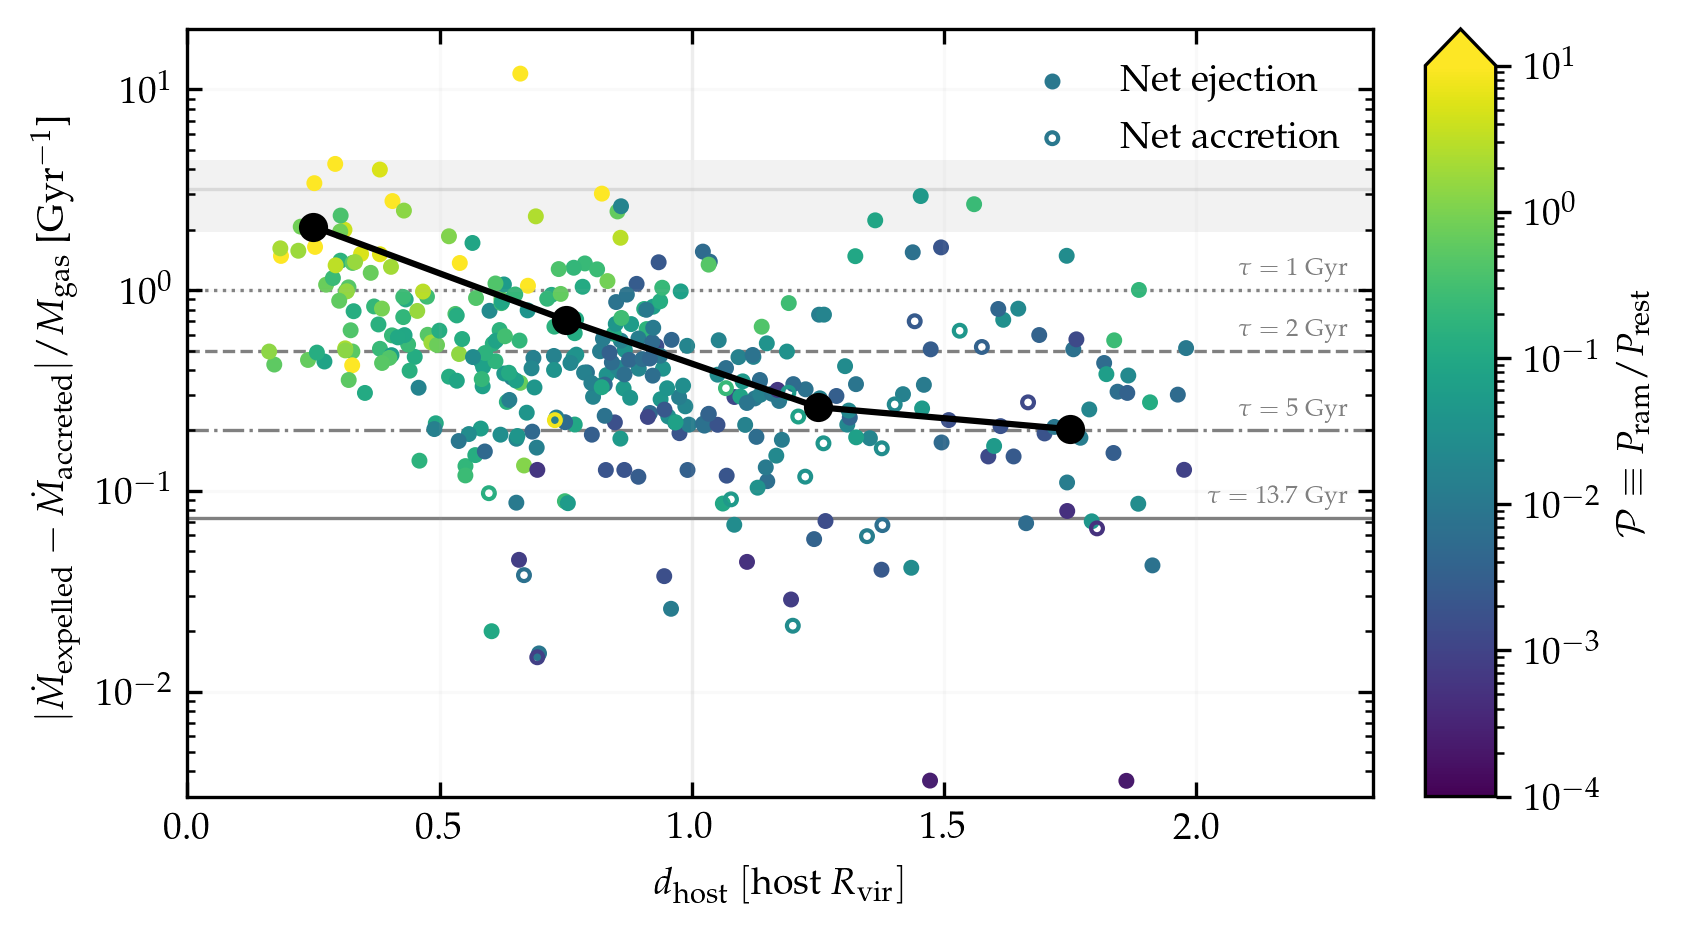

In [623]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(5.5, 3), constrained_layout=True)

c = data_all.ratio
y = data_all.Mdot_expelled_by_Mgas - data_all.Mdot_accreted_by_Mgas
x = data_all.h1dist/data_all.hostRvir
norm = mpl.colors.LogNorm(vmin=1e-4, vmax=1e1)

im = ax.scatter(x[y >= 0], y[y >= 0], c=c[y >= 0], s=8, norm=norm)
im = ax.scatter(x[y < 0], -y[y < 0], c=c[y < 0], s=8, norm=norm, fc='none')
fig.colorbar(im, ax=ax, label=r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$', extend='max')

cmap = mpl.cm.get_cmap('viridis')
ax.scatter([1e6],[1e6], s=8, fc=cmap(0.4), ec=cmap(0.4), label='Net ejection')
ax.scatter([1e6],[1e6], s=8, fc='none', ec=cmap(0.4), label='Net accretion')

ax.set_xlabel(r'$d_{\rm host}~[{\rm host}~R_{\rm vir}]$')
ax.set_ylabel(r'$|\dot{M}_{\rm expelled} - \dot{M}_{\rm accreted}|/M_{\rm gas}$ [Gyr$^{-1}$]')
# ax.set_yscale('symlog', linthresh = 1e5, linscale=0.5)
ax.semilogy()
ax.set_xlim(0,2.35)
ax.set_ylim(3e-3, 2e1)
ax.legend(frameon=False, loc='upper right')
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.07, zorder=-1000)
ax.plot([0,4], [1, 1], linewidth=0.8, linestyle=':', color='0.5', zorder=-300)
ax.plot([0,4], [0.5, 0.5], linewidth=0.8, linestyle='--', color='0.5', zorder=-300)
ax.plot([0,4], [0.2, 0.2], linewidth=0.8, linestyle='-.', color='0.5', zorder=-300)
ax.plot([0,4], [1/13.7, 1/13.7], linewidth=0.8, linestyle='-', color='0.5', zorder=-300)
ax.annotate(r'$\tau = 1~{\rm Gyr}$', (2.3, 1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 2~{\rm Gyr}$', (2.3, 0.5*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 5~{\rm Gyr}$', (2.3, 0.2*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 13.7~{\rm Gyr}$', (2.3, 1/13.7*1.2), color='0.5', fontsize=6, ha='right')

mu = 1/np.mean(data_all.dt)
sigma = np.std(data_all.dt)/(np.mean(data_all.dt)**2)
ax.plot([0, 4],[mu]*2,color='0.85', linestyle='-', linewidth=0.8, zorder=-100)
ax.fill_between([0, 4],[mu-sigma]*2,[mu+sigma]*2, fc='0.95', zorder=-110)
ax.plot([1,1],[1e-3,1e3],color='0.95', linestyle='-', linewidth=0.8, zorder=-1000)

bins = np.arange(0, 2.5, 0.5)
binned_netOutIn = np.array([])
for left_edge, right_edge in zip(bins[:-1],bins[1:]):
    cond = (x >= left_edge) & (x < right_edge)
    y = data_all.Mdot_expelled - data_all.Mdot_accreted
    ydiv = data_all.Mgas_div
    netOutIn = (np.sum(y[cond & (y >= 0)]) - np.sum(-y[cond & (y < 0)])) / np.sum(ydiv[cond])
    binned_netOutIn = np.append(binned_netOutIn, netOutIn)

bc = 0.5*(bins[1:]+bins[:-1])
ax.plot(bc, binned_netOutIn, 'ko-')

# plt.savefig('plots/net_Mdot.pdf')
plt.show()

## Code to get halo masses and peak halo masses into data_all

Just saving this for future reference!

In [21]:
h148 = read_timesteps('h148')
h148['sim'] = 'h148'
h229 = read_timesteps('h229')
h229['sim'] = 'h229'
h242 = read_timesteps('h242')
h242['sim'] = 'h242'
h329 = read_timesteps('h329')
h329['sim'] = 'h329'
timesteps_all = pd.concat([h148,h229,h242,h329])

In [22]:
def get_halo_masses(d):
    global timesteps_all
    sim = str(d.key)[:4]
    haloid = int(str(d.key)[5:])
    t = float(d.t)
    ts = timesteps_all[(timesteps_all.z0haloid==haloid)&(timesteps_all.sim==sim)]
    ts = ts[ts.z0haloid==haloid]
    times = np.array(ts.time, dtype=float)
    M_halos = np.array(ts.mass-ts.mgas-ts.mstar, dtype=float)
    M_halo = M_halos[np.argmin(np.abs(times-t))]
    d['M_halo'] = M_halo
    d['M_halo_peak'] = np.max(M_halos)
    d['M_gas_peak'] = np.max(ts.mgas)
    return d
    
from tqdm import tqdm
tqdm.pandas()
data_all = data_all.progress_apply(get_halo_masses, axis=1)

/Users/hollis/anaconda3/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 512/512 [00:04<00:00, 102.51it/s]


In [ ]:
# timesteps data
def read_timesteps(sim):
    '''Function to read in the data file which contains quenching and infall times'''
    data = []
    with open(f'../../Data/timesteps_data/{sim}.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

In [98]:
particles = read_tracked_particles('h148',80)
timesteps = read_timesteps('h148')
ts = timesteps[timesteps.z0haloid==80]
ts = ts.rename({'mass':'sat_Mvir'}, axis=1)
ts = ts[['t','sat_Mvir']]

pd.merge_asof(particles, ts.sort_values('t'), left_on='time', right_on='t', direction='nearest', tolerance=1)

time       pid       rho          temp          mass  coolontime  \
0        4.750210   4979492  0.000071  5.715976e+04  26510.536704    0.000000   
1        4.750210   4981246  0.000061  4.856389e+04  26510.536704    0.000000   
2        4.750210   4981256  0.000070  5.780112e+04  26510.536704    0.000000   
3        4.750210   4993714  0.000064  6.040824e+04  26510.536704    0.000000   
4        4.750210   4994008  0.000071  7.628964e+04  26510.536704    0.000000   
...           ...       ...       ...           ...           ...         ...   
174654  13.800797  19519072  0.000279  1.137142e+06  20531.974515    8.447729   
174655  13.800797  19519088  1.589614  1.830218e+04  12453.450560   13.812571   
174656  13.800797  19519108  0.000045  4.792723e+05  27092.311009    4.373628   
174657  13.800797  19519110  0.000901  1.144673e+06  27301.683303    4.580700   
174658  13.800797  19519188  0.002730  1.281518e+04  27492.818375   10.009187   

                 r  r_per_Rvir           x          y  ...     r_gal  \
0        93.938878    3.709329   41.315230   6.788291  ...  1.361809   
1        93.190557    3.679781   48.095506   6.053750  ...  1.361809   
2        94.083742    3.715049   40.319278   9.741875  ...  1.361809   
3        96.624725    3.815384   41.508890  10.132360  ...  1.361809   
4        96.791424    3.821967   43.873993   6.108432  ...  1.361809   
...            ...         ...         ...        ...  ...       ...   
174654  173.253052    5.716290   95.590667 -47.597373  ...  1.546361   
174655  111.771399    3.687772    9.567754 -47.485038  ...  1.546361   
174656  229.092168    7.558639  226.604750 -25.501748  ...  1.546361   
174657   86.630096    2.858263  -32.827307 -26.429256  ...  1.546361   
174658  244.597487    8.070220   98.132921 -58.010101  ...  1.546361   

        host_r_gal  sat_disk  sat_halo  host_disk  host_halo  other_sat  \
0        22.789313     False     False      False      False      False   
1        22.789313     False     False      False      False      False   
2        22.789313     False     False      False      False      False   
3        22.789313     False     False      False      False      False   
4        22.789313     False     False      False      False      False   
...            ...       ...       ...        ...        ...        ...   
174654   14.708206     False     False      False       True      False   
174655   14.708206     False     False      False       True      False   
174656   14.708206     False     False      False       True      False   
174657   14.708206     False     False      False       True      False   
174658   14.708206     False     False      False       True      False   

          IGM          t           sat_Mvir  
0        True   4.750210  6725487989.902392  
1        True   4.750210  6725487989.902392  
2        True   4.750210  6725487989.902392  
3        True   4.750210  6725487989.902392  
4        True   4.750210  6725487989.902392  
...       ...        ...                ...  
174654  False  13.800797  908553841.1543595  
174655  False  13.800797  908553841.1543595  
174656  False  13.800797  908553841.1543595  
174657  False  13.800797  908553841.1543595  
174658  False  13.800797  908553841.1543595  

[174659 rows x 62 columns]